# CQF - JUNE 2019 Final Project [SANDEEP KOLA]


# Market Prediction with Machine Learning (ML)

In [1]:
#Import all required libraries
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import pandas_datareader as pdr
from pandas_datareader import data
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import linear_model,datasets,preprocessing,model_selection
from sklearn.model_selection import cross_val_score,StratifiedKFold,train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error,roc_curve, roc_auc_score, auc
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import random
import math
import quandl
%matplotlib inline
from IPython.display import Image
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
import warnings
import seaborn as sns
from yahoofinancials import YahooFinancials
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
%config IPCompleter.greedy=True
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [10, 6]

## 05 stocks listed in NYSE in USD
JPMorgan Chase & Co. (JPM);
Bank of America Corporation (BAC);
Citigroup Inc. (C);
Wells Fargo & Company (WFC);
The Goldman Sachs Group, Inc. (GS)

In [3]:
yf.pdr_override()
# download 10 years of stock price data into respective dataframe variables
dfJPMCdata = pdr.get_data_yahoo("JPM", start="2010-01-01", end="2019-12-31")
dfBACdata = pdr.get_data_yahoo("BAC", start="2010-01-01", end="2019-12-31")
dfCitidata = pdr.get_data_yahoo("C", start="2010-01-01", end="2019-12-31")
dfWellsFdata = pdr.get_data_yahoo("WFC", start="2010-01-01", end="2019-12-31")
dfGoldMSdata = pdr.get_data_yahoo("GS", start="2010-01-01", end="2019-12-31")
# Day (t*) - used for later 
t=1

In [4]:
#Sample bottom 5 rows to check whether the data has been loaded to panda reader from yahoo fin API successfully
dfJPMCdata.tail(5)

High         Low        Open       Close     Volume  \
Date                                                                    
2019-12-24  137.630005  137.059998  137.330002  137.580002  3324300.0   
2019-12-26  139.100006  137.779999  137.889999  139.039993  6770900.0   
2019-12-27  139.770004  138.669998  139.300003  139.139999  7868200.0   
2019-12-30  140.080002  138.470001  139.899994  138.630005  6963000.0   
2019-12-31  139.479996  138.289993  138.509995  139.399994  7201600.0   

             Adj Close  
Date                    
2019-12-24  136.702393  
2019-12-26  138.153076  
2019-12-27  138.252441  
2019-12-30  137.745697  
2019-12-31  138.510773

## Part I: Engineering Data Features

#### Past moving averages & Technical Indicators

1. Momemtum = [ P(t)-P(t-k) ] where t= Previous day, k prior days from previous day = Speed at which price is changing
2. Simple Moving Average (SMA) = ∑ P(i)/n = Arithmetic mean of prices over the past number of days(n)
3. Exponential moving averages (EMA) = Weighted average that gives greater weight to more recent days 
4. Volatility = Standard Deviation of stock price movement for n days = Dispersion around the mean stock price for n days
5. Relative Strength Index (RSI) = Measures the magnitude of recent price changes to evaluate overbought or oversold conditions                                    in the price of a stock
6. Stochastic K = [(Close Price – 14Day LowPrice)/( 14Day HighPrice  - 14Day LowPrice)]* 100
7. Moving Average Convergence Divergence (MACD) =  ShortTerm EMA(n=12) - LongTerm EMA(n=26)
8. Commodity Channel Index (CCI) = current price - historical average price {usually n= 20 days}
                                 = (Typical Price-MA)/(0.15*MD)
                                    Typical Price=[(High+Low+Close)/3] for ith day
                                    MA=(∑Typical Price(i))/n  {i=1 to n days}
                                    MD=(∑Abs(Typical Price(i)-MA))/n
9. Average True Range (ATR)   = ∑(TR(i)/n) , Technical Indicator used to measure stock volatility {usually n= 14 days}
                                TR= [Max(High,PrevClose) - Min(Low,PrevClose)]
10. Accumulation/Distribution (A/D) = Prev [A/D] + Current money flow volume
                                      Current money flow volume = [(Close-Low)-(High-Close)]* Volume/(High-Low)

In [5]:
#UDF to Calculate Relative Strength Index (RSI) - CalcRSI
# RS=SMMA(U,n)/SMMA(D,n)  ==>SMMA  exponentially smoothed Moving Average with α = 1/14
# RSI=100-100/(1+RS)
def Calc14RSI(values):
    n=14 # we consider 14 days values 
    Momentum1D = np.diff(values)
    M1D = Momentum1D[:n+1]
    gain = M1D[M1D>=0].mean()
    loss = -M1D[M1D<0].mean()
    rs = gain/loss   
    RSI = np.zeros_like(values)
    RSI[:n] = 100-100/(1+rs)
    for i in range(n, len(values)):
        Prev1DMomentum = Momentum1D[i-1] 
        if Prev1DMomentum>0:
            gainval = Prev1DMomentum
            lossval = 0
        else:
            gainval = 0
            lossval = -Prev1DMomentum
        gain = (gain*(n-1) + gainval)/n
        loss = (loss*(n-1) + lossval)/n
        rs = gain/loss
        RSI[i] = 100-100/(1+rs)
    return RSI

In [6]:
#UDF to Calculate drift-independent volatility using Yang & Zhang which takes into account of overnight jump in price.
def CalcYangZhangVol(df, n, TDs):
    logHO = (df['High'] / df['Open']).apply(np.log)
    logLO = (df['Low'] / df['Open']).apply(np.log)
    logCO = (df['Close'] / df['Open']).apply(np.log)
    logOC = (df['Open'] / df['Close'].shift(1)).apply(np.log)
    logOCSqr = logOC**2
    logCPrevC = (df['Close'] / df['Close'].shift(1)).apply(np.log)
    logCPrevCSqr = logCPrevC**2
    rs = logHO * (logHO - logCO) + logLO * (logLO - logCO)
    CloseVal = logCPrevCSqr.rolling(window=n,center=False).sum() * (1.0 / (n - 1.0))
    OpenVal = logOCSqr.rolling(window=n,center=False).sum() * (1.0 / (n - 1.0))
    n_rs = rs.rolling(window=n,center=False).sum() * (1.0 / (n - 1.0))
    k = 0.34 / (1 + (n + 1) / (n - 1))
    result = (OpenVal + k * CloseVal + (1 - k) * n_rs).apply(np.sqrt) * math.sqrt(TDs)
    return result.dropna()

In [7]:
# Removing unwanted columns and creation of new field price of the day "Price" from "Adj Close"
dfJPMCdata=dfJPMCdata.rename(columns={"Adj Close":"Price"})
dfJPMCdata['ActDailyReturn'] = np.log(dfJPMCdata['Price'] / dfJPMCdata['Price'].shift(1))
dfJPMCdata = dfJPMCdata.reindex(columns=['Price','ActDailyReturn','Open','High','Low','Close','Volume'])
# Lagged log return as a Feature
dfJPMCdata['PrevDayReturn'] = dfJPMCdata['ActDailyReturn'].shift(1) 
dfJPMCdata.tail(5)

Price  ActDailyReturn        Open        High         Low  \
Date                                                                         
2019-12-24  136.702393        0.002766  137.330002  137.630005  137.059998   
2019-12-26  138.153076        0.010556  137.889999  139.100006  137.779999   
2019-12-27  138.252441        0.000719  139.300003  139.770004  138.669998   
2019-12-30  137.745697       -0.003672  139.899994  140.080002  138.470001   
2019-12-31  138.510773        0.005539  138.509995  139.479996  138.289993   

                 Close     Volume  PrevDayReturn  
Date                                              
2019-12-24  137.580002  3324300.0      -0.000292  
2019-12-26  139.039993  6770900.0       0.002766  
2019-12-27  139.139999  7868200.0       0.010556  
2019-12-30  138.630005  6963000.0       0.000719  
2019-12-31  139.399994  7201600.0      -0.003672

### Part I:
    1.Past moving averages of the price, simple or exponentially weighted (decaying in time). Use from
      technical indicators, such as RSI, Stochastic K, MACD, CCI, ATR, Accumulation/Distribution).

In [8]:
### Past moving averages of the price, simple or exponentially weighted (decaying in time).
# Used Day (t*=1) .shift(t) to populate previous days computed values to respective day's row
#i.e., data available before market opens, to predict today's outcome
dfJPMCdata['PrevDayOpen']=dfJPMCdata['Open'].shift(t)
dfJPMCdata['PrevDayHigh']=dfJPMCdata['High'].shift(t)
dfJPMCdata['PrevDayLow']=dfJPMCdata['Low'].shift(t)
dfJPMCdata['PrevDayClose']=dfJPMCdata['Close'].shift(t)
#[Typical Price] = Average Previous High Low Close,later used to compute CCI - Technical Indicator
dfJPMCdata['PrevTypicalPrice']=(dfJPMCdata['High'].shift(t)+dfJPMCdata['Low'].shift(t)+dfJPMCdata['Close'].shift(t))/3
dfJPMCdata['Momentum']=dfJPMCdata['Price'].shift(t) - dfJPMCdata['Price'].shift(t+1)
dfJPMCdata['MA']=dfJPMCdata['Price'].shift(t).rolling(14).mean() ##Taken 14 day Moving Average

In [9]:
#Technical Indicators, such as RSI, Stochastic K, MACD, CCI, ATR, Accumulation/Distribution)
dfJPMCdata['RSI'] = Calc14RSI(dfJPMCdata['Price'].shift(t)) ##Taken 14 day period to compute RSI
dfJPMCdata['StochasticK'] = 100*((dfJPMCdata['PrevDayClose'] - dfJPMCdata['PrevDayLow'].rolling(14).min())
                            / (dfJPMCdata['PrevDayHigh'].rolling(14).max() - dfJPMCdata['PrevDayLow'].rolling(14).min()))
#MACD=ShortTerm EMA(n=12) - LongTerm EMA(n=26)
dfJPMCdata['MACD'] = dfJPMCdata['Price'].shift(t).ewm(span=12,adjust=True).mean()-dfJPMCdata['Price'].shift(t).ewm(span=26,adjust=True).mean() 
#CCI=(Typical Price-MA)/(0.15*MD), Typical Price= ∑ [(High+Low+Close)/3], considered 20 day period
dfJPMCdata['CCI'] = (dfJPMCdata['PrevTypicalPrice'] - dfJPMCdata['PrevTypicalPrice'].rolling(20).mean())/(.015*dfJPMCdata['PrevTypicalPrice'].rolling(20).std())
#ATR=∑(TR(i)/n) where TR = [Max(High,PrevClose) - Min(Low,PrevClose)], considered 14 day period
dfJPMCdata['TR'] = dfJPMCdata[['High','PrevDayClose']].shift(t).max(axis=1)-dfJPMCdata[['Low','PrevDayClose']].shift(t).min(axis=1)
dfJPMCdata['ATR']=dfJPMCdata['TR'].rolling(14).mean()
#ADI=Accumulation/Distribution (A/D)=Prev [A/D] + Current money flow volume(CMFV)=[(Close-Low)-(High-Close)]* Volume/(High-Low)
dfJPMCdata['CMFV']=((dfJPMCdata['Close'].shift(t)-dfJPMCdata['Low'].shift(t))-(dfJPMCdata['High'].shift(t)-dfJPMCdata['Close'].shift(t)))*dfJPMCdata['Volume'].shift(t)/(dfJPMCdata['High'].shift(t)-dfJPMCdata['Low'].shift(t))
dfJPMCdata['ADI']=dfJPMCdata['CMFV'].shift(t).fillna(0)+dfJPMCdata['CMFV']
dfJPMCdata['ADI(in 1000s)']=dfJPMCdata['ADI']/1000 #For more readability expressed in multiples of 1000's

#### Part I:
     2.Past volatilities, where volatility can be: (a) square root of naive sample variance, (b) result of
        EWMA as applied to variance, (c) drift-independent volatility computed with the method from
        Yang & Zhang (2000) that takes into account an overnight jump in price. The latter is particularly
        appropriate because we operate with the short-term volatility, and would like to isolate the impact
        of the drift/overnight jump.

In [10]:
#Considered 14 days sample
dfJPMCdata['Volatility']=dfJPMCdata['Price'].shift(t).rolling(14).std() ## Sample square root of naive sample variance
dfJPMCdata['EMA']=dfJPMCdata['Price'].shift(t).ewm(span=14,adjust=True).mean()  ##alpha=2/(N+1),EWMA as applied to variance 
##Yang Zhang volatility depends on High, Low, Open, and Close Price
dfJPMCdata['YangZhangVol']=CalcYangZhangVol(dfJPMCdata,14,252)

#### Part I:
     3.Consider different periods for each feature: 1D, 5D, 10D, 21D, or 50/200D for features with averages.
        Momemtum = [ P(t)-P(t-k) ] where t= Previous day, k prior days from previous day = Speed at which price is changing
        Simple Moving Average (SMA) = ∑ P(i)/n = Arithmetic mean of prices over the past number of days(n)
        Exponential moving averages (EMA) = Weighted average that gives greater weight to more recent days

In [11]:
#Additional Average features with respective periods sample
dfJPMCdata['5DMomentum']=dfJPMCdata['Price'].shift(t) - dfJPMCdata['Price'].shift(t+5)
dfJPMCdata['10DMomentum']=dfJPMCdata['Price'].shift(t) - dfJPMCdata['Price'].shift(t+10)
dfJPMCdata['21DMomentum']=dfJPMCdata['Price'].shift(t) - dfJPMCdata['Price'].shift(t+21)
dfJPMCdata['50DMomentum']=dfJPMCdata['Price'].shift(t) - dfJPMCdata['Price'].shift(t+50)
dfJPMCdata['21MA']=dfJPMCdata['Price'].shift(t).rolling(21).mean() 
dfJPMCdata['50MA']=dfJPMCdata['Price'].shift(t).rolling(50).mean() 
dfJPMCdata['200MA']=dfJPMCdata['Price'].shift(t).rolling(200).mean() 
dfJPMCdata['21EMA']=dfJPMCdata['Price'].shift(21).ewm(span=21,adjust=True).mean() 
dfJPMCdata['50EMA']=dfJPMCdata['Price'].shift(50).ewm(span=50,adjust=True).mean() 
dfJPMCdata['200EMA']=dfJPMCdata['Price'].shift(200).ewm(span=200,adjust=True).mean() 

In [12]:
dfJPMCdata.tail(5)

Price  ActDailyReturn        Open        High         Low  \
Date                                                                         
2019-12-24  136.702393        0.002766  137.330002  137.630005  137.059998   
2019-12-26  138.153076        0.010556  137.889999  139.100006  137.779999   
2019-12-27  138.252441        0.000719  139.300003  139.770004  138.669998   
2019-12-30  137.745697       -0.003672  139.899994  140.080002  138.470001   
2019-12-31  138.510773        0.005539  138.509995  139.479996  138.289993   

                 Close     Volume  PrevDayReturn  PrevDayOpen  PrevDayHigh  \
Date                                                                         
2019-12-24  137.580002  3324300.0      -0.000292   137.600006   137.910004   
2019-12-26  139.039993  6770900.0       0.002766   137.330002   137.630005   
2019-12-27  139.139999  7868200.0       0.010556   137.889999   139.100006   
2019-12-30  138.630005  6963000.0       0.000719   139.300003   139.770004   
2019-12-31  139.399994  7201600.0      -0.003672   139.899994   140.080002   

            ...  5DMomentum  10DMomentum  21DMomentum  50DMomentum  \
Date        ...                                                      
2019-12-24  ...   -0.139099     2.772202     7.223633    20.925659   
2019-12-26  ...   -0.596161     3.060349     6.746689    20.995216   
2019-12-27  ...    0.993622     4.829010     7.501831    18.958290   
2019-12-30  ...    1.778580     1.112854     7.422348    19.335869   
2019-12-31  ...    1.381134     1.808395     6.528091    18.163399   

                  21MA        50MA       200MA       21EMA       50EMA  \
Date                                                                     
2019-12-24  133.558289  128.965859  113.979304  127.158562  112.582211   
2019-12-26  133.879560  129.385764  114.157513  127.476078  112.841527   
2019-12-27  134.236790  129.764929  114.341276  127.780989  113.079764   
2019-12-30  134.590235  130.151647  114.520921  128.093408  113.334766   
2019-12-31  134.901097  130.514915  114.692156  128.350327  113.587950   

                200EMA  
Date                    
2019-12-24  102.066593  
2019-12-26  102.059966  
2019-12-27  102.062586  
2019-12-30  102.076876  
2019-12-31  102.097209  

[5 rows x 37 columns]

### Part I:
     4. Financial Ratios - dividend-to-price(Using Yahoo Finance) & EPS (Using quandl)

In [13]:
# Dividents and stock splits data
yft_JPM = yf.Ticker("JPM")
yft_BAC = yf.Ticker("BAC")
yft_C = yf.Ticker("C")
yft_WFC = yf.Ticker("WFC")
yft_GS = yf.Ticker("GS")
dfJPMCActions=yft_JPM.history(start="2010-01-01", end="2019-12-31")[['Dividends','Stock Splits']]
dfJPMCActions=dfJPMCActions.rename(columns={"Stock Splits":"SplitRatio"})
dfBACActions=yft_BAC.history(start="2010-01-01", end="2019-12-31")[['Dividends','Stock Splits']]
dfBACActions=dfBACActions.rename(columns={"Stock Splits":"SplitRatio"})
dfCActions=yft_C.history(start="2010-01-01", end="2019-12-31")[['Dividends','Stock Splits']]
dfCActions=dfCActions.rename(columns={"Stock Splits":"SplitRatio"})
dfWFCActions=yft_WFC.history(start="2010-01-01", end="2019-12-31")[['Dividends','Stock Splits']]
dfWFCActions=dfWFCActions.rename(columns={"Stock Splits":"SplitRatio"})
dfGSActions=yft_GS.history(start="2010-01-01", end="2019-12-31")[['Dividends','Stock Splits']]
dfGSActions=dfGSActions.rename(columns={"Stock Splits":"SplitRatio"})

In [14]:
#Merging Dividents & stock split data to respective dataframes
dfJPMCdata=pd.concat([dfJPMCdata, dfJPMCActions], axis=1, join='inner')
dfBACdata=pd.concat([dfBACdata, dfBACActions], axis=1, join='inner')
dfCitidata=pd.concat([dfCitidata, dfCActions], axis=1, join='inner')
dfWellsFdata=pd.concat([dfWellsFdata, dfWFCActions], axis=1, join='inner')
dfGoldMSdata=pd.concat([dfGoldMSdata, dfGSActions], axis=1, join='inner')

In [15]:
dfJPMCdata.head(5)

Price  ActDailyReturn       Open       High        Low  \
Date                                                                     
2009-12-31  32.327969             NaN  41.619999  42.130001  41.450001   
2010-01-04  33.283356        0.029125  41.790001  42.990002  41.669998   
2010-01-05  33.928047        0.019185  42.790001  43.840000  42.779999   
2010-01-06  34.114464        0.005479  43.450001  44.090000  43.310001   
2010-01-07  34.790226        0.019615  43.790001  45.119999  43.610001   

                Close      Volume  PrevDayReturn  PrevDayOpen  PrevDayHigh  \
Date                                                                         
2009-12-31  41.669998  20143100.0            NaN          NaN          NaN   
2010-01-04  42.849998  35460500.0            NaN    41.619999    42.130001   
2010-01-05  43.680000  41208300.0       0.029125    41.790001    42.990002   
2010-01-06  43.919998  27729000.0       0.019185    42.790001    43.840000   
2010-01-07  44.790001  44864700.0       0.005479    43.450001    44.090000   

            ...  21DMomentum  50DMomentum  21MA  50MA  200MA  21EMA  50EMA  \
Date        ...                                                              
2009-12-31  ...          NaN          NaN   NaN   NaN    NaN    NaN    NaN   
2010-01-04  ...          NaN          NaN   NaN   NaN    NaN    NaN    NaN   
2010-01-05  ...          NaN          NaN   NaN   NaN    NaN    NaN    NaN   
2010-01-06  ...          NaN          NaN   NaN   NaN    NaN    NaN    NaN   
2010-01-07  ...          NaN          NaN   NaN   NaN    NaN    NaN    NaN   

            200EMA  Dividends  SplitRatio  
Date                                       
2009-12-31     NaN       0.00           0  
2010-01-04     NaN       0.05           0  
2010-01-05     NaN       0.00           0  
2010-01-06     NaN       0.00           0  
2010-01-07     NaN       0.00           0  

[5 rows x 39 columns]

In [16]:
#Previous day's dividend-to-price or DividendYield = Dividend Yield= Dividends per Share/Stock Price per Share
dfJPMCdata['DividendYield']=dfJPMCdata['Dividends'].shift(t)/dfJPMCdata['Price'].shift(t)

In [17]:
dfJPMCdata.head(5)

Price  ActDailyReturn       Open       High        Low  \
Date                                                                     
2009-12-31  32.327969             NaN  41.619999  42.130001  41.450001   
2010-01-04  33.283356        0.029125  41.790001  42.990002  41.669998   
2010-01-05  33.928047        0.019185  42.790001  43.840000  42.779999   
2010-01-06  34.114464        0.005479  43.450001  44.090000  43.310001   
2010-01-07  34.790226        0.019615  43.790001  45.119999  43.610001   

                Close      Volume  PrevDayReturn  PrevDayOpen  PrevDayHigh  \
Date                                                                         
2009-12-31  41.669998  20143100.0            NaN          NaN          NaN   
2010-01-04  42.849998  35460500.0            NaN    41.619999    42.130001   
2010-01-05  43.680000  41208300.0       0.029125    41.790001    42.990002   
2010-01-06  43.919998  27729000.0       0.019185    42.790001    43.840000   
2010-01-07  44.790001  44864700.0       0.005479    43.450001    44.090000   

            ...  50DMomentum  21MA  50MA  200MA  21EMA  50EMA  200EMA  \
Date        ...                                                         
2009-12-31  ...          NaN   NaN   NaN    NaN    NaN    NaN     NaN   
2010-01-04  ...          NaN   NaN   NaN    NaN    NaN    NaN     NaN   
2010-01-05  ...          NaN   NaN   NaN    NaN    NaN    NaN     NaN   
2010-01-06  ...          NaN   NaN   NaN    NaN    NaN    NaN     NaN   
2010-01-07  ...          NaN   NaN   NaN    NaN    NaN    NaN     NaN   

            Dividends  SplitRatio  DividendYield  
Date                                              
2009-12-31       0.00           0            NaN  
2010-01-04       0.05           0       0.000000  
2010-01-05       0.00           0       0.001502  
2010-01-06       0.00           0       0.000000  
2010-01-07       0.00           0       0.000000  

[5 rows x 40 columns]

In [18]:
quandl.ApiConfig.api_key = 'HYJPzXXyuoxYFyP7kqsk' # Registered with my EmailID - Free subscription hence limited data access
dfQuandlJPM=quandl.get_table('ZACKS/FC', ticker='JPM')

In [19]:
dfQuandlJPM.tail(5)

m_ticker ticker       comp_name           comp_name_2 exchange  \
None                                                                  
0         CHL    JPM  JPMORGAN CHASE  JPMorgan Chase & Co.     NYSE   
1         CHL    JPM  JPMORGAN CHASE  JPMorgan Chase & Co.     NYSE   
2         CHL    JPM  JPMORGAN CHASE  JPMorgan Chase & Co.     NYSE   
3         CHL    JPM  JPMORGAN CHASE  JPMorgan Chase & Co.     NYSE   
4         CHL    JPM  JPMORGAN CHASE  JPMorgan Chase & Co.     NYSE   

     currency_code per_end_date per_type per_code  per_fisc_year  ...  \
None                                                              ...   
0              USD   2018-12-31        A     None           2018  ...   
1              USD   2018-03-31        Q     None           2018  ...   
2              USD   2018-06-30        Q     None           2018  ...   
3              USD   2018-09-30        Q     None           2018  ...   
4              USD   2018-12-31        Q     None           2018  ...   

      stock_based_compsn_qd  cash_flow_oper_activity_qd  \
None                                                      
0                      None                         NaN   
1                      None                    -35109.0   
2                      None                     35685.0   
3                      None                     13189.0   
4                      None                       422.0   

      net_change_prop_plant_equip_qd comm_stock_div_paid_qd  \
None                                                          
0                               None                    NaN   
1                               None                -2236.0   
2                               None                -2480.0   
3                               None                -2273.0   
4                               None                -3120.0   

     pref_stock_div_paid_qd  tot_comm_pref_stock_div_qd  wavg_shares_out  \
None                                                                       
0                      None                         NaN           3396.4   
1                      None                     -2236.0           3458.3   
2                      None                     -2480.0           3415.2   
3                      None                     -2273.0           3376.1   
4                      None                     -3120.0           3396.4   

      wavg_shares_out_diluted  eps_basic_net  eps_diluted_net  
None                                                           
0                      3414.0           9.04             9.00  
1                      3479.5           2.38             2.37  
2                      3434.7           2.31             2.29  
3                      3394.3           2.35             2.34  
4                      3414.0           2.00             2.00  

[5 rows x 249 columns]

In [20]:
dfEPSJPM=dfQuandlJPM[['per_end_date','eps_basic_net']].set_index('per_end_date')

In [21]:
#EPS Data
dfEPSJPM.tail(5)

eps_basic_net
per_end_date               
2018-12-31             9.04
2018-03-31             2.38
2018-06-30             2.31
2018-09-30             2.35
2018-12-31             2.00

In [22]:
##Stock price movement either positive or negative based on actual daily return
dfJPMCdata['ReturnSign'] = np.sign(dfJPMCdata['ActDailyReturn'].values)

In [23]:
#Data Cleansing by removing NULL values
dfJPMCdata.dropna(inplace=True)

In [24]:
#Snap Stock data to respective dataframe variables
dfDecisionTreeData=pd.DataFrame(dfJPMCdata).copy()
# Identify indexes of ActDailyReturns where return=0
indWithZeroRtn = dfDecisionTreeData[ dfDecisionTreeData['ActDailyReturn'] == 0 ].index
# Delete these row indexes from dataFrame
dfDecisionTreeData.drop(indWithZeroRtn , inplace=True)

# Part II: Pipeline Formation (Model Identification)

### 1. Decision Trees with small depth and large numbers in leaf - identify primary feature splits

In [254]:
dfDecisionTreeData.head()

Price  ActDailyReturn       Open       High        Low  \
Date                                                                     
2010-10-18  29.783682        0.027872  37.150002  38.259998  37.009998   
2010-10-19  29.386057       -0.013440  37.900002  38.650002  37.500000   
2010-10-20  29.705730        0.010820  38.000000  38.299999  37.459999   
2010-10-21  29.393862       -0.010554  38.189999  38.400002  36.209999   
2010-10-25  28.902645       -0.016853  37.970001  38.070000  37.000000   

                Close      Volume  PrevDayReturn  PrevDayOpen  PrevDayHigh  \
Date                                                                         
2010-10-18  38.200001  55058700.0      -0.041393    38.869999    38.939999   
2010-10-19  37.689999  70595100.0       0.027872    37.150002    38.259998   
2010-10-20  38.099998  43497200.0      -0.013440    37.900002    38.650002   
2010-10-21  37.700001  38250300.0       0.010820    38.000000    38.299999   
2010-10-25  37.070000  37893500.0       0.000000    37.500000    37.790001   

            ...       21MA       50MA      200MA      21EMA      50EMA  \
Date        ...                                                          
2010-10-18  ...  30.687408  30.170274  31.570893  30.511467  30.967187   
2010-10-19  ...  30.620267  30.136156  31.558172  30.653473  30.968743   
2010-10-20  ...  30.492292  30.103742  31.538685  30.740099  30.950345   
2010-10-21  ...  30.401786  30.087844  31.517574  30.772837  30.889831   
2010-10-25  ...  30.270423  30.086556  31.466989  30.762147  30.768772   

               200EMA  Dividends  SplitRatio  DividendYield  ReturnSign  
Date                                                                     
2010-10-18  32.327969        0.0           0            0.0         1.0  
2010-10-19  32.808051        0.0           0            0.0        -1.0  
2010-10-20  33.185122        0.0           0            0.0         1.0  
2010-10-21  33.420954        0.0           0            0.0        -1.0  
2010-10-25  33.871938        0.0           0            0.0        -1.0  

[5 rows x 41 columns]

In [255]:
#Column headers in dataframe(Features & response-'ReturnSign')
for cols in dfDecisionTreeData.columns: 
    print(cols) 

Price
ActDailyReturn
Open
High
Low
Close
Volume
PrevDayReturn
PrevDayOpen
PrevDayHigh
PrevDayLow
PrevDayClose
PrevTypicalPrice
Momentum
MA
RSI
StochasticK
MACD
CCI
TR
ATR
CMFV
ADI
ADI(in 1000s)
Volatility
EMA
YangZhangVol
5DMomentum
10DMomentum
21DMomentum
50DMomentum
21MA
50MA
200MA
21EMA
50EMA
200EMA
Dividends
SplitRatio
DividendYield
ReturnSign


In [256]:
dfDecisionTreeData[['Price','PrevDayReturn','Momentum','MA','RSI','StochasticK','MACD',
                    'CCI','ATR','CMFV','Volatility','EMA','YangZhangVol']].head()

Price  PrevDayReturn  Momentum         MA        RSI  \
Date                                                                   
2010-10-18  29.783682      -0.041393 -1.224096  30.473777  38.046333   
2010-10-19  29.386057       0.027872  0.818655  30.434802  44.929882   
2010-10-20  29.705730      -0.013440 -0.397625  30.397461  42.462113   
2010-10-21  29.393862       0.010820  0.319674  30.402420  45.074060   
2010-10-25  28.902645       0.000000  0.000000  30.273773  43.022178   

            StochasticK      MACD         CCI       ATR          CMFV  \
Date                                                                    
2010-10-18    14.593315 -0.050375 -150.937961  1.051428 -6.995439e+07   
2010-10-19    39.712912 -0.102450 -116.107299  1.084285  4.977328e+07   
2010-10-20    27.511905 -0.173801  -99.373956  1.102857 -4.726822e+07   
2010-10-21    37.320513 -0.202221  -89.511575  1.092143  2.278417e+07   
2010-10-25    33.037716 -0.279377  -91.195423  1.149286  1.534959e+07   

            Volatility        EMA  YangZhangVol  
Date                                             
2010-10-18    0.671448  30.511586      0.296146  
2010-10-19    0.695870  30.414532      0.306851  
2010-10-20    0.738957  30.277402      0.308266  
2010-10-21    0.733670  30.201179      0.356934  
2010-10-25    0.821158  30.000247      0.350078

In [287]:
#DecisionTreefeatureCols=['PrevDayReturn','Momentum','StochasticK']
DecisionTreefeatureCols=['PrevDayReturn','Momentum','MA','RSI','StochasticK','MACD','CCI',
                         'ATR','CMFV','Volatility','EMA','YangZhangVol']
DecisionTreeTarget=['ReturnSign']

In [288]:
rnd = np.random.RandomState(1)
DecisionTreeReg = DecisionTreeRegressor(max_depth=6,min_samples_leaf=2,min_samples_split=2)
AdaBoostReg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5),n_estimators=300, random_state=rnd)
DecisionTreeReg.fit(dfDecisionTreeData[DecisionTreefeatureCols], dfDecisionTreeData[DecisionTreeTarget])
AdaBoostReg.fit(dfDecisionTreeData[DecisionTreefeatureCols], dfDecisionTreeData[DecisionTreeTarget])
# Predict
DecisionTreeRegPredict = DecisionTreeReg.predict(dfDecisionTreeData[DecisionTreefeatureCols])
AdaBoostRegPredict = AdaBoostReg.predict(dfDecisionTreeData[DecisionTreefeatureCols])

In [289]:
DecisionTreeReg

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [290]:
#Required GraphViz Library to plot the decision tree visuals
import graphviz
from sklearn.tree import export_graphviz

In [291]:
# Visualising Decision Tree with graphviz
dot_data = export_graphviz(DecisionTreeReg, out_file=None, 
                           feature_names= DecisionTreefeatureCols,class_names=['Up', 'Down'], 
                           filled=True,rounded=True,proportion=True)

In [292]:
graph = graphviz.Source(dot_data, 
                        filename='C:/Users/sande/OneDrive/CQF/Project/Final Project - Python/Output/DecisionTreeREG_graphviz', 
                        format='png')

In [293]:
graph.render();

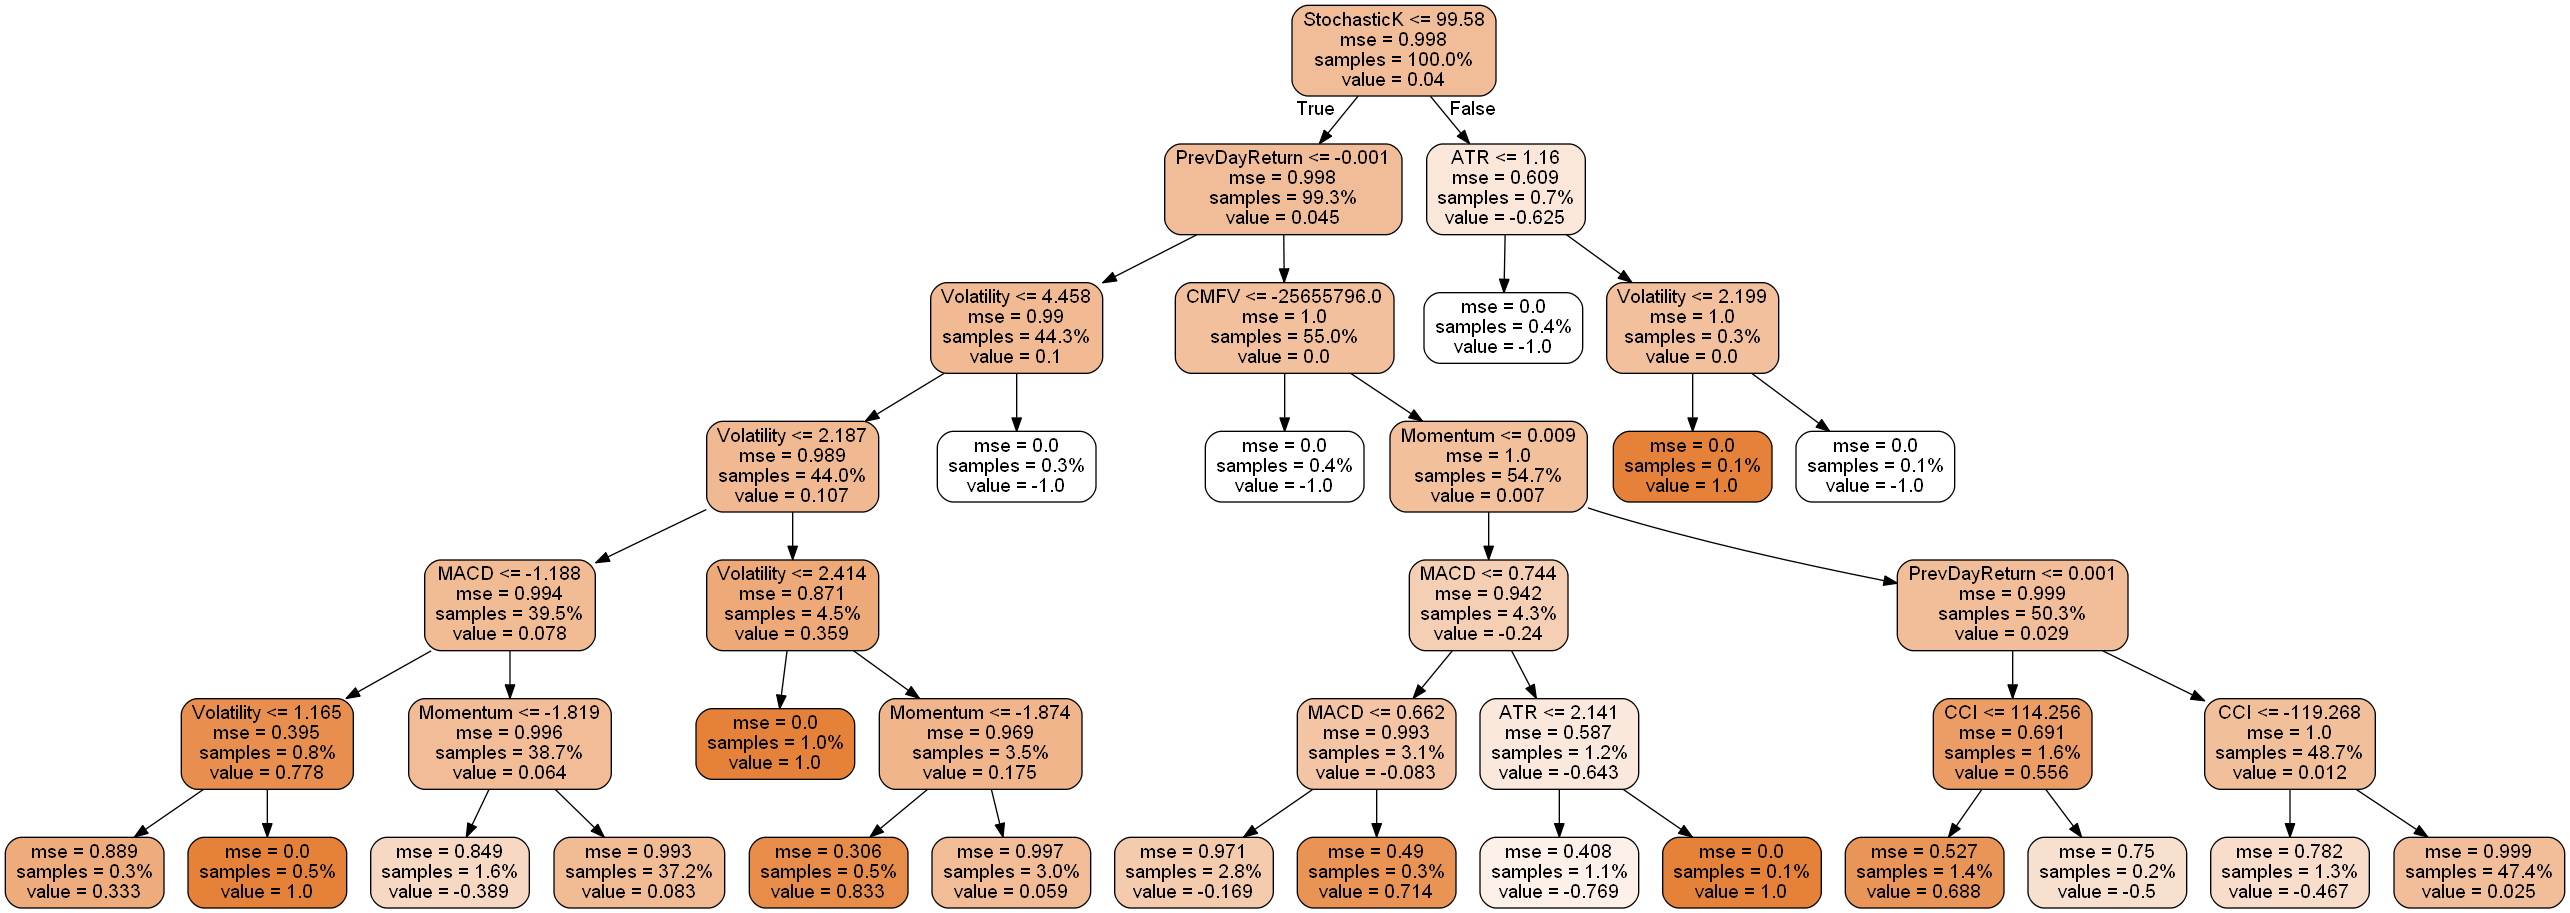

In [294]:
Image('C:/Users/sande/OneDrive/CQF/Project/Final Project - Python/Output/DecisionTreeREG_graphviz.png')

In [295]:
from pandas.plotting import radviz
from sklearn.tree import DecisionTreeClassifier

In [301]:
#Chosen sample features 
DecisionTreeSamplefeatureCols=['PrevDayReturn','Momentum','StochasticK']

In [302]:
DecisionTreeClf = DecisionTreeClassifier(random_state=rnd)
DecisionTreeClf.fit(dfDecisionTreeData[DecisionTreeSamplefeatureCols], dfDecisionTreeData[DecisionTreeTarget])
DecisionTreeReturnPredict = clf.predict(dfDecisionTreeData[DecisionTreeSamplefeatureCols])

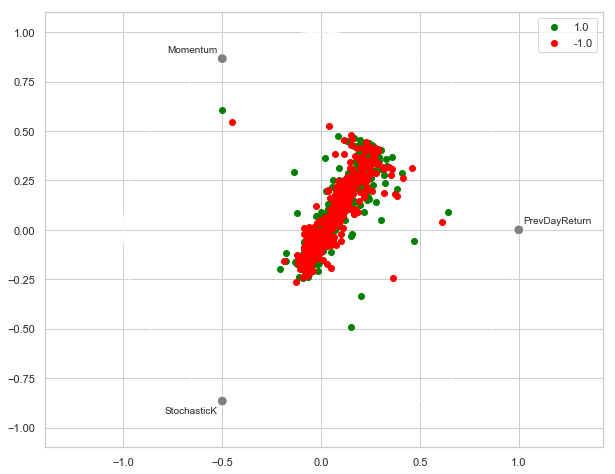

In [304]:
from pandas.plotting import radviz
X_Features = dfDecisionTreeData[DecisionTreeSamplefeatureCols]
X_Features['ReturnSign'] = DecisionTreeReturnPredict
plt.clf
plt.figure(figsize=(10, 8))
radviz(X_Features, 'ReturnSign',color=['Green','Red'])
plt.show()


## 2. Implementation of Logistic classification - Price Prediction, Quality and Bias

In [336]:
#Snap Stock data to Logistic dataframe variable
dfLogisData=pd.DataFrame(dfJPMCdata).copy()
# Identify indexes of ActDailyReturns where return=0
indWithZeroRtn = dfLogisData[ dfLogisData['ActDailyReturn'] == 0 ].index
# Delete these row indexes from dataFrame
dfLogisData.drop(indWithZeroRtn , inplace=True)

In [637]:
#Snap Stock data to Logistic dataframe variable
dfBayesData=pd.DataFrame(dfLogisData).copy()

In [337]:
dfLogisData.head(5)

Price  ActDailyReturn       Open       High        Low  \
Date                                                                     
2010-10-18  29.783682        0.027872  37.150002  38.259998  37.009998   
2010-10-19  29.386057       -0.013440  37.900002  38.650002  37.500000   
2010-10-20  29.705730        0.010820  38.000000  38.299999  37.459999   
2010-10-21  29.393862       -0.010554  38.189999  38.400002  36.209999   
2010-10-25  28.902645       -0.016853  37.970001  38.070000  37.000000   

                Close      Volume  PrevDayReturn  PrevDayOpen  PrevDayHigh  \
Date                                                                         
2010-10-18  38.200001  55058700.0      -0.041393    38.869999    38.939999   
2010-10-19  37.689999  70595100.0       0.027872    37.150002    38.259998   
2010-10-20  38.099998  43497200.0      -0.013440    37.900002    38.650002   
2010-10-21  37.700001  38250300.0       0.010820    38.000000    38.299999   
2010-10-25  37.070000  37893500.0       0.000000    37.500000    37.790001   

            ...       21MA       50MA      200MA      21EMA      50EMA  \
Date        ...                                                          
2010-10-18  ...  30.687408  30.170274  31.570893  30.511467  30.967187   
2010-10-19  ...  30.620267  30.136156  31.558172  30.653473  30.968743   
2010-10-20  ...  30.492292  30.103742  31.538685  30.740099  30.950345   
2010-10-21  ...  30.401786  30.087844  31.517574  30.772837  30.889831   
2010-10-25  ...  30.270423  30.086556  31.466989  30.762147  30.768772   

               200EMA  Dividends  SplitRatio  DividendYield  ReturnSign  
Date                                                                     
2010-10-18  32.327969        0.0           0            0.0         1.0  
2010-10-19  32.808051        0.0           0            0.0        -1.0  
2010-10-20  33.185122        0.0           0            0.0         1.0  
2010-10-21  33.420954        0.0           0            0.0        -1.0  
2010-10-25  33.871938        0.0           0            0.0        -1.0  

[5 rows x 41 columns]

In [639]:
#Naive Bayes classification
from sklearn.naive_bayes import BernoulliNB 
naivebayes = BernoulliNB()
naivebayes.fit(dfBayesData[LogifeatureCols], dfBayesData['ReturnSign'])
naivebayes.get_params
BayesProbArray = naivebayes.predict_proba(dfBayesData[LogifeatureCols])
y=dfBayesData['ReturnSign']
BayesActReturn=dfBayesData["ReturnSign"].to_numpy()
BayesProbArray

array([[0.446544  , 0.553456  ],
       [0.51167523, 0.48832477],
       [0.446544  , 0.553456  ],
       ...,
       [0.51167523, 0.48832477],
       [0.51167523, 0.48832477],
       [0.51167523, 0.48832477]])

## Logistic Regression Coefficients:

In [338]:
#Create penalised version(penalty=L1,L2) with regularization 'Logistic Regression object'-> LogisticReg 
LogisticReg1=linear_model.LogisticRegression(C = 1e5,penalty ='l1') 
LogisticReg2=linear_model.LogisticRegression(C = 1e5,penalty ='l2')

In [339]:
LogisticReg1

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [340]:
#LogifeatureCols=['PrevDayReturn','Momentum','MA','RSI','StochasticK','MACD','CCI',
#                         'ATR','CMFV','ADI','Volatility','EMA','YangZhangVol','21DMomentum','21MA','21EMA']
LogifeatureCols=['PrevDayReturn','Momentum','StochasticK']
Target=['ReturnSign']

In [341]:
L1reg = LogisticReg1.fit(dfLogisData[LogifeatureCols], dfLogisData['ReturnSign'])
L2reg = LogisticReg2.fit(dfLogisData[LogifeatureCols], dfLogisData['ReturnSign'])

In [342]:
L1RegScore=L1reg.score(dfLogisData[LogifeatureCols], dfLogisData['ReturnSign'])
L2RegScore=L2reg.score(dfLogisData[LogifeatureCols], dfLogisData['ReturnSign'])

In [343]:
LogiL1Coeff = pd.DataFrame(L1reg.coef_)
LogiL2Coeff = pd.DataFrame(L2reg.coef_)

In [344]:
dfLogisData['logistic_pred'] = LogisticReg2.predict(dfLogisData[LogifeatureCols])
dfLogisData['logistic_pred_return'] = dfLogisData['ActDailyReturn'] * dfLogisData['logistic_pred']

In [345]:
dfLogisData.tail(5)

Price  ActDailyReturn        Open        High         Low  \
Date                                                                         
2019-12-23  136.324814       -0.000292  137.600006  137.910004  136.880005   
2019-12-24  136.702393        0.002766  137.330002  137.630005  137.059998   
2019-12-26  138.153076        0.010556  137.889999  139.100006  137.779999   
2019-12-27  138.252441        0.000719  139.300003  139.770004  138.669998   
2019-12-30  137.745697       -0.003672  139.899994  140.080002  138.470001   

                 Close     Volume  PrevDayReturn  PrevDayOpen  PrevDayHigh  \
Date                                                                         
2019-12-23  137.199997  9738400.0      -0.000801   138.020004   138.880005   
2019-12-24  137.580002  3324300.0      -0.000292   137.600006   137.910004   
2019-12-26  139.039993  6770900.0       0.002766   137.330002   137.630005   
2019-12-27  139.139999  7868200.0       0.010556   137.889999   139.100006   
2019-12-30  138.630005  6963000.0       0.000719   139.300003   139.770004   

            ...       200MA       21EMA       50EMA      200EMA  Dividends  \
Date        ...                                                              
2019-12-23  ...  113.804488  126.878847  112.454661  102.076704        0.0   
2019-12-24  ...  113.979304  127.158562  112.582211  102.066593        0.0   
2019-12-26  ...  114.157513  127.476078  112.841527  102.059966        0.0   
2019-12-27  ...  114.341276  127.780989  113.079764  102.062586        0.0   
2019-12-30  ...  114.520921  128.093408  113.334766  102.076876        0.0   

            SplitRatio  DividendYield  ReturnSign  logistic_pred  \
Date                                                               
2019-12-23           0            0.0        -1.0            1.0   
2019-12-24           0            0.0         1.0            1.0   
2019-12-26           0            0.0         1.0            1.0   
2019-12-27           0            0.0         1.0            1.0   
2019-12-30           0            0.0        -1.0            1.0   

            logistic_pred_return  
Date                              
2019-12-23             -0.000292  
2019-12-24              0.002766  
2019-12-26              0.010556  
2019-12-27              0.000719  
2019-12-30             -0.003672  

[5 rows x 43 columns]

### Transition Probabilities

In [346]:
LogisticReg1.predict_proba(dfLogisData[LogifeatureCols])

array([[0.40846984, 0.59153016],
       [0.52664633, 0.47335367],
       [0.45570009, 0.54429991],
       ...,
       [0.47815644, 0.52184356],
       [0.47312938, 0.52687062],
       [0.47989881, 0.52010119]])

In [347]:
LogisticReg2.predict_proba(dfLogisData[LogifeatureCols])

array([[0.4087534 , 0.5912466 ],
       [0.52643634, 0.47356366],
       [0.45579116, 0.54420884],
       ...,
       [0.47818832, 0.52181168],
       [0.47320592, 0.52679408],
       [0.47992903, 0.52007097]])

### L1 Cost function(Lasso) and regression coefficients

In [348]:
print(LogifeatureCols)
print("Intercept: ")
print(L1reg.intercept_)
print("Beta: ")
LogiL1Coeff

['PrevDayReturn', 'Momentum', 'StochasticK']
Intercept: 
[0.08903241]
Beta: 


0        1         2
0 -9.495665  0.08992 -0.000118

### L2 Cost function(Ridge) and regression coefficients

In [349]:
print(LogifeatureCols)
print("Intercept: ")
print(L2reg.intercept_)
print("Beta: ")
LogiL2Coeff 

['PrevDayReturn', 'Momentum', 'StochasticK']
Intercept: 
[0.08912899]
Beta: 


0         1        2
0 -9.452908  0.089485 -0.00012

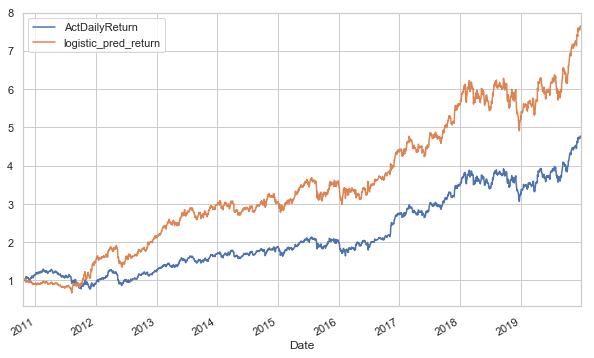

In [350]:
dfLogisData[['ActDailyReturn', 'logistic_pred_return']].cumsum().apply(np.exp).plot(figsize=(10, 6))

### Reshuffled Samples & K-Fold Cross Validation

In [371]:
#Splits our data into random train and test subsets with shuffling
X_Train, X_Test, Y_Train, Y_Test = model_selection.train_test_split(
    dfLogisData[LogifeatureCols], dfLogisData['ReturnSign'], test_size=0.5, shuffle=True)

In [372]:
X_Train.head()

PrevDayReturn  Momentum  StochasticK
Date                                            
2016-09-30      -0.016017 -0.963600    19.354865
2017-04-21       0.012823  1.015175    27.169023
2018-03-16       0.002520  0.274605    50.182650
2015-02-17       0.001677  0.087154    90.756252
2018-01-23       0.011613  1.249855    99.208476

In [373]:
X_Test.head()

PrevDayReturn  Momentum  StochasticK
Date                                            
2016-02-01       0.038025  1.987820    96.414337
2011-06-07      -0.025336 -0.816187     4.020097
2017-10-25       0.015780  1.488297    95.666065
2012-03-07      -0.027097 -0.866507    59.268913
2014-12-09      -0.000478 -0.025974    86.426549

In [374]:
#Running the logistic regression with 50% - train & test shuffled sample
LogiRegReShuffleSample = linear_model.LogisticRegression(C=1e5) #Re-estimate on Training Dataset
LogiRegReShuffleSample.fit(X_Train, Y_Train) ###FITTING DONE HERE
Y_Pred = LogiRegReShuffleSample.predict(X_Test)
LogiSampleScore=LogiRegReShuffleSample.score(X_Test, Y_Test)
print('Coefficients: ')
print( LogiRegReShuffleSample.coef_.ravel())
print('Population Coefficients: ')
print( LogisticReg2.coef_.ravel())

Coefficients: 
[-4.01975036e+00  2.44714488e-02 -9.68130513e-05]
Population Coefficients: 
[-9.45290850e+00  8.94845493e-02 -1.19938051e-04]


In [375]:
print("Population score: %s" % L2RegScore)
print("Shuffled Sample score: %s" % LogiSampleScore)

Population score: 0.5252173913043479
Shuffled Sample score: 0.5356521739130434


### K-Folds cross-validator
This method will split the given dataset into K subsets of which K-1 subsets to train our data and rest 01 as test data

In [376]:
#Taking split size of 05 without randomstate & shuffling
kFCrossVal = model_selection.KFold(n_splits=10, random_state=None, shuffle=False)
print(kFCrossVal)
print()
crossval = model_selection.cross_val_score(
            LogisticReg2, dfLogisData[LogifeatureCols], dfLogisData['ReturnSign'], cv=kFCrossVal, scoring='accuracy')
print("10-fold crossvalidation accuracy: %.4f" % (crossval.mean())) #average accuracy

KFold(n_splits=10, random_state=None, shuffle=False)

10-fold crossvalidation accuracy: 0.5248


In [380]:
#Repeats Stratified K-Fold n times with different randomization in each repetition
stratifiedkFCrossVal = model_selection.RepeatedStratifiedKFold(n_splits=100, n_repeats=5,random_state = 5)
print(stratifiedkFCrossVal)
print()
stratifiedCrossval = model_selection.cross_val_score(
            LogisticReg2, dfLogisData[LogifeatureCols], dfLogisData['ReturnSign'], cv=stratifiedkFCrossVal, scoring='accuracy')
print("100-fold crossvalidation with Stratified sampling accuracy: %.4f" % (stratifiedCrossval.mean())) #average accuracy


100-fold crossvalidation with Stratified sampling accuracy: 0.5245


### Prediction quality using confusion Matrix & Area under ROC curve

In [381]:
#Generate Precision, recall and F-measures matrix for our Logistic regression model
from sklearn.metrics import classification_report, confusion_matrix
LogisRegConfusionMatrix = confusion_matrix(Y_Test,Y_Pred)
LogisRegMatrixWithPrecRecall = classification_report(Y_Test, Y_Pred)

##### Logistic regression Confusion Matrix with prediction of -ve when actually -ve & +ve when actually +ve

In [382]:
print(LogisRegConfusionMatrix)

[[ 43 502]
 [ 32 573]]


##### Area Under the Receiver Operating Characteristic Curve (ROC Curve) from predictions

In [383]:
print( "Area under ROC Curve = " + str(roc_auc_score(Y_Test,Y_Pred)));

Area under ROC Curve = 0.5130032602926681


In [384]:
print("Predicting down movements when actual returns were Negative = " + str(LogisRegConfusionMatrix[0,0]))
print("Incorrect prediction of down movements when actual returns were Negative = "+ 
      str(LogisRegConfusionMatrix[0,0]+LogisRegConfusionMatrix[0,1]))
print("Predicting up movements when actual returns were positive = %s" %LogisRegConfusionMatrix[1,1])
print("Incorrect prediction of up movements when actual return were positive = " +
          str(LogisRegConfusionMatrix[1,0]+LogisRegConfusionMatrix[1,1]))

Predicting down movements when actual returns were Negative = 43
Incorrect prediction of down movements when actual returns were Negative = 545
Predicting up movements when actual returns were positive = 573
Incorrect prediction of up movements when actual return were positive = 605


### Precision & Recall Statistics
Precision => Ability of the classifier not to label as positive a sample that is negative

Recall    => Ability of the classifier to find all the positive samples

F-Beta    => Weighted harmonic mean of the precision and recall

In [385]:
print(LogisRegMatrixWithPrecRecall)

              precision    recall  f1-score   support

        -1.0       0.57      0.08      0.14       545
         1.0       0.53      0.95      0.68       605

    accuracy                           0.54      1150
   macro avg       0.55      0.51      0.41      1150
weighted avg       0.55      0.54      0.42      1150



In [386]:
print("Quality of down movements when actual returns were Negative = " + 
      str(LogisRegConfusionMatrix[0,0]*100/(LogisRegConfusionMatrix[0,0]+LogisRegConfusionMatrix[0,1])) + "%")
print("Quality of up movements when actual returns were Positive = " + 
      str(LogisRegConfusionMatrix[1,1]*100/(LogisRegConfusionMatrix[1,0]+LogisRegConfusionMatrix[1,1])) + "%")

Quality of down movements when actual returns were Negative = 7.889908256880734%
Quality of up movements when actual returns were Positive = 94.7107438016529%


In [390]:
#UDF to plot confusion matrix
def plot_cm(cm, target_names, title, cmap=plt.cm.viridis):
    cm_norm = cm * 1. / cm.sum(axis=1)[:, np.newaxis] # standardize the confusion matrix
    plt.imshow(cm_norm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    ticks = np.arange(len(target_names))
    plt.xticks(ticks, target_names, rotation=45)
    plt.yticks(ticks, target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.clf
    plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

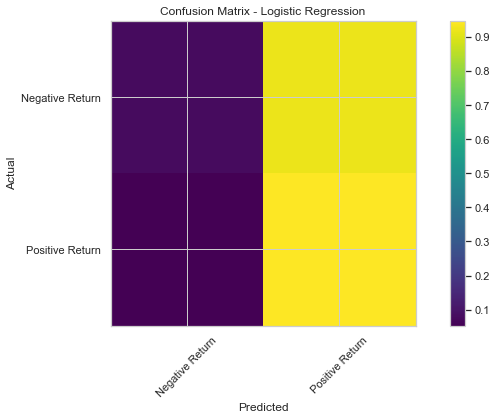

<Figure size 960x640 with 0 Axes>

In [392]:
plot_cm(LogisRegConfusionMatrix, ['Negative Return','Positive Return'], 'Confusion Matrix - Logistic Regression')
plt.rcParams['figure.figsize'] = [9, 6]
plt.show()

In [393]:
#UDF to plot ROC Curve
def plot_logistic_ROC(default_ind):
        default_ind_name = ['Positive Return', 'Negative Return'] 
        logit_roc_aucT = roc_auc_score(Y_Test,Y_Pred)
        fprT, tprT, thresholdsT = roc_curve(Y_Test, LogisticReg1.predict_proba(X_Test)[:,1], pos_label=default_ind)
        logit_roc_aucP = roc_auc_score(dfLogisData['ReturnSign'], LogisticReg2.predict(dfLogisData[LogifeatureCols]))
        fprP, tprP, thresholdsP = roc_curve(dfLogisData['ReturnSign'], 
                                    LogisticReg2.predict_proba(dfLogisData[LogifeatureCols])[:,1], pos_label=default_ind)
        fig, ax = plt.subplots(figsize=(10,8)) 
        ax.plot([0, 1], [0, 1],'r--', label='Random Classifier')
        ax.plot(fprT, tprT, label='Train/Test Regression (area = %0.4f)' % logit_roc_aucT)
        ax.plot(fprP, tprP, label='Population Regression (area = %0.4f)' % logit_roc_aucP)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False ' + default_ind_name[default_ind] + ' Rate', fontsize=20)
        plt.ylabel('True ' + default_ind_name[default_ind] + ' Rate', fontsize=20)
        plt.legend(loc="lower right", fontsize=14)
        plt.show()
        return ax

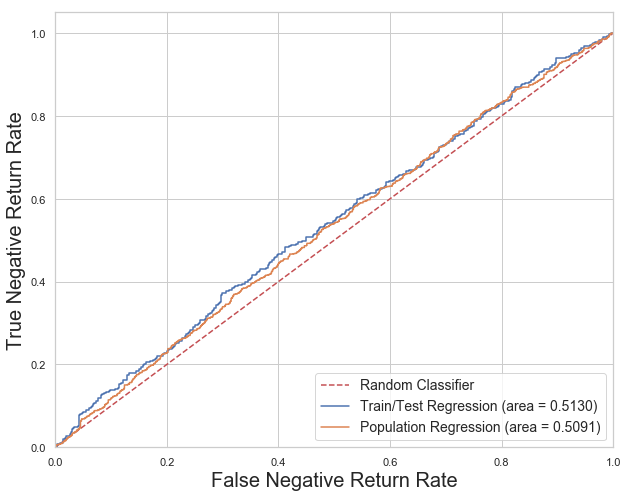

In [394]:
plot_logistic_ROC(1)

## Improving the Logistic classifier by tuning hyperparameters with modified features

In [395]:
from sklearn.metrics import accuracy_score
from scipy import stats
from seaborn import distplot

In [411]:
#Initial chosen features & hyperparams
print('Initial Features: ' + str(LogifeatureCols))
print('Hyperparameters:  ' + str(LogisticReg2).replace('LogisticRegression',''))

Initial Features: ['PrevDayReturn', 'Momentum', 'StochasticK']
Hyperparameters:  (C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [412]:
Accuracy_Before=accuracy_score(dfLogisData['ReturnSign'], LogisticReg2.predict(dfLogisData[LogifeatureCols]))  

In [413]:
Accuracy_Before

0.5252173913043479

In [472]:
##Creation of GridSearchCV Parameters
import time
dual=[True,False]
max_iter=[10,150,100,250,500,1000]
C = [0.0001,0.1,1,1.25,1.5,1.75,2,2.5,4,10,15,100,200,5000,100000]
LogiHyperparams_gridCV = dict(dual=dual,max_iter=max_iter,C=C) 
LogiModifiedfeatureCols=['PrevDayReturn','21DMomentum','RSI','StochasticK','MACD',
                         'ATR','ADI','EMA','YangZhangVol']

In [476]:
grid = GridSearchCV(estimator=LogisticReg2, param_grid=LogiHyperparams_gridCV, cv = 3, n_jobs=-1)
start_time = time.time()
grid_result = grid.fit(dfLogisData[LogiModifiedfeatureCols], dfLogisData['ReturnSign'])
print("Prior feature columns" + str(LogifeatureCols))
print("Accuracy BEFORE: " + str(Accuracy_Before))
print("##########******AFTER tunning the Logistic Regression hyperparameters******########")
print("Modified feature columns" + str(LogiModifiedfeatureCols))
print("Accuracy AFTER: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' secs')

Prior feature columns['PrevDayReturn', 'Momentum', 'StochasticK']
Accuracy BEFORE: 0.5252173913043479
##########******AFTER tunning the Logistic Regression hyperparameters******########
Modified feature columns['PrevDayReturn', '21DMomentum', 'RSI', 'StochasticK', 'MACD', 'ATR', 'ADI', 'EMA', 'YangZhangVol']
Accuracy AFTER: 0.528261 using {'C': 10, 'dual': True, 'max_iter': 500}
Execution time: 6.055996417999268 secs


### Classification Report with precision & recall  - Initial hyperparameters & features

In [ ]:
print(classification_report(dfLogisData['ReturnSign'], LogisticReg2.predict(dfLogisData[LogifeatureCols])))

In [477]:
LogisticReg_After=linear_model.LogisticRegression(C= 10, dual= True, max_iter= 500) # Enhanced hyperparams
LogisticReg_After.fit(dfLogisData[LogiModifiedfeatureCols], dfLogisData['ReturnSign'])# Modified Feature columns

LogisticRegression(C=10, class_weight=None, dual=True, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Classification Report with precision & recall After tuning hyperparameters & modified features

In [478]:
print(classification_report(dfLogisData['ReturnSign'], LogisticReg_After.predict(dfLogisData[LogiModifiedfeatureCols])))

              precision    recall  f1-score   support

        -1.0       0.47      0.39      0.42      1104
         1.0       0.51      0.60      0.55      1196

    accuracy                           0.50      2300
   macro avg       0.49      0.49      0.49      2300
weighted avg       0.49      0.50      0.49      2300



In [479]:
Before_CM= confusion_matrix(dfLogisData['ReturnSign'], LogisticReg2.predict(dfLogisData[LogifeatureCols]))
After_CM= confusion_matrix(dfLogisData['ReturnSign'], LogisticReg_After.predict(dfLogisData[LogiModifiedfeatureCols]))

In [480]:
print("Predicting down movements/Negative Returns(BEFORE) = " + str(Before_CM[0,0]))

print("Predicting down movements/Negative Returns(AFTER) = " + str(After_CM[0,0]))

Predicting down movements/Negative Returns(BEFORE) = 117
Predicting down movements/Negative Returns(AFTER) = 426


### With the above results we can see improvement in predicting Negative Returns from 117 to 426 by tuning hyperparameters and including more features

# Logistic Regression - Transition Probabilities

### Before tuning hyperparams with initial features
#### Initial Features: ['PrevDayReturn', 'Momentum', 'StochasticK']
#### Hyperparameters:  
                      (C=100000.0, class_weight=None, dual=False,
                       fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                       max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                       random_state=None, solver='warn', tol=0.0001, verbose=0,
                       warm_start=False)

In [518]:
Logistic_Predict_Prob=LogisticReg2.predict_proba(dfLogisData[LogifeatureCols])

In [519]:
Logistic_Predict_Prob, dfLogisData["ReturnSign"]

(array([[0.4087534 , 0.5912466 ],
        [0.52643634, 0.47356366],
        [0.45579116, 0.54420884],
        ...,
        [0.47818832, 0.52181168],
        [0.47320592, 0.52679408],
        [0.47992903, 0.52007097]]), Date
 2010-10-18    1.0
 2010-10-19   -1.0
 2010-10-20    1.0
 2010-10-21   -1.0
 2010-10-25   -1.0
              ... 
 2019-12-23   -1.0
 2019-12-24    1.0
 2019-12-26    1.0
 2019-12-27    1.0
 2019-12-30   -1.0
 Name: ReturnSign, Length: 2300, dtype: float64)

In [520]:
ActReturn=dfLogisData["ReturnSign"].to_numpy()

##### Scheme to use Predict_Proba [Logistic_Predict_Prob] to produce scatter plots with colour coing for correctly vs incorrectly predictions

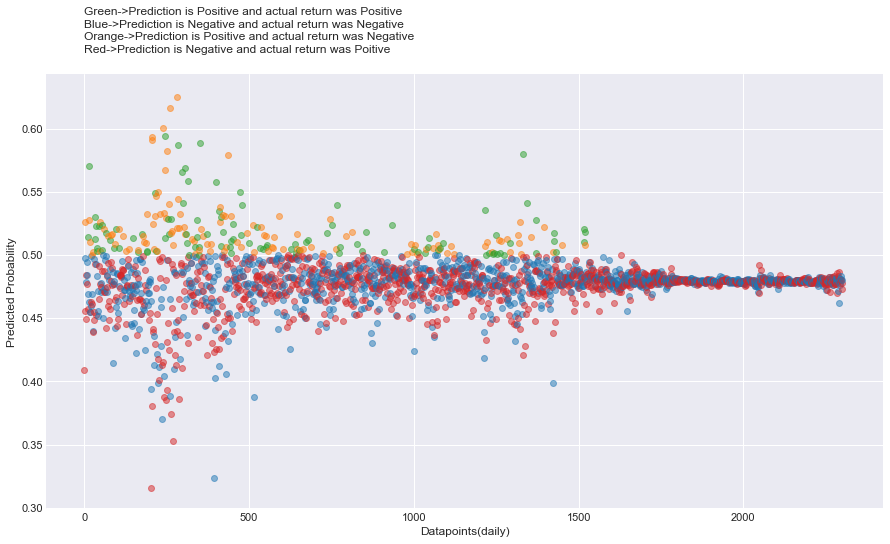

In [521]:
#Scatter plot:
fig, ax = plt.subplots()
color=['tab:orange', 'tab:red','tab:blue', 'tab:green']
iColor=''
for i in range(len(ActReturn)):
    if(Logistic_Predict_Prob[i][0]>=0.5 and ActReturn[i]==1):
        x=i+1 
        y=Logistic_Predict_Prob[i][0]
        iColor=color[3]
    if(Logistic_Predict_Prob[i][0]<0.5 and ActReturn[i]==-1):
        x=i+1
        y=1* Logistic_Predict_Prob[i][0]
        iColor=color[2]
    if(Logistic_Predict_Prob[i][0]<0.5 and ActReturn[i]==1):
        x=i+1
        y=1 * Logistic_Predict_Prob[i][0]
        iColor=color[1]
    if(Logistic_Predict_Prob[i][0]>=0.5 and ActReturn[i]==-1):
        x= i+1
        y= 1 * Logistic_Predict_Prob[i][0]
        iColor=color[0]
    ax.scatter(x, y, c=iColor, linewidth=1, alpha=0.5, label=iColor)
ax.grid(True)
plt.rcParams['figure.figsize'] = [15, 8]
plt.text(1,0.69,'Green->Prediction is Positive and actual return was Positive')
plt.text(1,0.68,'Blue->Prediction is Negative and actual return was Negative')
plt.text(1,0.67,'Orange->Prediction is Positive and actual return was Negative')
plt.text(1,0.66,'Red->Prediction is Negative and actual return was Poitive')
plt.style.use('seaborn-darkgrid')
plt.xlabel("Datapoints(daily)")
plt.ylabel("Predicted Probability")
plt.show()

### After tuning hyperparams with initial features
#### Modifield Features: ['PrevDayReturn', '21DMomentum', 'RSI', 'StochasticK', 'MACD', 'ATR', 'ADI', 'EMA', 'YangZhangVol']
#### Tuned Hyperparameters:  (C= 10, dual= True, max_iter= 500)

In [522]:
Logistic_Predict_Prob_After=LogisticReg_After.predict_proba(dfLogisData[LogiModifiedfeatureCols])

In [523]:
Logistic_Predict_Prob_After, dfLogisData["ReturnSign"]

(array([[1.00000000e+00, 3.80504899e-13],
        [9.99364063e-01, 6.35937059e-04],
        [1.59191351e-01, 8.40808649e-01],
        ...,
        [1.89491447e-01, 8.10508553e-01],
        [3.69355837e-03, 9.96306442e-01],
        [1.84456998e-02, 9.81554300e-01]]), Date
 2010-10-18    1.0
 2010-10-19   -1.0
 2010-10-20    1.0
 2010-10-21   -1.0
 2010-10-25   -1.0
              ... 
 2019-12-23   -1.0
 2019-12-24    1.0
 2019-12-26    1.0
 2019-12-27    1.0
 2019-12-30   -1.0
 Name: ReturnSign, Length: 2300, dtype: float64)

In [524]:
ActReturn=dfLogisData["ReturnSign"].to_numpy()

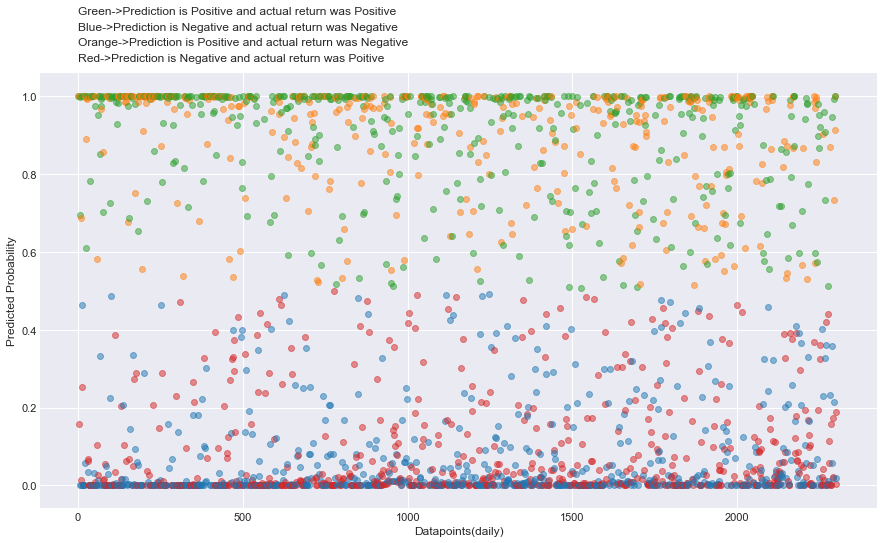

In [525]:
#Scatter plot:
fig, ax = plt.subplots()
color=['tab:orange', 'tab:red','tab:blue', 'tab:green']
iColor=''
for i in range(len(ActReturn)):
    if(Logistic_Predict_Prob_After[i][0]>=0.5 and ActReturn[i]==1):
        x=i+1 
        y=Logistic_Predict_Prob_After[i][0]
        iColor=color[3]
    if(Logistic_Predict_Prob_After[i][0]<0.5 and ActReturn[i]==-1):
        x=i+1
        y=1* Logistic_Predict_Prob_After[i][0]
        iColor=color[2]
    if(Logistic_Predict_Prob_After[i][0]<0.5 and ActReturn[i]==1):
        x=i+1
        y=1 * Logistic_Predict_Prob_After[i][0]
        iColor=color[1]
    if(Logistic_Predict_Prob_After[i][0]>=0.5 and ActReturn[i]==-1):
        x= i+1
        y= 1 * Logistic_Predict_Prob_After[i][0]
        iColor=color[0]
    ax.scatter(x, y, c=iColor, linewidth=1, alpha=0.5, label=iColor)
ax.grid(True)
plt.rcParams['figure.figsize'] = [15, 8]
plt.text(1,1.21,'Green->Prediction is Positive and actual return was Positive')
plt.text(1,1.17,'Blue->Prediction is Negative and actual return was Negative')
plt.text(1,1.13,'Orange->Prediction is Positive and actual return was Negative')
plt.text(1,1.09,'Red->Prediction is Negative and actual return was Poitive')
plt.style.use('seaborn-darkgrid')
plt.xlabel("Datapoints(daily)")
plt.ylabel("Predicted Probability")
plt.show()

### Logistic Regression Over-relying on transition probabilities for poorly predicted negative values

From the above plot we can clearly evident Orange dot's means our prediction is Negative but actual returns were positive, Here is the classification report post tunning hyperparams with modifield features

              precision    recall  f1-score   support

        -1.0       0.47      0.39      0.42      1104
         1.0       0.51      0.60      0.55      1196

    accuracy                           0.50      2300
   macro avg       0.49      0.49      0.49      2300
weighted avg       0.49      0.50      0.49      2300

So we can conclude if we rely on these transition probabilities(above orange coloured plot) the quality of negative returns prediction is 39% from classification report post tuning hyperparams & changing to best features

### Kelly criterion before and after tuning hyperparams / Modified features

In [630]:
ThresholdLimit1=0.75
ThresholdLimit2=0.9
TotalKellyReturn=0

In [631]:
#UDF to compute Kelly's return = (expected net winnings)/(net winnings if you win)=2p-1
#when the probability of prediction meets a particular threshold
def KellysReturn(dfLogisPred,thresholdP):
    TotalKellyReturn=0
    for i in range(len(ActReturn)):
            excessReturn=0
            #Let's say we have traded only on those days
            #Get excess return (2p-1) and actual returns are positive, our prediction is correct with probability >Threshold
            if(float(dfLogisPred[i][0])>=float(thresholdP) and ActReturn[i]==1):
                TotalKellyReturn=TotalKellyReturn+(2*float(dfLogisPred[i][0])-1.0)
            #Similary on the downside movement as well our prediction was correct and we are on short side till close
            if(float(dfLogisPred[i][1])>=thresholdP and ActReturn[i]==-1):
                TotalKellyReturn=TotalKellyReturn+(2*float(dfLogisPred[i][1])-1.0)
    print("P&L when given threshold at "+str(thresholdP*100)+"% = " + str(TotalKellyReturn) + " times")

###### Kelly's return with initial hyperparams and  features

In [632]:
KellysReturn(Logistic_Predict_Prob,ThresholdLimit1)
KellysReturn(Logistic_Predict_Prob,ThresholdLimit2)

P&L when given threshold at 75.0% = 0 times
P&L when given threshold at 90.0% = 0 times


##### Kelly's return post tuning hyperparams and modified features

In [633]:
KellysReturn(Logistic_Predict_Prob_After,ThresholdLimit1)
KellysReturn(Logistic_Predict_Prob_After,ThresholdLimit2)

P&L when given threshold at 75.0% = 934.2077932510228 times
P&L when given threshold at 90.0% = 841.4159157258653 times


### With the above experiments we finally conclude by tuning hyperparameters and with modified features

we have not only improvised the number of correct negative predictions but also 
kelly's fractional betting have been giving outstanding results

# 3. Implementation of Support Vector Machines-Price Prediction,Quality & Bias

In [25]:
dfSVMData=pd.DataFrame(dfJPMCdata).copy()
# Identify indexes of ActDailyReturns where return=0
indWithZeroRtn = dfSVMData[ dfSVMData['ActDailyReturn'] == 0 ].index
# Delete these row indexes from dataFrame
dfSVMData.drop(indWithZeroRtn , inplace=True)

## SVM Soft vs Hard margin, mathematical notations & write-up as follows:

In [ ]:
Soft vs Hard margin, mathematical notation - write-up as follows:

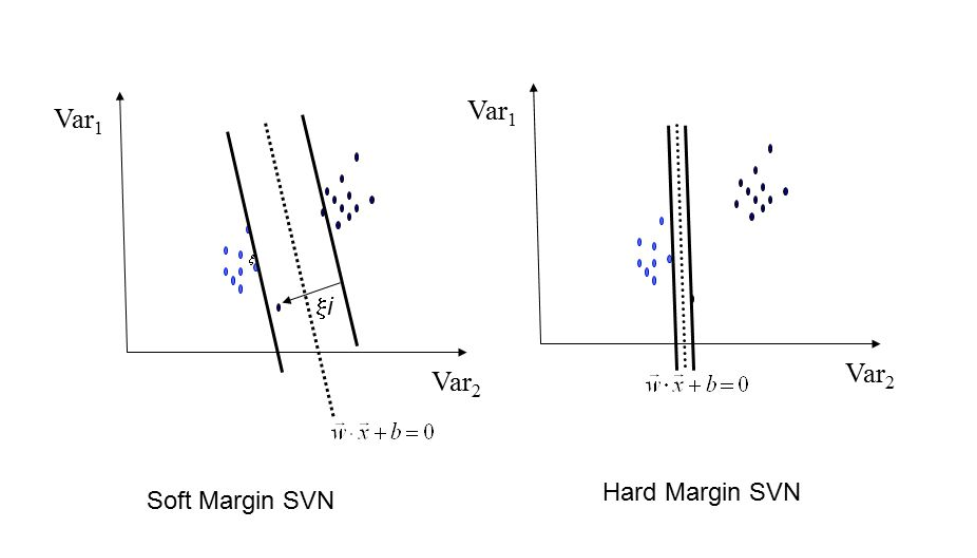

In [534]:
Image(filename = "Notes/SVM/A2_HardSoft.PNG" , width=500, height=900)

#### Consider Momentum Feature vs Previous day's Return & provide 2D relationships
Kernels as well we can change C=1e5 models = (svm.SVC(kernel='linear', C=C), svm.LinearSVC(C=C), svm.SVC(kernel='rbf', gamma=0.7, C=C), svm.SVC(kernel='poly', degree=3, C=C))

In [655]:
##dfSVMData.to_csv('SVMJPMC.csv')

In [681]:
#Features - 'PrevDayReturn','Momentum','MA','RSI','StochasticK','MACD','CCI','ATR','CMFV','Volatility','EMA','YangZhangVol'
#SVMModel = SVC(kernel='rbf', gamma=0.7, C=1E5)
SVMModel_2D = SVC(kernel='linear', C=1E5)
SVMfeatureCols=['PrevDayReturn','Momentum']
X=dfSVMData[SVMfeatureCols]
y=dfSVMData['ReturnSign']
SVMModel_2D.fit(X, y)

SVC(C=100000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [682]:
#UDF for plotting SVM scatter plot 2D
def plot_svc_decision_function(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

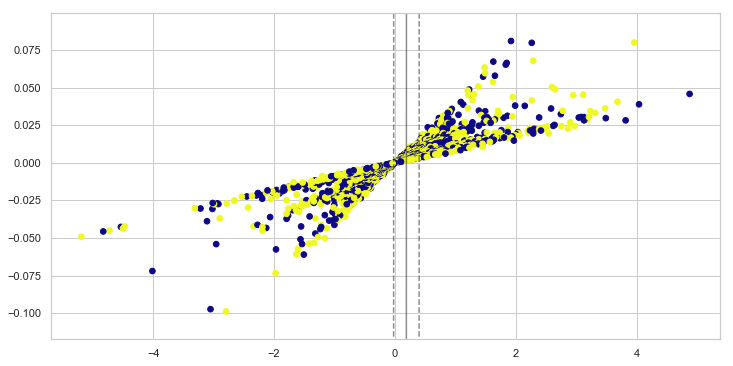

In [690]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
plt.scatter(dfSVMData['Momentum'], dfSVMData['PrevDayReturn'], c=y, s=32, cmap='plasma')
plt.rcParams['figure.figsize'] = [12, 6]
plot_svc_decision_function(SVMModel_2D);

In [868]:
#'PrevDayReturn','Momentum','MA','RSI','StochasticK','MACD','CCI','ATR','CMFV','Volatility','EMA','YangZhangVol'
SVMfeatureCols_3D=['StochasticK','CCI','RSI']
X_Features_3D = dfSVMData[SVMfeatureCols_3D] 
Y_Target_3D = dfSVMData['ReturnSign']
SVMModel_3D = SVC(kernel='linear', C=1E5)
SVMClf_3D = SVMModel_3D.fit(X_Features_3D, Y_Target_3D)

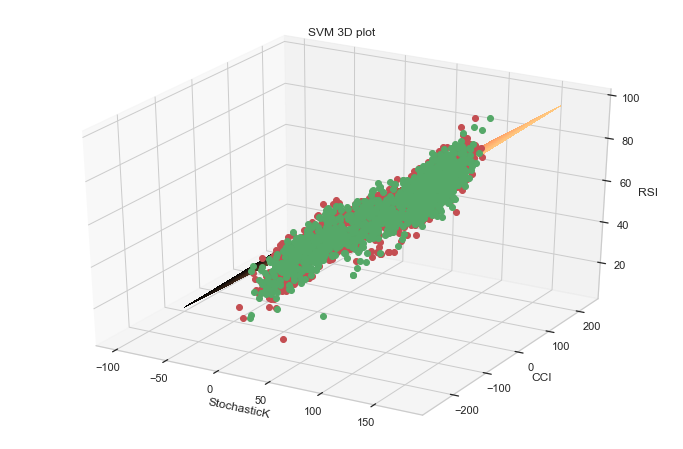

In [995]:
z = lambda x,y: (-SVMClf_3D.intercept_[0]-SVMClf_3D.coef_[0][0]*x-SVMClf_3D.coef_[0][1]*y) / SVMClf_3D.coef_[0][2]
tmp = np.linspace(175,-100,150)
x,y = np.meshgrid(tmp,tmp)
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.set_title('SVM 3D plot')
ax.plot_surface(x, y, z(x,y),cmap=plt.cm.copper,
                       linewidth=0, antialiased=False,label='separating plane')
ax.plot3D(dfSVMData['StochasticK'][dfSVMData.ReturnSign == -1], 
          dfSVMData['CCI'][dfSVMData.ReturnSign == -1], 
          dfSVMData['RSI'][dfSVMData.ReturnSign == -1],'or')
ax.plot3D(dfSVMData['StochasticK'][dfSVMData.ReturnSign == 1], 
          dfSVMData['CCI'][dfSVMData.ReturnSign == 1], 
          dfSVMData['RSI'][dfSVMData.ReturnSign == 1],'og')
ax.set_xlabel('StochasticK')
ax.set_ylabel('CCI')
ax.set_zlabel('RSI')
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()

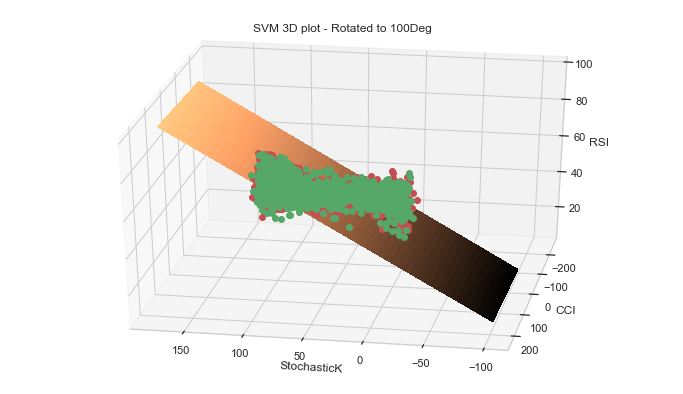

In [990]:
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.set_title('SVM 3D plot - Rotated to 100Deg')
ax.plot_surface(x, y, z(x,y),cmap=plt.cm.copper,
                       linewidth=0, antialiased=False)
ax.plot3D(dfSVMData['StochasticK'][dfSVMData.ReturnSign == -1], 
          dfSVMData['CCI'][dfSVMData.ReturnSign == -1], 
          dfSVMData['RSI'][dfSVMData.ReturnSign == -1],'or')
ax.plot3D(dfSVMData['StochasticK'][dfSVMData.ReturnSign == 1], 
          dfSVMData['CCI'][dfSVMData.ReturnSign == 1], 
          dfSVMData['RSI'][dfSVMData.ReturnSign == 1],'og')
ax.view_init(azim=100)
ax.set_xlabel('StochasticK')
ax.set_ylabel('CCI')
ax.set_zlabel('RSI')
plt.rcParams['figure.figsize'] = [12, 7]
plt.show()

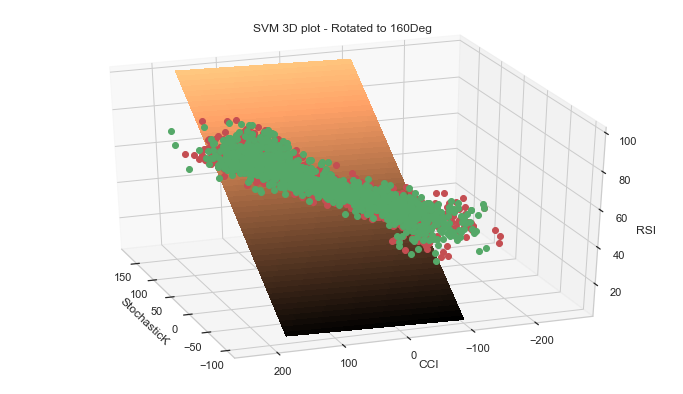

In [1000]:
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.set_title('SVM 3D plot - Rotated to 160Deg')
ax.plot_surface(x, y, z(x,y),cmap=plt.cm.copper,
                       linewidth=0, antialiased=False)
ax.plot3D(dfSVMData['StochasticK'][dfSVMData.ReturnSign == -1], 
          dfSVMData['CCI'][dfSVMData.ReturnSign == -1], 
          dfSVMData['RSI'][dfSVMData.ReturnSign == -1],'or')
ax.plot3D(dfSVMData['StochasticK'][dfSVMData.ReturnSign == 1], 
          dfSVMData['CCI'][dfSVMData.ReturnSign == 1], 
          dfSVMData['RSI'][dfSVMData.ReturnSign == 1],'og')
ax.view_init(azim=160)
ax.set_xlabel('StochasticK')
ax.set_ylabel('CCI')
ax.set_zlabel('RSI')
plt.rcParams['figure.figsize'] = [12, 7]
plt.show()

### Support Vector Machines -  Prediction of prices

In [26]:
dfSVMData=pd.DataFrame(dfJPMCdata).copy()
# Identify indexes of ActDailyReturns where return=0
indWithZeroRtn = dfSVMData[ dfSVMData['ActDailyReturn'] == 0 ].index
# Delete these row indexes from dataFrame
dfSVMData.drop(indWithZeroRtn , inplace=True)

In [27]:
#using 02 features we can see best fit vs 01 feature only Prev day's return
SVMfeatureCols=['PrevDayReturn','Momentum'] #['PrevDayReturn']
SVMModel = SVC(C= 1e5, probability=True)

In [28]:
SVMModel.fit(dfSVMData[SVMfeatureCols], dfSVMData['ReturnSign'])

SVC(C=100000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

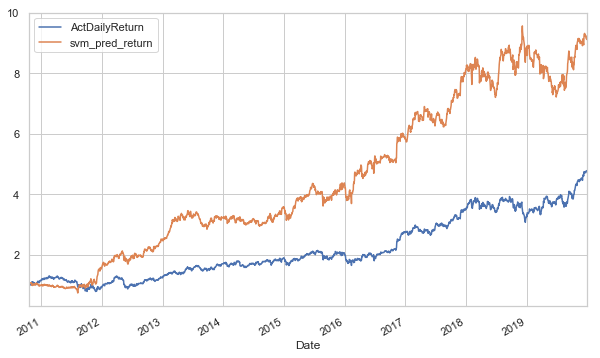

In [29]:
dfSVMData['svm_pred'] = SVMModel.predict(dfSVMData[SVMfeatureCols])
dfSVMData['svm_pred_return'] = dfSVMData['ActDailyReturn'] * dfSVMData['svm_pred']
dfSVMData[['ActDailyReturn', 'svm_pred_return']].cumsum().apply(np.exp).plot(figsize=(10, 6))

### Support Vector Machines prediction quality using confusion Matrix & Area under ROC curve

In [30]:
X_Train, X_Test, Y_Train, Y_Test = model_selection.train_test_split(
    dfSVMData[SVMfeatureCols], dfSVMData['ReturnSign'], test_size=0.5, shuffle=True)

In [31]:
SVMReShuffleSample = SVC(kernel='linear', C=1E5, probability=True) 
SVMReShuffleSample.fit(X_Train, Y_Train) 
Y_Pred = SVMReShuffleSample.predict(X_Test)
SVMampleScore=SVMReShuffleSample.score(X_Test, Y_Test)

In [32]:
print('Coefficients: ')
print( SVMReShuffleSample.coef_.ravel())

Coefficients: 
[-15.30885196  -0.2497475 ]


In [33]:
#Generate Precision, recall and F-measures matrix for our SVM model
from sklearn.metrics import classification_report, confusion_matrix
SVMConfusionMatrix = confusion_matrix(Y_Test,Y_Pred)
SVMMatrixWithPrecRecall = classification_report(Y_Test, Y_Pred)

### Support Vector Machines Confusion Matrix

In [34]:
print(SVMConfusionMatrix)

[[334 194]
 [377 245]]


##### Area Under the Receiver Operating Characteristic Curve (ROC Curve) from predictions

In [35]:
print( "Area under ROC Curve = " + str(roc_auc_score(Y_Test,Y_Pred)));

Area under ROC Curve = 0.5132332164084575


In [36]:
print("Predicting down movements when actual returns were Negative = " + str(SVMConfusionMatrix[0,0]))
print("Incorrect prediction of down movements when actual returns were Negative = "+ 
      str(SVMConfusionMatrix[0,0]+SVMConfusionMatrix[0,1]))
print("Predicting up movements when actual returns were positive = %s" %SVMConfusionMatrix[1,1])
print("Incorrect prediction of up movements when actual return were positive = " +
          str(SVMConfusionMatrix[1,0]+SVMConfusionMatrix[1,1]))

Predicting down movements when actual returns were Negative = 334
Incorrect prediction of down movements when actual returns were Negative = 528
Predicting up movements when actual returns were positive = 245
Incorrect prediction of up movements when actual return were positive = 622


### Precision & Recall Statistics
Precision => Ability of the classifier not to label as positive a sample that is negative

Recall    => Ability of the classifier to find all the positive samples

F-Beta    => Weighted harmonic mean of the precision and recall

In [37]:
print(SVMMatrixWithPrecRecall)

              precision    recall  f1-score   support

        -1.0       0.47      0.63      0.54       528
         1.0       0.56      0.39      0.46       622

    accuracy                           0.50      1150
   macro avg       0.51      0.51      0.50      1150
weighted avg       0.52      0.50      0.50      1150



In [38]:
print("Quality of down movements when actual returns were Negative = " + 
      str(SVMConfusionMatrix[0,0]*100/(SVMConfusionMatrix[0,0]+SVMConfusionMatrix[0,1])) + "%")
print("Quality of up movements when actual returns were Positive = " + 
      str(SVMConfusionMatrix[1,1]*100/(SVMConfusionMatrix[1,0]+SVMConfusionMatrix[1,1])) + "%")

Quality of down movements when actual returns were Negative = 63.25757575757576%
Quality of up movements when actual returns were Positive = 39.38906752411575%


In [39]:
# function for plotting confusion matrix
def plot_cm(cm, target_names, title, cmap=plt.cm.Greens):
    cm_norm = cm * 1. / cm.sum(axis=1)[:, np.newaxis] # standardize the confusion matrix
    plt.imshow(cm_norm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    ticks = np.arange(len(target_names))
    plt.xticks(ticks, target_names, rotation=45)
    plt.yticks(ticks, target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.clf
    plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

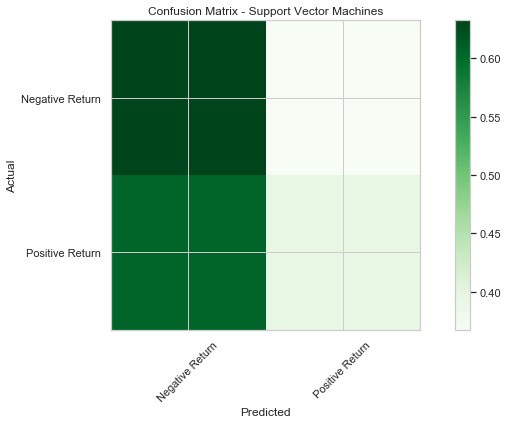

<Figure size 960x640 with 0 Axes>

In [40]:
plot_cm(SVMConfusionMatrix, ['Negative Return','Positive Return'], 'Confusion Matrix - Support Vector Machines')
plt.rcParams['figure.figsize'] = [10, 6]
plt.show()

### Area under ROC Curve Graphical representation

In [41]:
def plot_SVM_ROC(default_ind):
        default_ind_name = ['Positive Return', 'Negative Return'] 
        SVM_roc_aucT = roc_auc_score(Y_Test,Y_Pred)
        fprT, tprT, thresholdsT = roc_curve(Y_Test, SVMReShuffleSample.predict_proba(X_Test)[:,1], pos_label=default_ind)
        SVM_roc_aucP = roc_auc_score(dfSVMData['ReturnSign'], SVMReShuffleSample.predict(dfSVMData[SVMfeatureCols]))
        fprP, tprP, thresholdsP = roc_curve(dfSVMData['ReturnSign'], 
                                    SVMReShuffleSample.predict_proba(dfSVMData[SVMfeatureCols])[:,1], pos_label=default_ind)
        fig, ax = plt.subplots(figsize=(10,8)) 
        ax.plot([0, 1], [0, 1],'r--', label='Random Classifier')
        ax.plot(fprT, tprT, label='Train/Test Regression (area = %0.4f)' % SVM_roc_aucT)
        ax.plot(fprP, tprP, label='Population Regression (area = %0.4f)' % SVM_roc_aucP)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False ' + default_ind_name[default_ind] + ' Rate', fontsize=20)
        plt.ylabel('True ' + default_ind_name[default_ind] + ' Rate', fontsize=20)
        plt.legend(loc="lower right", fontsize=14)
        plt.show()
        return ax

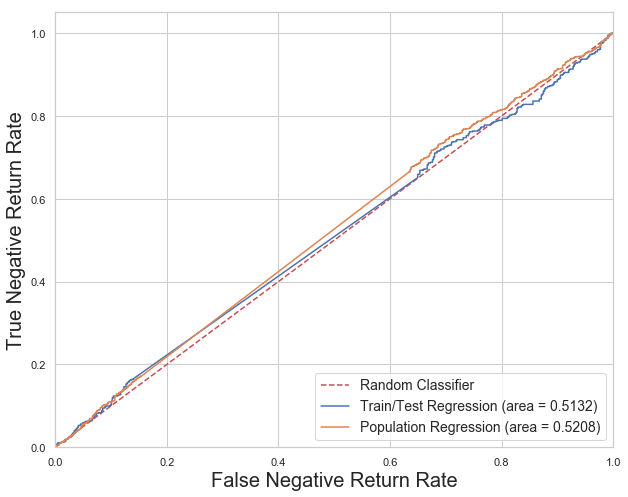

In [42]:
plot_SVM_ROC(1)

## Improve the Support Vector Machines by tuning hyperparameters with Modified features

In [46]:
from sklearn.metrics import accuracy_score
from scipy import stats
from seaborn import distplot
from sklearn.metrics import classification_report, confusion_matrix

In [53]:
SVMfeatureCols=['PrevDayReturn']
X_Train, X_Test, Y_Train, Y_Test = model_selection.train_test_split(
    dfSVMData[SVMfeatureCols], dfSVMData['ReturnSign'], test_size=0.5, shuffle=True)
SVMTuneSample = SVC( kernel='linear',C=0.01, probability=True,gamma=0.1) 
SVMTuneSample.fit(dfSVMData[SVMfeatureCols], dfSVMData['ReturnSign'])
Y_Pred = SVMTuneSample.predict(X_Test)
SVMTuneSampleScore=SVMTuneSample.score(X_Test, Y_Test)

In [54]:
SVMTuneSample

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [55]:
SVMModifiedfeatureCols=['CCI']

In [61]:
Accuracy_Before=accuracy_score(dfSVMData['ReturnSign'], SVMTuneSample.predict(dfSVMData[SVMfeatureCols]))  

In [62]:
Accuracy_Before

0.5026086956521739

### A) Support Vector Machines BEFORE & AFTER tunning hyperparameters 

In [63]:
print('Initial features: '+ str(SVMfeatureCols))
print('Modified feature: '+ str(SVMModifiedfeatureCols))
print('Initial Hyperparams: ')
SVMTuneSample

Initial features: ['PrevDayReturn']
Modified feature: ['CCI']
Initial Hyperparams: 


SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

### Creation of GridSearchCV Parameters for SVM

In [69]:
import time
from sklearn.model_selection import GridSearchCV
C = [0.001,0.1,1,2.5,4,10,15,1000,10000,100000] #[0.1,1,100,1000]
gamma = [0.1,0.5,0.9]
kernel = ['linear','rbf']

In [70]:
SVMHyperparams_gridCV = dict(C=C,gamma=gamma,kernel=kernel)  
parameters = [{'C':C, 'kernel': kernel}]
grid_search = GridSearchCV(estimator = SVMTuneSample,param_grid=SVMHyperparams_gridCV, 
                           cv = 3, n_jobs = -1)

In [71]:
start_time = time.time()  
#grid_result = grid_search.fit(dfSVMData[SVMfeatureCols], dfSVMData['ReturnSign'])
grid_result = grid_search.fit(X_Train, Y_Train)
print("Prior feature columns" + str(SVMfeatureCols))
print("Accuracy BEFORE: " + str(Accuracy_Before))
print("##########******AFTER tunning the SVM hyperparameters******########")
#print("Modified feature columns" + str(SVMfeatureCols))
print("Accuracy AFTER: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' secs')

Prior feature columns['PrevDayReturn']
Accuracy BEFORE: 0.5026086956521739
##########******AFTER tunning the SVM hyperparameters******########
Accuracy AFTER: 0.537391 using {'C': 0.001, 'gamma': 0.1, 'kernel': 'linear'}
Execution time: 5.14042067527771 secs


By tuning hyperparameters we have seen improvement in Accuracy from 0.5026 to 0.5373
enhanced hyperparams => 'C': 0.001, 'gamma': 0.1, 'kernel': 'linear' using feature - PrevDayReturn

### B) Support Vector Machines BEFORE & AFTER modifying features

##### Now let's change from initial feature to available list along with enhanced hyperparams     ['Momentum','MA','RSI','StochasticK','MACD','CCI','ATR','CMFV','Volatility','EMA','YangZhangVol']

In [30]:
SVMModifiedfeatureCols=['CCI']
SVMModifiedFeature = SVC(C= 1e5, probability=True, kernel='rbf',gamma=0.1)
SVMModifiedFeature.fit(dfSVMData[SVMModifiedfeatureCols], dfSVMData['ReturnSign'])

SVC(C=100000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [31]:
Accuracy_AfterModifiedFeature=accuracy_score(dfSVMData['ReturnSign'], 
                                             SVMModifiedFeature.predict(dfSVMData[SVMModifiedfeatureCols]))  

In [32]:
Accuracy_AfterModifiedFeature

0.6452173913043479

### >>>>Classification Report with precision & recall AFTER tunning hyperparameters and modified features

In [42]:
print(classification_report(dfSVMData['ReturnSign'], SVMModifiedFeature.predict(dfSVMData[SVMModifiedfeatureCols])))

              precision    recall  f1-score   support

        -1.0       0.64      0.61      0.62      1104
         1.0       0.65      0.68      0.67      1196

    accuracy                           0.65      2300
   macro avg       0.64      0.64      0.64      2300
weighted avg       0.64      0.65      0.64      2300



In [47]:
Before_CM= confusion_matrix(dfSVMData['ReturnSign'], SVMTuneSample.predict(dfSVMData[SVMfeatureCols]))
After_CM= confusion_matrix(dfSVMData['ReturnSign'], SVMModifiedFeature.predict(dfSVMData[SVMModifiedfeatureCols]))

In [50]:
Before_CM

array([[   0, 1104],
       [   0, 1196]], dtype=int64)

In [51]:
After_CM

array([[669, 435],
       [381, 815]], dtype=int64)

In [61]:
print("Predicting down movements/Negative Returns(BEFORE) = " + str(Before_CM[0,0]))
print("Incorrect prediction of down movements/Negative(BEFORE) = "+ 
      str(Before_CM[0,0]+Before_CM[0,1]))
print("Predicting down movements/Negative Returns(AFTER) = " + str(After_CM[0,0]))
print("Incorrect prediction of down movements/Negative(AFTER) = "+ 
      str(After_CM[0,0]+After_CM[0,1]))

Predicting down movements/Negative Returns(BEFORE) = 0
Incorrect prediction of down movements/Negative(BEFORE) = 1104
Predicting down movements/Negative Returns(AFTER) = 669
Incorrect prediction of down movements/Negative(AFTER) = 1104


#### SVM's Accuracy after tuning hyperparams & modified features

In [60]:
print('SVM accuracy for predicting stock price ' + str(round(Accuracy_AfterModifiedFeature*100,2)) + '%')

SVM accuracy for predicting stock price 64.52%


## Support Vector Machines - Transition Probabilities

In [87]:
#UDF to plot SVM's Prediction probabilities w.r.t Actual return
def SVM_Transition_Prob(SVMProb_p,ActReturn):
    fig, ax = plt.subplots()
    color=['tab:orange', 'tab:red','tab:blue', 'tab:green']
    iColor=''
    for i in range(len(ActReturn)):
        if(SVMProb_p[i][0]>=0.5 and ActReturn[i]==1):
            x=i+1 
            y=SVMProb_p[i][0]
            iColor=color[3]
        if(SVMProb_p[i][0]<0.5 and ActReturn[i]==-1):
            x=i+1 
            y=1* SVMProb_p[i][0]
            iColor=color[2]
        if(SVMProb_p[i][0]<0.5 and ActReturn[i]==1):
            x=i+1 
            y=1 * SVMProb_p[i][0] 
            iColor=color[1]
        if(SVMProb_p[i][0]>=0.5 and ActReturn[i]==-1):
            x= i+1 
            y= 1 * SVMProb_p[i][0] 
            iColor=color[0]
        ax.scatter(x, y, c=iColor, linewidth=1, alpha=0.5, label=iColor)
    ax.grid(True)
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.style.use('seaborn-darkgrid')
    plt.xlabel("Datapoints(daily)")
    plt.ylabel("Predicted Probability")
    plt.show()

In [90]:
#Rebuilding the model with initial 02 features
SVMProbfeatures=['PrevDayReturn','Momentum']
SVMTransProb = SVC(kernel='linear', C=100, probability=True) 
#Prediction of probabilities
SVMTransProb.fit(dfSVMData[SVMProbfeatures], dfSVMData['ReturnSign'])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [91]:
SVMInitialProb=SVMTransProb.predict_proba(dfSVMData[SVMProbfeatures])
ActReturn=dfSVMData["ReturnSign"].to_numpy()

In [92]:
SVMInitialProb,ActReturn

(array([[0.47640127, 0.52359873],
        [0.48093504, 0.51906496],
        [0.47822916, 0.52177084],
        ...,
        [0.47908498, 0.52091502],
        [0.47901331, 0.52098669],
        [0.47910123, 0.52089877]]), array([ 1., -1.,  1., ...,  1.,  1., -1.]))

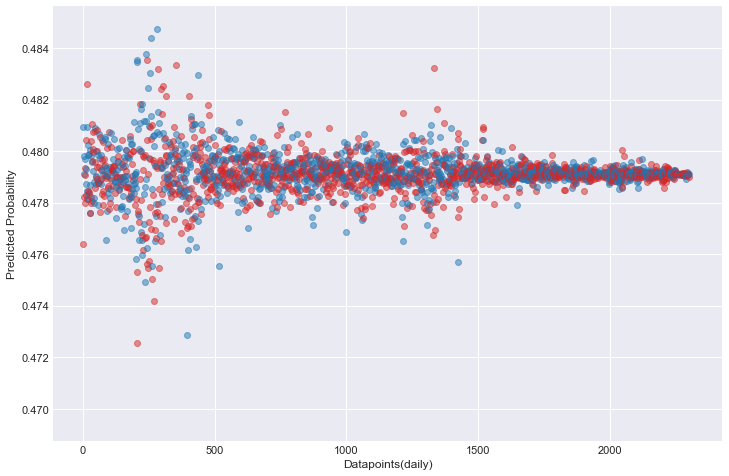

In [93]:
SVM_Transition_Prob(SVMInitialProb,ActReturn)

In [103]:
#Before tuning hyperparams with 01 feature
SVMProbBeforeTune=SVMTuneSample.predict_proba(dfSVMData[SVMfeatureCols])

In [104]:
#Similarly with tunned hyperparams & features where we have an accuracy of 65%
SVMProbAfterEnhHyperParamFeature= SVMModifiedFeature.predict_proba(dfSVMData[SVMModifiedfeatureCols])

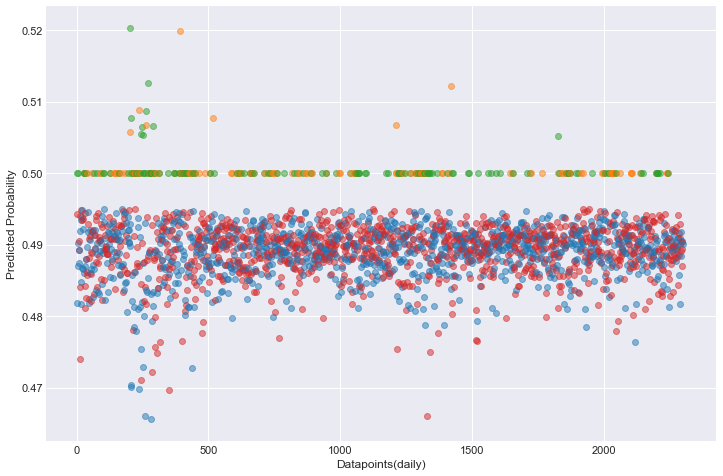

In [105]:
#Plot Before tuning hyperparams
SVM_Transition_Prob(SVMProbBeforeTune,ActReturn)

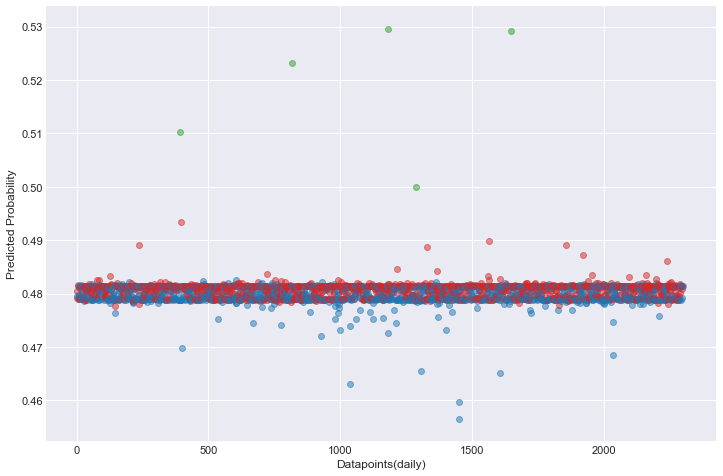

In [106]:
#Plot After tuning hyperparams and modified feature
SVM_Transition_Prob(SVMProbAfterEnhHyperParamFeature,ActReturn)

In [107]:
#UDF to compute Kelly's return = (expected net winnings)/(net winnings if you win)=2p-1
#when the probability of prediction meets a particular threshold
def KellysReturn(dfSVMPred,thresholdP):
    TotalKellyReturn=0
    for i in range(len(ActReturn)):
            excessReturn=0
            #Let's say we have traded only on those days
            #Get excess return (2p-1) and actual returns are positive, our prediction is correct with probability >Threshold
            if(float(dfSVMPred[i][0])>=float(thresholdP) and ActReturn[i]==1):
                TotalKellyReturn=TotalKellyReturn+(2*float(dfSVMPred[i][0])-1.0)
            #Similary on the downside movement as well our prediction was correct and we are on short side till close
            if(float(dfSVMPred[i][1])>=thresholdP and ActReturn[i]==-1):
                TotalKellyReturn=TotalKellyReturn+(2*float(dfSVMPred[i][1])-1.0)
    print("P&L when given threshold at "+str(thresholdP*100)+"% = " + str(TotalKellyReturn) + " times")

In [108]:
ThresholdLimit1=0.75
ThresholdLimit2=0.9
TotalKellyReturn=0

In [109]:
KellysReturn(SVMProbBeforeTune,ThresholdLimit1)
KellysReturn(SVMProbBeforeTune,ThresholdLimit2)

P&L when given threshold at 75.0% = 0 times
P&L when given threshold at 90.0% = 0 times


In [110]:
KellysReturn(SVMProbAfterEnhHyperParamFeature,ThresholdLimit1)
KellysReturn(SVMProbAfterEnhHyperParamFeature,ThresholdLimit2)

P&L when given threshold at 75.0% = 0 times
P&L when given threshold at 90.0% = 0 times


We haven't much achieved in predicting the probabilities of extreme outcomes where thresholds are beaching at least above 75% 
using SVM but post hyperparameters tuning and modified features 
we have increased in predicting actual downward moves as negative and actual upward moves as positive
Classification Report:
                  precision    recall  f1-score   support

        -1.0       0.64      0.61      0.62      1104
         1.0       0.65      0.68      0.67      1196

    accuracy                           0.65      2300
   macro avg       0.64      0.64      0.64      2300
weighted avg       0.64      0.65      0.64      2300

So we conclude quality of both up and down moves are well being done using Support Vector Machines(Accuracy upto 64.52%) 
even though extreme probabilities(>75%) haven't breached

## Observations(SVM): 
         While tuning hyperparams & modifying features especially while running GridSearchCV for Support Vector Machines

Hyperparam 'C'-> Controls the regularization by balancing smooth decision boundary and classifying training points
                 large C value gives you low bias and high variance and viceversa because we penalize the cost of                                missclasification

Hyperparam 'Gamma'-> Used to handle Non-Linear classification for Gaussian Kernel
Hyperparam 'Kernel'-> linear, nonlinear, poly, RBF - radial basis function 

## By using these concepts and by running multiple bacthes I have achieved SVM's  prediction accuracy upto 64.52 %

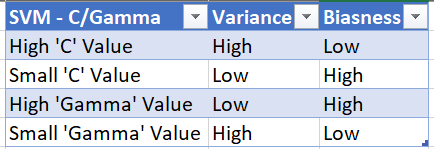

In [55]:
Image('C:/Users/sande/OneDrive/CQF/Project/Final Project - Python/Notes/SVM_HyperParams.PNG')

##### SVM's drawback: One of the major drawback was execution time
                  It took lot of time and multiple runs in order achieve best fit(i.e., upto 64.52%),
                  we can evidence the same in following while we have enabled VERBOSE param in GridSearchCV

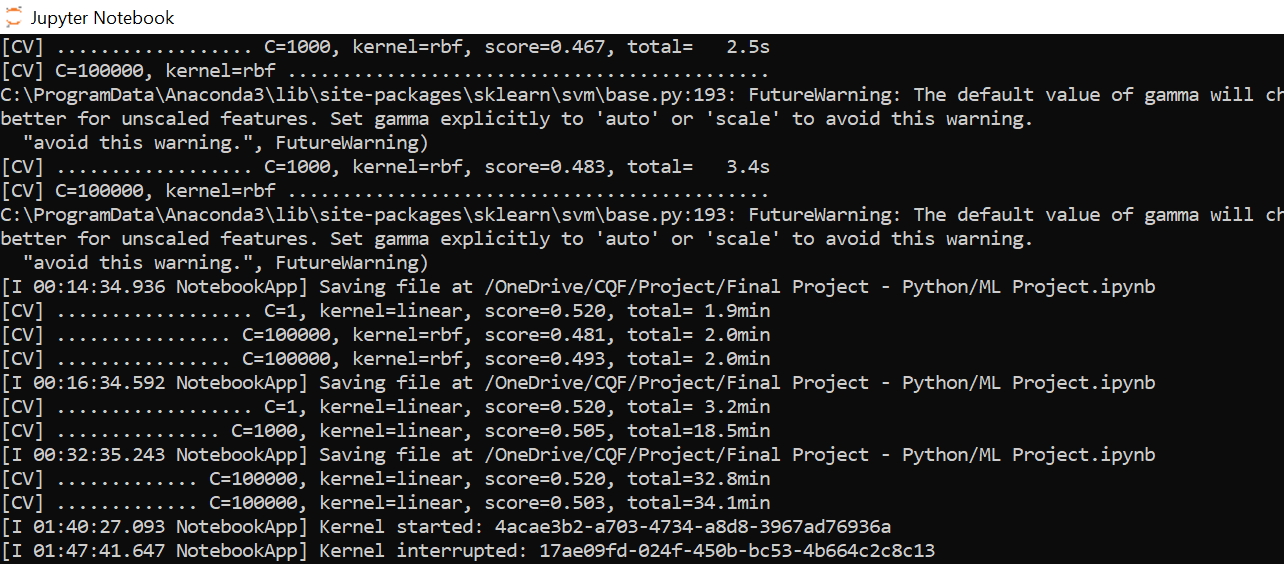

In [54]:
Image('C:/Users/sande/OneDrive/CQF/Project/Final Project - Python/Notes/SVM_Performance.PNG')

# Part II - 4. Artificial Neural Networks

Prediction of stock price(Technical and other indicators) WITHOUT using past return information!

What is ANN?
It is  a computational model based on the structure and functions on neural networks(Just like in humans). 

ANNs have three layers that are interconnected. 
    The first layer consists of input neurons. 
    Those neurons send data on to the second layer, 
    which in turn sends the output neurons to the third layer.
Not limited to 03 it can have multiple intermediate layers as well

Data flows through the network affects the structure of the ANN because a neural network changes/learns 
in a sense based on that input and output.

ANN learn from observing data sets and uses as a random function approximation tool. 
These types of tools help estimate the outcomes most cost-effective and best minimal time consumption 


In [132]:
#Snap Stock data to ANN dataframe variable
dfANNData=pd.DataFrame(dfJPMCdata).copy()
# Identify indexes of ActDailyReturns where return=0
indWithZeroRtn = dfANNData[ dfANNData['ActDailyReturn'] == 0 ].index
# Delete these row indexes from dataFrame
dfANNData.drop(indWithZeroRtn , inplace=True)

In [133]:
dfANNData.tail(5)

Price  ActDailyReturn        Open        High         Low  \
Date                                                                         
2019-12-23  136.324814       -0.000292  137.600006  137.910004  136.880005   
2019-12-24  136.702393        0.002766  137.330002  137.630005  137.059998   
2019-12-26  138.153076        0.010556  137.889999  139.100006  137.779999   
2019-12-27  138.252441        0.000719  139.300003  139.770004  138.669998   
2019-12-30  137.745697       -0.003672  139.899994  140.080002  138.470001   

                 Close     Volume  PrevDayReturn  PrevDayOpen  PrevDayHigh  \
Date                                                                         
2019-12-23  137.199997  9738400.0      -0.000801   138.020004   138.880005   
2019-12-24  137.580002  3324300.0      -0.000292   137.600006   137.910004   
2019-12-26  139.039993  6770900.0       0.002766   137.330002   137.630005   
2019-12-27  139.139999  7868200.0       0.010556   137.889999   139.100006   
2019-12-30  138.630005  6963000.0       0.000719   139.300003   139.770004   

            ...        21MA        50MA       200MA       21EMA       50EMA  \
Date        ...                                                               
2019-12-23  ...  133.214307  128.547346  113.804488  126.878847  112.454661   
2019-12-24  ...  133.558289  128.965859  113.979304  127.158562  112.582211   
2019-12-26  ...  133.879560  129.385764  114.157513  127.476078  112.841527   
2019-12-27  ...  134.236790  129.764929  114.341276  127.780989  113.079764   
2019-12-30  ...  134.590235  130.151647  114.520921  128.093408  113.334766   

                200EMA  Dividends  SplitRatio  DividendYield  ReturnSign  
Date                                                                      
2019-12-23  102.076704        0.0           0            0.0        -1.0  
2019-12-24  102.066593        0.0           0            0.0         1.0  
2019-12-26  102.059966        0.0           0            0.0         1.0  
2019-12-27  102.062586        0.0           0            0.0         1.0  
2019-12-30  102.076876        0.0           0            0.0        -1.0  

[5 rows x 41 columns]

# Using Tensorflow - Deep Neural Network(DNN)

In [37]:
import tensorflow as tf
from pylab import plt
from sklearn.model_selection import train_test_split

#### Features used are Technical, Financial ratios and other indicators other than previous returns

In [135]:
#ANN Features ['PrevDayReturn','Momentum','MA','RSI','StochasticK','MACD','CCI','ATR','CMFV','Volatility','EMA','YangZhangVol']
ANNfeatureCols=['Momentum','RSI','StochasticK','MACD','YangZhangVol','DividendYield']
ANNTarget=['ReturnSign']

In [136]:
#Tenorflow available options are logging all warnings or errors, enabling only ERROR's
tf.logging.set_verbosity(tf.logging.ERROR)

In [137]:
#UDF to get Feature columns and labels
def get_data():
    fc = {'ANNFeatures': tf.real(dfANNData[ANNfeatureCols].values)}
    la = tf.constant(np.where(dfANNData[ANNTarget].values > 0, 1, 0))
    return fc, la

In [138]:
#Creation of ANN's feature columns list
fc = tf.contrib.layers.real_valued_column('ANNFeatures', dimension=len(list(ANNfeatureCols)))

In [139]:
#Deep Neural Network classifier imported from Tensorflow
model = tf.contrib.learn.DNNClassifier(hidden_units=[50, 50],
                                       feature_columns=[fc])

In [140]:
#Listdown all DNNClassifier params
model

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x00000123D7B8C2E8>, 'hidden_units': [50, 50], 'feature_columns': (_RealValuedColumn(column_name='ANNFeatures', dimension=6, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x00000123BB65FA60>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [141]:
#fitting model by setting number of steps to 500
%time model.fit(input_fn=get_data, steps=500)

Wall time: 2.04 s


DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x00000123D7B8C2E8>, 'hidden_units': [50, 50], 'feature_columns': (_RealValuedColumn(column_name='ANNFeatures', dimension=6, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x00000123BB65FA60>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [151]:
print('ANN accuracy for predicting stock price ' + 
      str(round(model.evaluate(input_fn=get_data, steps=5)["accuracy"]*100,2)) + '%')

ANN accuracy for predicting stock price 53.04%


In [144]:
model.evaluate(input_fn=get_data, steps=5)

{'loss': 0.69006866,
 'accuracy': 0.5304348,
 'labels/prediction_mean': 0.51849884,
 'labels/actual_label_mean': 0.52,
 'accuracy/baseline_label_mean': 0.52,
 'auc': 0.5378034,
 'auc_precision_recall': 0.55802023,
 'accuracy/threshold_0.500000_mean': 0.5304348,
 'precision/positive_threshold_0.500000_mean': 0.5286278,
 'recall/positive_threshold_0.500000_mean': 0.8954849,
 'global_step': 500}

In [145]:
dfANNData['ANN_Pred'] = np.where(np.array(list(model.predict(input_fn=get_data))) > 0,
                              1, -1)

In [146]:
dfANNData.tail(5)

Price  ActDailyReturn        Open        High         Low  \
Date                                                                         
2019-12-23  136.324814       -0.000292  137.600006  137.910004  136.880005   
2019-12-24  136.702393        0.002766  137.330002  137.630005  137.059998   
2019-12-26  138.153076        0.010556  137.889999  139.100006  137.779999   
2019-12-27  138.252441        0.000719  139.300003  139.770004  138.669998   
2019-12-30  137.745697       -0.003672  139.899994  140.080002  138.470001   

                 Close     Volume  PrevDayReturn  PrevDayOpen  PrevDayHigh  \
Date                                                                         
2019-12-23  137.199997  9738400.0      -0.000801   138.020004   138.880005   
2019-12-24  137.580002  3324300.0      -0.000292   137.600006   137.910004   
2019-12-26  139.039993  6770900.0       0.002766   137.330002   137.630005   
2019-12-27  139.139999  7868200.0       0.010556   137.889999   139.100006   
2019-12-30  138.630005  6963000.0       0.000719   139.300003   139.770004   

            ...        50MA       200MA       21EMA       50EMA      200EMA  \
Date        ...                                                               
2019-12-23  ...  128.547346  113.804488  126.878847  112.454661  102.076704   
2019-12-24  ...  128.965859  113.979304  127.158562  112.582211  102.066593   
2019-12-26  ...  129.385764  114.157513  127.476078  112.841527  102.059966   
2019-12-27  ...  129.764929  114.341276  127.780989  113.079764  102.062586   
2019-12-30  ...  130.151647  114.520921  128.093408  113.334766  102.076876   

            Dividends  SplitRatio  DividendYield  ReturnSign  ANN_Pred  
Date                                                                    
2019-12-23        0.0           0            0.0        -1.0         1  
2019-12-24        0.0           0            0.0         1.0         1  
2019-12-26        0.0           0            0.0         1.0         1  
2019-12-27        0.0           0            0.0         1.0         1  
2019-12-30        0.0           0            0.0        -1.0         1  

[5 rows x 42 columns]

In [147]:
dfANNData['ANN_Pred_return'] = dfANNData['ActDailyReturn'] * dfANNData['ANN_Pred']

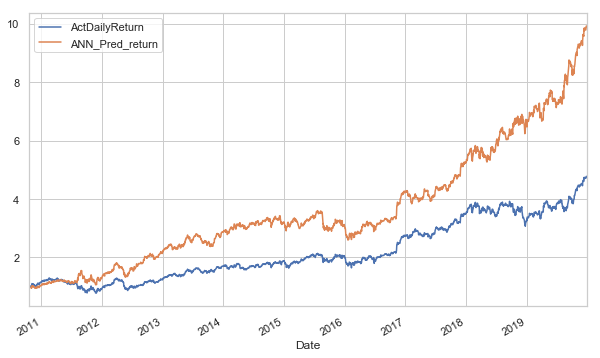

In [152]:
#Plotting Actual returns vs ANN by considering Technical, Financial ratios and other indicators(apart from Previoud returns)
dfANNData[['ActDailyReturn', 'ANN_Pred_return']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [153]:
dfANNData.head(5)

Price  ActDailyReturn       Open       High        Low  \
Date                                                                     
2010-10-18  29.783682        0.027872  37.150002  38.259998  37.009998   
2010-10-19  29.386057       -0.013440  37.900002  38.650002  37.500000   
2010-10-20  29.705730        0.010820  38.000000  38.299999  37.459999   
2010-10-21  29.393862       -0.010554  38.189999  38.400002  36.209999   
2010-10-25  28.902645       -0.016853  37.970001  38.070000  37.000000   

                Close      Volume  PrevDayReturn  PrevDayOpen  PrevDayHigh  \
Date                                                                         
2010-10-18  38.200001  55058700.0      -0.041393    38.869999    38.939999   
2010-10-19  37.689999  70595100.0       0.027872    37.150002    38.259998   
2010-10-20  38.099998  43497200.0      -0.013440    37.900002    38.650002   
2010-10-21  37.700001  38250300.0       0.010820    38.000000    38.299999   
2010-10-25  37.070000  37893500.0       0.000000    37.500000    37.790001   

            ...      200MA      21EMA      50EMA     200EMA  Dividends  \
Date        ...                                                          
2010-10-18  ...  31.570893  30.511467  30.967187  32.327969        0.0   
2010-10-19  ...  31.558172  30.653473  30.968743  32.808051        0.0   
2010-10-20  ...  31.538685  30.740099  30.950345  33.185122        0.0   
2010-10-21  ...  31.517574  30.772837  30.889831  33.420954        0.0   
2010-10-25  ...  31.466989  30.762147  30.768772  33.871938        0.0   

            SplitRatio  DividendYield  ReturnSign  ANN_Pred  ANN_Pred_return  
Date                                                                          
2010-10-18           0            0.0         1.0         1         0.027872  
2010-10-19           0            0.0        -1.0         1        -0.013440  
2010-10-20           0            0.0         1.0        -1        -0.010820  
2010-10-21           0            0.0        -1.0         1        -0.010554  
2010-10-25           0            0.0        -1.0         1        -0.016853  

[5 rows x 43 columns]

## Deep Learning Models using Keras

In [50]:
#Snap Stock data to ANN dataframe variable
dfANNData=pd.DataFrame(dfJPMCdata).copy()
# Identify indexes of ActDailyReturns where return=0
indWithZeroRtn = dfANNData[ dfANNData['ActDailyReturn'] == 0 ].index
# Delete these row indexes from dataFrame
dfANNData.drop(indWithZeroRtn , inplace=True)

In [51]:
# Use scikit-learn to grid search the batch size and epochs
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split

In [52]:
# UDF to create model, required for Keras Classifier
def create_model(optimizer='adam'):
# create model
    KerasSeqModel = Sequential()
    KerasSeqModel.add(Dense(12, input_dim=len(KerasfeatureCols), activation='relu'))
    KerasSeqModel.add(Dense(1, activation='sigmoid'))
    # Compile model
    KerasSeqModel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return KerasSeqModel

In [35]:
#Tenorflow available options are logging all warnings or errors, enabling only ERROR's
tf.logging.set_verbosity(tf.logging.ERROR)

In [53]:
#Feature columns & prediction param/target
KerasfeatureCols=['StochasticK','Momentum','YangZhangVol']
KerasTarget=['ReturnSign']

In [54]:
#Sampling the data to Train/Test
X_Train, X_Test, Y_Train, Y_Test  =model_selection.train_test_split(
    dfANNData[KerasfeatureCols], dfANNData[KerasTarget], test_size=0.5, shuffle=True)

##### Optimizing Keras classifier using GridSearchCV

In [55]:
# Keras Sequential model
KerasSeqModel = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search optimization params
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=KerasSeqModel, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_Train, Y_Train)
# get results of the best fit
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.515652 using {'optimizer': 'Nadam'}
0.511304 (0.002692) with: {'optimizer': 'SGD'}
0.500870 (0.018154) with: {'optimizer': 'RMSprop'}
0.486087 (0.021161) with: {'optimizer': 'Adagrad'}
0.511304 (0.010243) with: {'optimizer': 'Adadelta'}
0.493913 (0.016171) with: {'optimizer': 'Adam'}
0.506087 (0.004808) with: {'optimizer': 'Adamax'}
0.515652 (0.011133) with: {'optimizer': 'Nadam'}


In [56]:
#Rebuilding Model as per best optimization
OptimizedModel = Sequential()
OptimizedModel.add(Dense(4, input_dim=len(KerasfeatureCols), activation='relu'))
OptimizedModel.add(Dense(4, activation='relu'))
OptimizedModel.add(Dense(1, activation='sigmoid'))
#passing optimizer type from above gridResult
OptimizedModel.compile(loss='binary_crossentropy', optimizer=grid_result.best_params_['optimizer'])
model_history= OptimizedModel.fit(X_Train, Y_Train, epochs=500, verbose=0)

In [68]:
OptimizedModel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 4)                 16        
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 5         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [69]:
#returns a list of all weight tensors in the model
OptimizedModel.get_weights()

[array([[-0.7334531 , -2.8758628 ,  0.15052474, -0.90383667],
        [-0.5728581 , -1.7784741 , -0.4013664 ,  0.79662704],
        [-1.6521124 ,  2.909515  ,  2.5815883 , -0.39380723]],
       dtype=float32),
 array([ 1.2084075, -0.8713807, -1.2029063,  0.       ], dtype=float32),
 array([[ 0.18606375, -0.23167138,  3.1774216 , -0.14091203],
        [ 0.04769783,  5.085268  , -1.4071895 ,  5.8770156 ],
        [ 0.34729964,  0.43177545,  0.3408547 ,  0.36434132],
        [ 0.83569854, -0.5229929 , -0.5520675 ,  0.78339595]],
       dtype=float32),
 array([-1.2120076 ,  0.43785593, -1.1799682 ,  0.46571508], dtype=float32),
 array([[ 0.5186866],
        [-0.7258565],
        [ 1.3177696],
        [-1.0344354]], dtype=float32),
 array([-0.5259566], dtype=float32)]

In [70]:
#Probabilities of prediction on Test dataset
ANNPred_Prob=OptimizedModel.predict_proba(X_Test)
#Actual Returns on test data sample
ActReturn=Y_Test.to_numpy()

## Keras Classifier  - Transition Probabilities

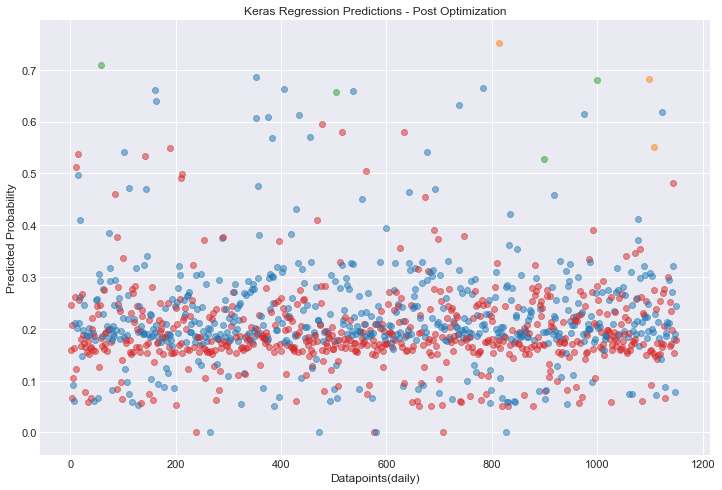

In [71]:
#Plotting the prediction probabilities using Keras model(Test dataset) vs Actual returns
fig, ax = plt.subplots()
color=['tab:orange', 'tab:red','tab:blue', 'tab:green']
iColor=''
for i in range(len(ActReturn)):
    if(ANNPred_Prob[i][0]>=0.5 and ActReturn[i]==1):
        x=i+1 
        y=ANNPred_Prob[i][0]
        iColor=color[3]
    if(ANNPred_Prob[i][0]<0.5 and ActReturn[i]==-1):
        x=i+1 
        y=1* ANNPred_Prob[i][0]
        iColor=color[2]
    if(ANNPred_Prob[i][0]<0.5 and ActReturn[i]==1):
        x=i+1 
        y=1 * ANNPred_Prob[i][0]
        iColor=color[1]
    if(ANNPred_Prob[i][0]>=0.5 and ActReturn[i]==-1):
        x= i+1 
        y= 1 * ANNPred_Prob[i][0]
        iColor=color[0]
    ax.scatter(x, y, c=iColor, linewidth=1, alpha=0.5, label=iColor)
ax.grid(True)
ax.set_title('Keras Regression Predictions - Post Optimization')
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('seaborn-darkgrid')
plt.xlabel("Datapoints(daily)")
plt.ylabel("Predicted Probability")
plt.show()

## Long short-term memory (LSTM)  - Artificial recurrent neural network (RNN) 

In [27]:
#Snap Stock data to ANN dataframe variable
dfLSTMData=pd.DataFrame(dfJPMCdata).copy()
# Identify indexes of ActDailyReturns where return=0
indWithZeroRtn = dfLSTMData[ dfLSTMData['ActDailyReturn'] == 0 ].index
# Delete these row indexes from dataFrame
dfLSTMData.drop(indWithZeroRtn , inplace=True)

In [28]:
import tensorflow as tf
from pylab import plt
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
from sklearn.metrics import accuracy_score
import time 

In [29]:
LSTMfeatureCols=['MACD']
LSTMTarget=['ReturnSign']

In [36]:
#Tenorflow disabling all warnings and enable only ERROR's
tf.logging.set_verbosity(tf.logging.ERROR)

In [30]:
#Sampling the data to Train/Test
X_Train, X_Test, Y_Train, Y_Test  =model_selection.train_test_split(
    dfLSTMData[LSTMfeatureCols], dfLSTMData[LSTMTarget], test_size=0.5, shuffle=True)

In [31]:
#UDF to create timeStep features data for n step look back period
def CreateTimeStepXArray(dfArray, n):
    X = []
    for i in range(len(dfArray)-n-1):
        a = dfArray[i:(i+n), 0]
        X.append(a)
    return np.array(X)

In [32]:
# Create timestep Array's x,y from dataframe X,Y 
timeStep = 30
x_Train = CreateTimeStepXArray(X_Train.to_numpy(), timeStep)
y_Train = Y_Train.to_numpy()
y_Train = np.resize(y_Train,len(y_Train)-timeStep-1)
x_Test = CreateTimeStepXArray(Y_Train.to_numpy(), timeStep)
y_Test = Y_Test.to_numpy()
y_Test = np.resize(y_Test,len(y_Test)-timeStep-1)

In [33]:
#Reshaping the size to accommodate look back data set for chosen timeStep
x_Train = np.reshape(x_Train, (x_Train.shape[0], len(LSTMfeatureCols), x_Train.shape[1]))
x_Test = np.reshape(x_Test, (x_Test.shape[0], len(LSTMfeatureCols), x_Test.shape[1]))

In [37]:
# Creation of LSTM Classifier with optimizer='adam' & look back period of 30 days
timestep=30
LSTMmodel = Sequential()
LSTMmodel.add(LSTM(50, input_shape=(1, timestep)))
LSTMmodel.add(Dropout(0.5))
LSTMmodel.add(Dense(1, input_dim=len(LSTMfeatureCols), activation='relu'))
LSTMmodel.compile(loss='mse', optimizer='adam')

In [39]:
#keras.callbacks.callbacks.History
LSTMModelHistory=LSTMmodel.fit(x_Train, y_Train, epochs=1000, batch_size=30, verbose=0)

In [40]:
#Convert the population dataset into timestep dataset
x_PopulationLSTM = CreateTimeStepXArray(dfLSTMData[LSTMfeatureCols].to_numpy(), timeStep)

In [41]:
#Creating a scaler to normalize the values between -1 to 1 range
scaler = MinMaxScaler(feature_range=(-1, 1))

In [42]:
#Normalize the LSTM feature column from population data
x_PopulationLSTM = scaler.fit_transform(x_PopulationLSTM)
x_PopulationLSTM = np.reshape(x_PopulationLSTM, (x_PopulationLSTM.shape[0], len(LSTMfeatureCols), x_PopulationLSTM.shape[1]))

In [43]:
#Shift the initial data with chosen timeStep
dfLSTMData=dfLSTMData[timeStep+1:]

In [44]:
dfLSTMData.shape,x_PopulationLSTM.shape

((2269, 41), (2269, 1, 30))

In [45]:
#Compute the predictions for population feature using keras LSTM classifer model
dfLSTMData['LSTM_pred'] = np.where(LSTMmodel.predict(x_PopulationLSTM)>0,1,-1)
dfLSTMData['LSTM_pred_return'] = dfLSTMData['ActDailyReturn'] * dfLSTMData['LSTM_pred']

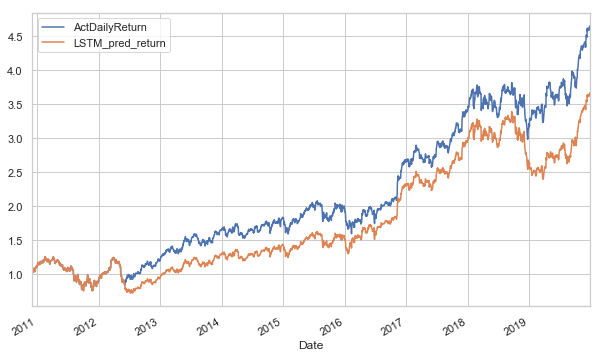

In [46]:
#plot the LSTM vs Actual returns
dfLSTMData[['ActDailyReturn', 'LSTM_pred_return']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [47]:
#Prediction acuuracy
LSTM_Accuracy=accuracy_score(dfLSTMData['ReturnSign'], dfLSTMData['LSTM_pred'] )  

In [48]:
print('Long short-term memory accuracy for predicting stock price ' + str(round(LSTM_Accuracy*100,2)) + '%')

Long short-term memory accuracy for predicting stock price 51.92%


In [50]:
#populating array objects for plotting prection probabilities vs actual returns
ActReturn=dfLSTMData["ReturnSign"].to_numpy()
LSTM_Predict_Prob=LSTMmodel.predict(x_PopulationLSTM)

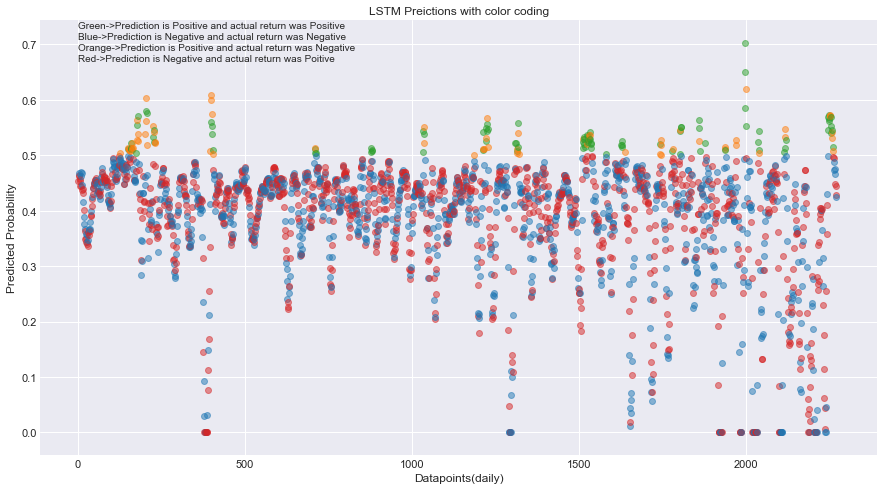

In [52]:
#Scatter plot:
fig, ax = plt.subplots()
color=['tab:orange', 'tab:red','tab:blue', 'tab:green']
iColor=''
for i in range(len(ActReturn)):
    if(LSTM_Predict_Prob[i]>=0.5 and ActReturn[i]==1):
        x=i+1 
        y=LSTM_Predict_Prob[i]
        iColor=color[3]
    if(LSTM_Predict_Prob[i]<0.5 and ActReturn[i]==-1):
        x=i+1
        y=1* LSTM_Predict_Prob[i]
        iColor=color[2]
    if(LSTM_Predict_Prob[i]<0.5 and ActReturn[i]==1):
        x=i+1
        y=1 * LSTM_Predict_Prob[i]
        iColor=color[1]
    if(LSTM_Predict_Prob[i]>=0.5 and ActReturn[i]==-1):
        x= i+1
        y= 1 * LSTM_Predict_Prob[i]
        iColor=color[0]
    ax.scatter(x, y, c=iColor, linewidth=1, alpha=0.5, label=iColor)
ax.grid(True)
plt.rcParams['figure.figsize'] = [15, 8]
ax.set_title('LSTM Preictions with color coding')
plt.text(1,0.73,'Green->Prediction is Positive and actual return was Positive')
plt.text(1,0.71,'Blue->Prediction is Negative and actual return was Negative')
plt.text(1,0.69,'Orange->Prediction is Positive and actual return was Negative')
plt.text(1,0.67,'Red->Prediction is Negative and actual return was Poitive')
plt.style.use('seaborn-darkgrid')
plt.xlabel("Datapoints(daily)")
plt.ylabel("Predicted Probability")
plt.show()

#### Observations:
Using technical/other indicators without daily lagged returns ANN techniques are best to predict the outcome in very less time 

# Conclusion(on all Machine Learning Models):
    1. Logistic regression is a good starting point for prediction and flexible/easy/fast to train and tune.
    2. SVM's are fairly good in terms of accuracy achieved upto 64.52% (For JPMC 10yrs data) but takes fair amount of time to tune hyperparams with modified features(took couple of hours for me to arrive at this accuracy and to post multiple runs/combinations). It's effective in high dimensional features(E.g., 3D plots represents how the segregation happened by hyperplane w.r.t 03 features.)
    3. ANN's are black box and difficult to interpret and fairly good in terms of accuracy especially while we rely on technical/other idicators apart from daily returns, even it is bit time consuming but not as worst as SVM to tune the params.
    4. Decision trees are easy to interpret and understandable and makes minimal assumptions,requires less preparation and performed well with chosen large dataset(10years data) to see/identify primary feature splits 
    

# Multinomial Prediction 

A. Chosen past volatilities as an estimator
B. Identified Class labels Market sentiment =
            std dev move >=+0.7->Very Bullish
            std dev move <=-0.7->Very Bearish
            std dev between [0.5,0.7)-> Bullish
            std dev between (-0.7,-0.5]-> Bearish
            for rest/std dev between (-0.5,0.5) -> Neutral
C. Selected stock GOOGLE where I have observed best distinct counts for each class as per std move thresholds
Google stock's actual market sentiments based on daily std move for range [2009-10-16 to 2019-12-31]         
             [['Bearish' 125]
             ['Bullish' 129]
             ['Neutral' 1098]
             ['VeryBearish' 602]
             ['VeryBullish' 615]]
for total Trading days=[2569]

###### For other stocks like Apple where most of the std moves are very less[with in (-0.5,0.5)] i.e., 
actual Market sentiments are neutral(2349/2569)
with this stock I can able to Achieve high prediction accuracy of 91.15%(as most most of them are NEUTRAL)
but doesn't suffice for proper prediction analysis and Hence I chosen Google where we can see lot of dispersion

### Data collation and creation of technical indicators/moving averages/other features

In [78]:
yf.pdr_override()
# download 10 years of Google stock(one of the most volatile in US for the past 5-10yrs) price data
dfGOOGLData = pdr.get_data_yahoo("GOOGL", start="2009-01-01", end="2019-12-31")
# Day (t*) - used for later 
t=1

In [79]:
# Removing unwanted columns and creation of new field price of the day "Price" from "Adj Close"
dfGOOGLData=dfGOOGLData.rename(columns={"Adj Close":"Price"})
dfGOOGLData['ActDailyReturn'] = np.log(dfGOOGLData['Price'] / dfGOOGLData['Price'].shift(1))
dfGOOGLData = dfGOOGLData.reindex(columns=['Price','ActDailyReturn','Open','High','Low','Close','Volume'])
# Lagged log return as a Feature
dfGOOGLData['PrevDayReturn'] = dfGOOGLData['ActDailyReturn'].shift(1) 
dfGOOGLData.tail(5)

Price  ActDailyReturn         Open         High  \
Date                                                                
2019-12-24  1344.430054       -0.004601  1350.209961  1352.010010   
2019-12-26  1362.469971        0.013329  1346.550049  1363.199951   
2019-12-27  1354.640015       -0.005763  1364.000000  1367.050049   
2019-12-30  1339.709961       -0.011083  1356.810059  1357.000000   
2019-12-31  1339.390015       -0.000239  1335.790039  1340.660034   

                    Low        Close     Volume  PrevDayReturn  
Date                                                            
2019-12-24  1344.170044  1344.430054   673400.0      -0.000437  
2019-12-26  1345.510010  1362.469971  1183100.0      -0.004601  
2019-12-27  1353.000000  1354.640015  1160600.0       0.013329  
2019-12-30  1337.839966  1339.709961   999700.0      -0.005763  
2019-12-31  1332.130005  1339.390015   975700.0      -0.011083

In [80]:
### Past moving averages of the price, simple or exponentially weighted (decaying in time).
# Used Day (t*=1) .shift(t) to populate previous days computed values to respective day's row
#i.e., data available before market opens, to predict today's outcome
dfGOOGLData['PrevDayOpen']=dfGOOGLData['Open'].shift(t)
dfGOOGLData['PrevDayHigh']=dfGOOGLData['High'].shift(t)
dfGOOGLData['PrevDayLow']=dfGOOGLData['Low'].shift(t)
dfGOOGLData['PrevDayClose']=dfGOOGLData['Close'].shift(t)
#[Typical Price] = Average Previous High Low Close,later used to compute CCI - Technical Indicator
dfGOOGLData['PrevTypicalPrice']=(dfGOOGLData['High'].shift(t)+dfGOOGLData['Low'].shift(t)+dfGOOGLData['Close'].shift(t))/3
dfGOOGLData['Momentum']=dfGOOGLData['Price'].shift(t) - dfGOOGLData['Price'].shift(t+1)
dfGOOGLData['MA']=dfGOOGLData['Price'].shift(t).rolling(14).mean() ##Taken 14 day Moving Average
#Technical Indicators, such as RSI, Stochastic K, MACD, CCI, ATR, Accumulation/Distribution)
dfGOOGLData['RSI'] = Calc14RSI(dfGOOGLData['Price'].shift(t)) ##Taken 14 day period to compute RSI
dfGOOGLData['StochasticK'] = 100*((dfGOOGLData['PrevDayClose'] - dfGOOGLData['PrevDayLow'].rolling(14).min())
                            / (dfGOOGLData['PrevDayHigh'].rolling(14).max() - dfGOOGLData['PrevDayLow'].rolling(14).min()))
#MACD=ShortTerm EMA(n=12) - LongTerm EMA(n=26)
dfGOOGLData['MACD'] = dfGOOGLData['Price'].shift(t).ewm(span=12,adjust=True).mean()-dfGOOGLData['Price'].shift(t).ewm(span=26,adjust=True).mean() 
#CCI=(Typical Price-MA)/(0.15*MD), Typical Price= ∑ [(High+Low+Close)/3], considered 20 day period
dfGOOGLData['CCI'] = (dfGOOGLData['PrevTypicalPrice'] - dfGOOGLData['PrevTypicalPrice'].rolling(20).mean())/(.015*dfGOOGLData['PrevTypicalPrice'].rolling(20).std())
#ATR=∑(TR(i)/n) where TR = [Max(High,PrevClose) - Min(Low,PrevClose)], considered 14 day period
dfGOOGLData['TR'] = dfGOOGLData[['High','PrevDayClose']].shift(t).max(axis=1)-dfGOOGLData[['Low','PrevDayClose']].shift(t).min(axis=1)
dfGOOGLData['ATR']=dfGOOGLData['TR'].rolling(14).mean()
#ADI=Accumulation/Distribution (A/D)=Prev [A/D] + Current money flow volume(CMFV)=[(Close-Low)-(High-Close)]* Volume/(High-Low)
dfGOOGLData['CMFV']=((dfGOOGLData['Close'].shift(t)-dfGOOGLData['Low'].shift(t))-(dfGOOGLData['High'].shift(t)-dfGOOGLData['Close'].shift(t)))*dfGOOGLData['Volume'].shift(t)/(dfGOOGLData['High'].shift(t)-dfGOOGLData['Low'].shift(t))
dfGOOGLData['ADI']=dfGOOGLData['CMFV'].shift(t).fillna(0)+dfGOOGLData['CMFV']
dfGOOGLData['ADI(in 1000s)']=dfGOOGLData['ADI']/1000 #For more readability expressed in multiples of 1000's

In [81]:
#Considered 14 days sample
dfGOOGLData['EMA']=dfGOOGLData['Price'].shift(t).ewm(span=14,adjust=True).mean()  ##alpha=2/(N+1),EWMA as applied to variance 
##Yang Zhang volatility depends on High, Low, Open, and Close Price
dfGOOGLData['YangZhangVol']=CalcYangZhangVol(dfGOOGLData,14,252)
dfGOOGLData['5DMomentum']=dfGOOGLData['Price'].shift(t) - dfGOOGLData['Price'].shift(t+5)
dfGOOGLData['10DMomentum']=dfGOOGLData['Price'].shift(t) - dfGOOGLData['Price'].shift(t+10)
dfGOOGLData['21DMomentum']=dfGOOGLData['Price'].shift(t) - dfGOOGLData['Price'].shift(t+21)
dfGOOGLData['50DMomentum']=dfGOOGLData['Price'].shift(t) - dfGOOGLData['Price'].shift(t+50)
dfGOOGLData['21MA']=dfGOOGLData['Price'].shift(t).rolling(21).mean() 
dfGOOGLData['50MA']=dfGOOGLData['Price'].shift(t).rolling(50).mean() 
dfGOOGLData['200MA']=dfGOOGLData['Price'].shift(t).rolling(200).mean() 
dfGOOGLData['21EMA']=dfGOOGLData['Price'].shift(21).ewm(span=21,adjust=True).mean() 
dfGOOGLData['50EMA']=dfGOOGLData['Price'].shift(50).ewm(span=50,adjust=True).mean() 
dfGOOGLData['200EMA']=dfGOOGLData['Price'].shift(200).ewm(span=200,adjust=True).mean() 
##Stock price movement either positive or negative based on actual daily return
dfGOOGLData['ReturnSign'] = np.sign(dfGOOGLData['ActDailyReturn'].values)

#### For Multinomial Prediction we are using past volatilities to categorize the actual market sentiments/class as per std moves

In [82]:
#Previous day's volatility = Sigma(t-1) and Sigma(t) =  14 days sample
dfGOOGLData['Volatility']=dfGOOGLData['Price'].shift(t).rolling(14).std() ## Sample square root of naive sample variance
#Prior2DStdMove = (Sigma(t-1)-Sigma(t-2))
dfGOOGLData['Prior2DStdMove'] = dfGOOGLData['Volatility'] - dfGOOGLData['Volatility'].shift(t)

###### Class labels - Market sentiment = 
                std dev move >=+0.7->Very Bullish
                std dev move <=-0.7->Very Bearish
                std dev between [0.5,0.7)-> Bullish
                std dev between (-0.7,-0.5]-> Bearish
                for rest/std dev between (-0.5,0.5) -> Neutral

In [83]:
#Labelling as per prior 2 days std move
dfGOOGLData['MarketSentiment']=np.where(dfGOOGLData['Prior2DStdMove'] >= 0.7,'VeryBullish',
                                        np.where(dfGOOGLData['Prior2DStdMove'] <= -0.7,'VeryBearish',
                                                 np.where(dfGOOGLData['Prior2DStdMove'] >= 0.5 ,'Bullish',
                                                          np.where(dfGOOGLData['Prior2DStdMove'] <= -0.5,'Bearish','Neutral'))))

In [84]:
#Data Cleansing by removing NULL values
dfGOOGLData.dropna(inplace=True)

In [85]:
#Sample output to see MarketSentiment column has been updated with correct class label
np.hstack((np.array(dfGOOGLData[['Price','Prior2DStdMove','MarketSentiment']].head(3)),
np.array(dfGOOGLData[['Price','Prior2DStdMove','MarketSentiment']].tail(3))))

array([[275.2001953125, 0.3710509093188552, 'Neutral',
        1354.6400146484375, -1.3736730630352678, 'VeryBearish'],
       [276.3213195800781, 1.5035208685937675, 'VeryBullish',
        1339.7099609375, -0.5911400009262655, 'Bearish'],
       [276.1361389160156, 1.119336024933082, 'VeryBullish',
        1339.3900146484375, 0.364167167870904, 'Neutral']], dtype=object)

In [86]:
ClassLabels, iCount = np.unique(np.array(dfGOOGLData[['MarketSentiment']]), return_counts=True)
print('Class labels, Count')
print(np.asarray((ClassLabels, iCount)).T)
print('Total trading days '+ str(len(dfGOOGLData)))

Class labels, Count
[['Bearish' 125]
 ['Bullish' 129]
 ['Neutral' 1098]
 ['VeryBearish' 602]
 ['VeryBullish' 615]]
Total trading days 2569


# Multinomial Prediction using Logistic regression

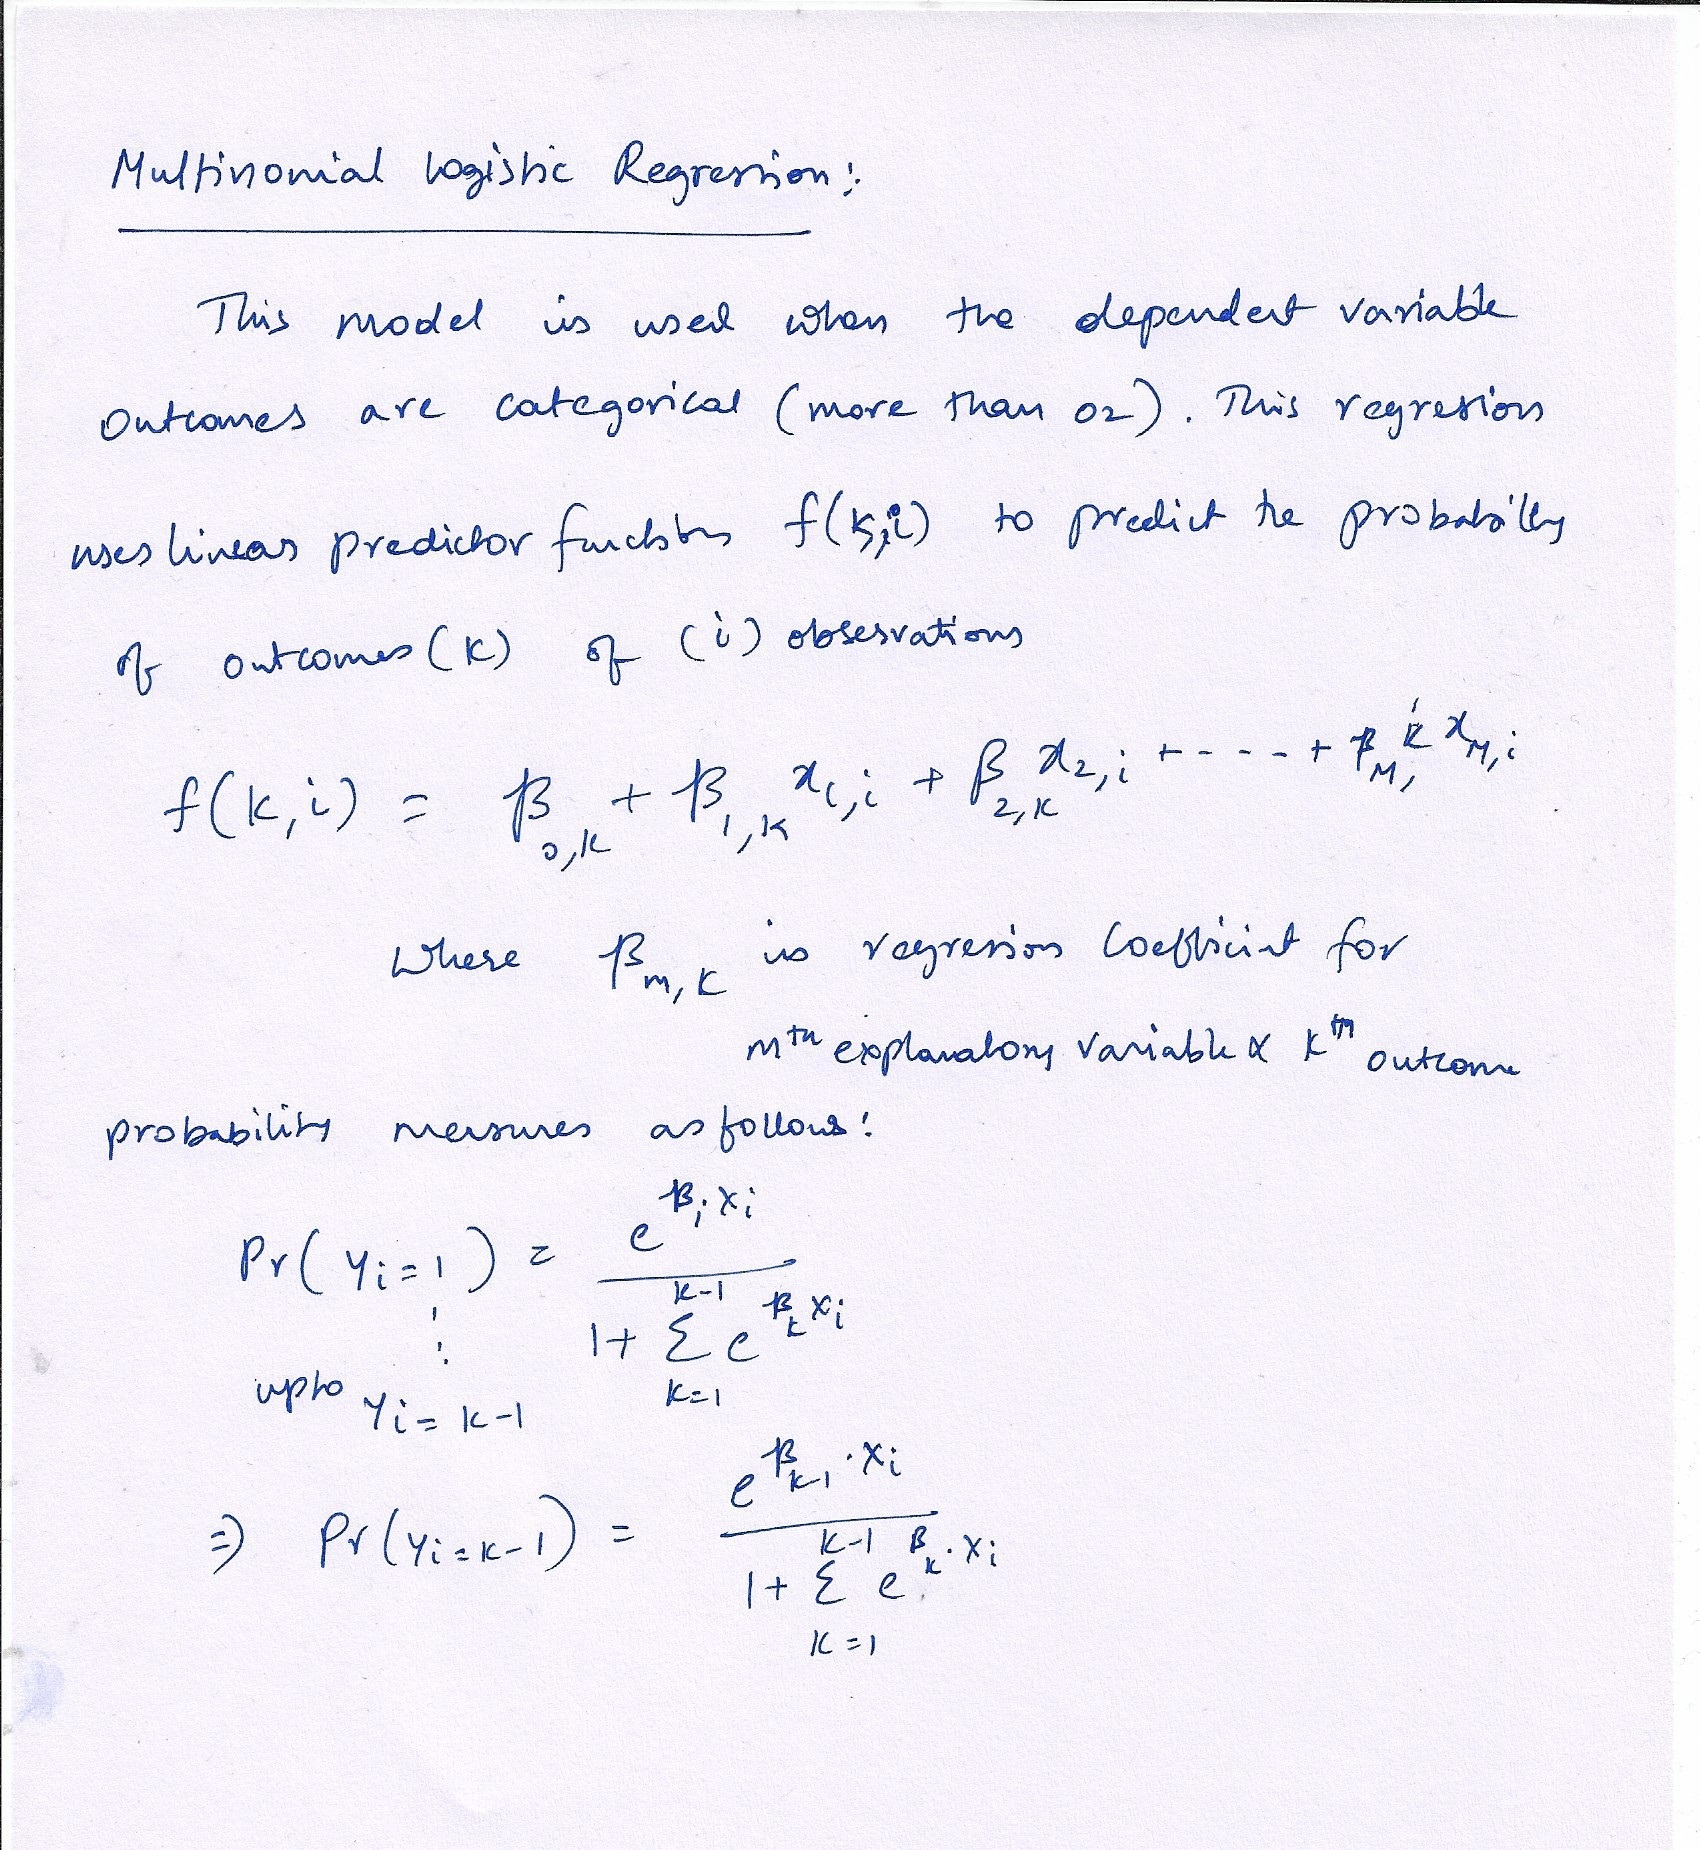

In [679]:
Image('MultinomialShortWriteUp.JPG', width=500, height=900)

In [87]:
dfMultinomialData=pd.DataFrame(dfGOOGLData).copy()

In [88]:
MultinomialfeatureCols=['PrevDayReturn','PrevDayHigh','PrevDayLow',
                        'Momentum','5DMomentum','MA','YangZhangVol',
                        'MACD', 'CCI','ATR']
MultinomialTarget=['MarketSentiment']

In [89]:
#train the model with training data
# solvers 'newton-cg', 'sag', 'lbfgs' 
MultinomialLogis = linear_model.LogisticRegression(C=1e6,multi_class='multinomial',solver ='newton-cg')

In [90]:
MultinomialLogis.fit(dfMultinomialData[MultinomialfeatureCols],dfMultinomialData[MultinomialTarget])

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

In [91]:
Accuracy_Multinomial=MultinomialLogis.score(dfMultinomialData[MultinomialfeatureCols],dfMultinomialData[MultinomialTarget])

In [92]:
#Assigning predicted Market Sentiments to Column 'Predicted_ClassLabel'
dfMultinomialData['Predicted_ClassLabel'] = MultinomialLogis.predict(dfMultinomialData[MultinomialfeatureCols])

In [98]:
#Get random samples 05 of actual Market Sentiment vs Prediction
dfMultinomialData[['Price','Prior2DStdMove','MarketSentiment','Predicted_ClassLabel']].sample(n=5)

Price  Prior2DStdMove MarketSentiment Predicted_ClassLabel
Date                                                                        
2013-03-21   406.036041       -0.666817         Bearish              Neutral
2014-07-08   578.400024       -1.149706     VeryBearish              Neutral
2019-10-22  1241.199951        1.098036     VeryBullish          VeryBullish
2016-08-17   805.419983       -3.995802     VeryBearish              Neutral
2014-05-06   522.570007       -0.110435         Neutral              Neutral

## Multinomial Prediction accuracy of Market Sentiment based on Std Move

In [99]:
print('Multinomial Prediction using logistic regression accuracy for predicting market sentiment ' 
      + str(round(Accuracy_Multinomial*100,2)) + '%')

Multinomial Prediction using logistic regression accuracy for predicting market sentiment 50.45%


In [105]:
#Intercept & Beta coefficients
print("Intercept: ")
print(MultinomialLogis.intercept_)
print("")
print("Coefficients: {}".format(MultinomialLogis.coef_)) 

Intercept: 
[-0.26914142 -0.36913708  2.33064544 -0.44720758 -1.24515936]

Coefficients: [[ 1.91077215e+01 -5.38965595e-02  5.71998163e-02 -3.48977474e-02
   4.53102325e-03 -3.72662196e-03 -2.03466900e+00  9.03287200e-03
  -4.27835405e-03  4.81500768e-02]
 [-7.37417309e+00  1.17946876e-02 -2.03190917e-02  9.48629161e-03
   6.27260669e-03  6.95183233e-03 -1.31769696e+00  1.12219151e-02
   9.63592234e-04  4.05360194e-02]
 [-5.70996403e-01 -2.49133481e-03 -1.71136801e-04  5.96701988e-03
  -1.33204643e-03  2.05736945e-03 -2.46712734e+00 -1.05216301e-02
   6.76671045e-05 -1.77636256e-02]
 [-1.05868230e-01 -2.46286638e-02  2.40867679e-02  1.29274534e-03
  -6.58202753e-03  9.52675004e-04  1.62593844e+00  1.10069623e-02
   8.94437471e-04  4.38903350e-02]
 [-1.10566838e+01  6.92218716e-02 -6.07963553e-02  1.81516906e-02
  -2.88955596e-03 -6.23525588e-03  4.19355486e+00 -2.07401193e-02
   2.35265718e-03 -1.14812806e-01]]


In [106]:
#Splits our data into random train and test subsets with shuffling
X_Train, X_Test, Y_Train, Y_Test = model_selection.train_test_split(
    dfMultinomialData[MultinomialfeatureCols],dfMultinomialData[MultinomialTarget], test_size=0.5, shuffle=True)

In [107]:
#Running the logistic regression with 50% shuffled sample
MultiLogisShuffleSample = linear_model.LogisticRegression(C=1e6,multi_class='multinomial',solver ='newton-cg') 
MultiLogisShuffleSample.fit(X_Train, Y_Train) 
Y_Pred = MultiLogisShuffleSample.predict(X_Test)
MultiLogisSampleScore=MultiLogisShuffleSample.score(X_Test, Y_Test)

In [112]:
print("Population score: %s" % Accuracy_Multinomial)
print("Shuffled Sample score: %s" % MultiLogisSampleScore)

Population score: 0.5044764499805372
Shuffled Sample score: 0.49494163424124515


## K Folds Cross-Validation on a Multinomial Logistic Regression

In [113]:
#Taking split size of 05 without randomstate & shuffling
kFCrossVal = model_selection.KFold(n_splits=5, random_state=None, shuffle=False)
print(kFCrossVal)
print()
crossval = model_selection.cross_val_score(
            MultinomialLogis, dfMultinomialData[MultinomialfeatureCols],dfMultinomialData[MultinomialTarget], cv=kFCrossVal, scoring='accuracy')
print("5-fold crossvalidation accuracy: %.4f" % (crossval.mean())) #average accuracy

KFold(n_splits=5, random_state=None, shuffle=False)

5-fold crossvalidation accuracy: 0.4920


In [120]:
#Repeats Stratified K-Fold n times with different randomization in each repetition
stratifiedkFCrossVal = model_selection.RepeatedStratifiedKFold(n_splits=20, n_repeats=3,random_state = 5)
print(stratifiedkFCrossVal)
print()
stratifiedCrossval = model_selection.cross_val_score(
            MultinomialLogis, dfMultinomialData[MultinomialfeatureCols],dfMultinomialData[MultinomialTarget]
            , cv=stratifiedkFCrossVal, scoring='accuracy')
print("20-fold crossvalidation with Stratified sampling accuracy: %.4f" % (stratifiedCrossval.mean())) #average accuracy


20-fold crossvalidation with Stratified sampling accuracy: 0.4988


## Quality of Multinomial Prediction 

In [194]:
#Generate Precision, recall and F-measures matrix for our Logistic regression model
from sklearn.metrics import classification_report, confusion_matrix
MultinomialLogisConfusionMatrix = confusion_matrix(Y_Test,Y_Pred)
MultinomialLogisMatrixWithPrecRecall = classification_report(Y_Test, Y_Pred)

## Precision & Recall Statistics - Multinomial Prediction
##### precision --> Ability of the classifier not to label as positive a sample that is negative
##### recall  --> ability of the classifier to find all the positive samples
##### F-Beta-->weighted harmonic mean of the precision and recall

In [195]:
print(MultinomialLogisMatrixWithPrecRecall)

              precision    recall  f1-score   support

     Bearish       0.00      0.00      0.00        67
     Bullish       0.00      0.00      0.00        60
     Neutral       0.52      0.83      0.64       549
 VeryBearish       0.38      0.26      0.31       288
 VeryBullish       0.51      0.33      0.40       321

    accuracy                           0.49      1285
   macro avg       0.28      0.28      0.27      1285
weighted avg       0.43      0.49      0.44      1285



In [196]:
# function for plotting confusion matrix
def plot_cm(cm, target_names, title, cmap=plt.cm.RdYlGn):
    cm_norm = cm * 1. / cm.sum(axis=1)[:, np.newaxis] # standardize the confusion matrix
    plt.imshow(cm_norm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    ticks = np.arange(len(target_names))
    plt.xticks(ticks, target_names, rotation=45)
    plt.yticks(ticks, target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.clf
    plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

## Confusion Matrix - Multinomial Logistic Regression

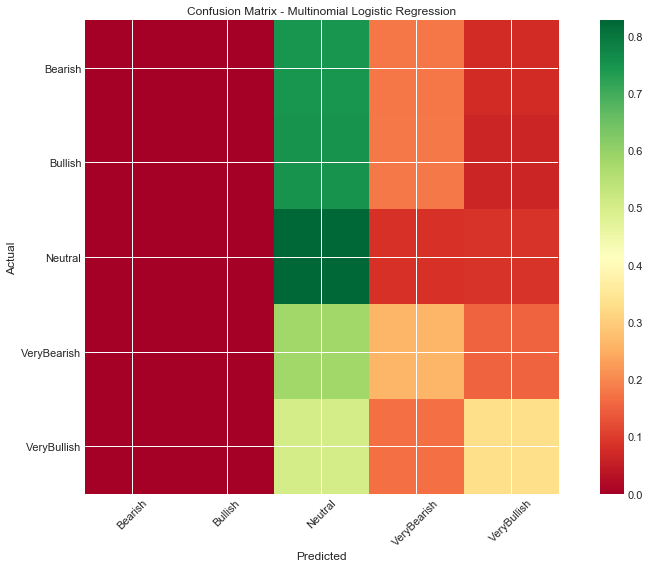

<Figure size 960x640 with 0 Axes>

In [197]:
plot_cm(MultinomialLogisConfusionMatrix, ClassLabels.ravel(), 
        'Confusion Matrix - Multinomial Logistic Regression')
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()

In [193]:
#ConfusionMatrix 
print(MultinomialLogisConfusionMatrix)

[[  0   0  50  12   5]
 [  0   0  45  11   4]
 [  0   0 454  47  48]
 [  0   0 168  76  44]
 [  0   0 161  54 106]]


### Multinomial Prediction - Improve the classifier by modifying features & tuning hyperparameters

In [229]:
##Creation of GridSearchCV Parameters
import time
from sklearn.metrics import accuracy_score
from scipy import stats
from seaborn import distplot
dual=[False]
max_iter=[50,200,250,500]
C = [0.001,1,1000,10000]
solver = ['newton-cg', 'sag', 'lbfgs']
MultiHyperparams_gridCV = dict(dual=dual,max_iter=max_iter,C=C,solver=solver)   

In [233]:
grid = GridSearchCV(estimator=MultinomialLogis, param_grid=MultiHyperparams_gridCV, cv = 4, n_jobs=-1)
start_time = time.time()
MultinomialModifiedfeatureCols=['PrevDayReturn','PrevDayHigh','PrevDayLow',
                        'Momentum','5DMomentum','10DMomentum',
                        'MACD', 'CCI','Volatility','21DMomentum','21EMA','21MA']

In [234]:
MultinomialLogis

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

In [235]:
grid_result = grid.fit(dfMultinomialData[MultinomialModifiedfeatureCols],dfMultinomialData[MultinomialTarget])
print("Prior feature columns: ")
print(MultinomialfeatureCols)
print("Accuracy BEFORE: " + str(Accuracy_Multinomial))
print("##########******AFTER tunning the Multinomial Logistic Regression hyperparameters******########")
print("Modified feature columns:" )#print("Modified feature columns" + str(MultinomialModifiedfeatureCols))
print(MultinomialfeatureCols)
print("Accuracy AFTER: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' Secs')

Prior feature columns: 
['PrevDayReturn', 'PrevDayHigh', 'PrevDayLow', 'Momentum', '5DMomentum', 'MA', 'YangZhangVol', 'MACD', 'CCI', 'ATR']
Accuracy BEFORE: 0.5044764499805372
##########******AFTER tunning the Multinomial Logistic Regression hyperparameters******########
Modified feature columns:
['PrevDayReturn', 'PrevDayHigh', 'PrevDayLow', 'Momentum', '5DMomentum', 'MA', 'YangZhangVol', 'MACD', 'CCI', 'ATR']
Accuracy AFTER: 0.435578 using {'C': 10000, 'dual': False, 'max_iter': 200, 'solver': 'newton-cg'}
Execution time: 54.87272548675537 Secs


#### Initial Chosen hyperparams and features are the best which have population prediction accuracy up to 50.44%

In [237]:
print(classification_report(dfMultinomialData[MultinomialTarget], 
                            MultinomialLogis.predict(dfMultinomialData[MultinomialfeatureCols])))

              precision    recall  f1-score   support

     Bearish       0.00      0.00      0.00       125
     Bullish       0.00      0.00      0.00       129
     Neutral       0.52      0.85      0.64      1098
 VeryBearish       0.43      0.26      0.32       602
 VeryBullish       0.50      0.34      0.41       615

    accuracy                           0.50      2569
   macro avg       0.29      0.29      0.28      2569
weighted avg       0.44      0.50      0.45      2569



## Multinomial Prediction - Probability analysis

In [296]:
#Get prediction probabilities using predict_proba method
Multinomial_Predict_Prob=MultinomialLogis.predict_proba(dfMultinomialData[MultinomialfeatureCols])

In [297]:
#Probabilities for each class, Ignore header refer First ROW as Class Label
#Class Labels['Bearish' 'Bullish' 'Neutral' 'VeryBearish' 'VeryBullish']
pd.DataFrame(np.vstack((ClassLabels.ravel(),Multinomial_Predict_Prob)))

0          1         2            3            4
0       Bearish    Bullish   Neutral  VeryBearish  VeryBullish
1     0.0317789  0.0697853  0.481728     0.191626     0.225081
2     0.0481063   0.062125   0.50362     0.200926     0.185223
3     0.0443313  0.0684657  0.492556      0.21448     0.180168
4     0.0375686  0.0735627  0.484061     0.192162     0.212646
...         ...        ...       ...          ...          ...
2565  0.0322259  0.0201117  0.242939     0.278366     0.426357
2566  0.0560309  0.0193781  0.284857     0.319805     0.319929
2567  0.0149492  0.0213413  0.229094     0.173581     0.561035
2568  0.0378703  0.0198758  0.254815     0.239239       0.4482
2569  0.0349232  0.0197996  0.252665     0.201962      0.49065

[2570 rows x 5 columns]

In [298]:
#Actual Market Sentiments loaded to an array
ActualClassLabel=dfMultinomialData[MultinomialTarget].to_numpy()

In [299]:
ActualClassLabel

array([['Neutral'],
       ['VeryBullish'],
       ['VeryBullish'],
       ...,
       ['VeryBearish'],
       ['Bearish'],
       ['Neutral']], dtype=object)

In [300]:
#Calculating maximum probability for respective class labels and returning the same into an Array
MultiPredMaxIndex = np.argmax(Multinomial_Predict_Prob,axis=1)

In [301]:
MultiPredMaxIndex

array([2, 2, 2, ..., 4, 4, 4], dtype=int64)

# Scatter plot for Multinomial prediction with color significance
    1.ORANGE => when both actual market sentiment and prediction are Bearish (Rightly predicted as BEARISH)
    2.BLUE   => when both actual market sentiment and prediction are Bullish (Rightly predicted as BULLISH)
    3.OLIVE  => when both actual market sentiment and prediction are Neutral (Rightly predicted as NEUTRAL)
    4.RED    => when both actual market sentiment and prediction are Very Bearish (Rightly predicted as VERY BEARISH)
    5.GREEN  => when both actual market sentiment and prediction are Very Bullish (Rightly predicted as VERY BULLISH)
    6.BROWN  => InCorrect Prediction(Mismatch in Actual vs predicted Market sentiment)

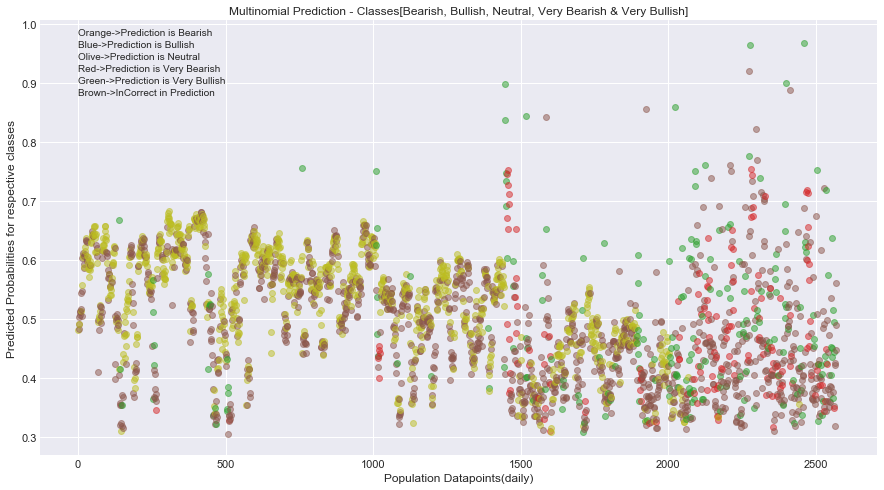

In [305]:
fig, ax = plt.subplots()
color=['tab:orange', 'tab:blue','tab:olive', 'tab:red', 'tab:green']
iColor=''
for i in range(len(MultiPredMaxIndex)):
    x=i+1 
    y=Multinomial_Predict_Prob[i][MultiPredMaxIndex[i]]
    if(ActualClassLabel[i]==ClassLabels[MultiPredMaxIndex[i]]):
        iColor=color[MultiPredMaxIndex[i]]
    else:
        iColor='tab:brown'#color[MultiPredMaxIndex[i]]
    ax.scatter(x, y, c=iColor, linewidth=1, alpha=0.5, label=iColor)
ax.set_title('Multinomial Prediction - Classes[Bearish, Bullish, Neutral, Very Bearish & Very Bullish]')
ax.grid(True)
plt.rcParams['figure.figsize'] = [15, 8]
#Bearish	Bullish	Neutral	VeryBearish	VeryBullish
plt.text(1,0.98,'Orange->Prediction is Bearish')
plt.text(1,0.96,'Blue->Prediction is Bullish')
plt.text(1,0.94,'Olive->Prediction is Neutral')
plt.text(1,0.92,'Red->Prediction is Very Bearish')
plt.text(1,0.9,'Green->Prediction is Very Bullish')
plt.text(1,0.88,'Brown->InCorrect in Prediction')
plt.style.use('seaborn-darkgrid')
plt.xlabel("Population Datapoints(daily)")
plt.ylabel("Predicted Probabilities for respective classes")
plt.show()

## Conclusion on Multinomial Prediction:
    Used Multinomial logistic regression to predict the dependent variable(Market Sentiments based on vol move) 
    where outcome is more than 02(i.e, Very Bullish/Bullish/Neutral/Bearish/Very Bearish)
    Accuracy of prediction is 50.4% when we choose Google Stock 
    (reason to choose this stock is because of more distinct multiple outcomes 
     Very Bullish/Bullish/Neutral/Bearish/Very Bearish compared to others 
     like Apple, JPMC etc., mostly their std move are with in +/-0.5 - Neutral)

# Portfolio Management  - Allocation/Contruction/Optimization

Top 05 less correlated/diversified assets Pharma(IHE)+Bonds(High IG)+Cryptocurrency+ETF based on different sectors (Finance, Real estate, Tech) and 02 exogenous [^VIX] volatility Index,Gold Index [^SPGSGC]
    1. Exchange Traded Fund based on US Pharmaceuticals   => 'IHE'
    2. Exchange Traded Fund based on US Technology Select Sector => 'XLK'
    3. Exchange Traded Fund based on US Real estate => 'IYR'
    4. Exchange Traded Fund based on Global Financials  => 'IXG'
    5. ETF - Government/High Inv Grade Corp Bonds(as underlying)/Invmt Grade Corp Bd  => 'LQD'
    6. CBOE Volatility Index (^VIX) =>'^VIX'
    7. S&P GSCI Gold Index => '^SPGSGC'

In [32]:
yf.pdr_override()
Tickers = ['IHE','XLK','IYR','IXG','LQD','^VIX']
dfDivPortfolioData = pdr.get_data_yahoo(Tickers, start="2009-01-01", end="2019-12-31")
# Day (t*) - used for later 
t=1

In [33]:
#Sample bottom 5 rows to check whether the data has been loaded to panda reader from yahoo fin API successfully
dfDivPortfolioData.tail(5)

Attributes   Adj Close                                                      \
Symbols            IHE        XLK        IYR        IXG         LQD   ^VIX   
Date                                                                         
2019-12-24  161.750000  91.239998  91.730003  68.400002  127.849998  12.67   
2019-12-26  161.050003  91.919998  92.220001  68.849998  128.080002  12.65   
2019-12-27  160.710007  91.910004  92.470001  68.860001  128.259995  13.43   
2019-12-30  159.460007  91.379997  92.540001  68.620003  128.490005  14.82   
2019-12-31  160.130005  91.669998  93.080002  68.750000  127.959999  13.78   

Attributes       Close                                   ...       Open  \
Symbols            IHE        XLK        IYR        IXG  ...        IYR   
Date                                                     ...              
2019-12-24  161.750000  91.239998  91.730003  68.400002  ...  91.779999   
2019-12-26  161.050003  91.919998  92.220001  68.849998  ...  91.839996   
2019-12-27  160.710007  91.910004  92.470001  68.860001  ...  92.300003   
2019-12-30  159.460007  91.379997  92.540001  68.620003  ...  92.209999   
2019-12-31  160.130005  91.669998  93.080002  68.750000  ...  92.470001   

Attributes                                Volume                        \
Symbols           IXG         LQD   ^VIX     IHE        XLK        IYR   
Date                                                                     
2019-12-24  68.529999  127.559998  12.65  3600.0  2445400.0  2597600.0   
2019-12-26  68.559998  128.039993  12.74  4500.0  4134600.0  3042600.0   
2019-12-27  69.059998  128.350006  12.61  7900.0  9666100.0  4802800.0   
2019-12-30  69.070000  127.900002  13.74  4600.0  8245600.0  6634400.0   
2019-12-31  68.769997  128.009995  14.84  5600.0  5800900.0  6703000.0   

Attributes                            
Symbols          IXG        LQD ^VIX  
Date                                  
2019-12-24   25100.0  2638000.0  0.0  
2019-12-26   13700.0  3879900.0  0.0  
2019-12-27  107600.0  8752100.0  0.0  
2019-12-30   19500.0  9993800.0  0.0  
2019-12-31   59100.0  5499400.0  0.0  

[5 rows x 36 columns]

In [34]:
#Compute daily log returns int
dfDivPortfolioReturns=np.log(dfDivPortfolioData['Adj Close'][Tickers]/dfDivPortfolioData['Adj Close'][Tickers].shift(1))

In [35]:
dfDivPortfolioReturns.head(5)

Symbols          IHE       XLK       IYR       IXG       LQD      ^VIX
Date                                                                  
2008-12-31       NaN       NaN       NaN       NaN       NaN       NaN
2009-01-02  0.014541  0.036947 -0.027779  0.006799 -0.010284 -0.020458
2009-01-05 -0.006363 -0.003132 -0.019803 -0.006230  0.006835 -0.002811
2009-01-06 -0.011290  0.022947  0.048388  0.021639  0.001676 -0.013395
2009-01-07 -0.011419 -0.032402 -0.034402 -0.038254 -0.008412  0.118013

In [36]:
ActReturns = ['IHE_Return','XLK_Return','IYR_Return','IXG_Return','LQD_Return','^VIX_Return']
PrevReturns = ['IHE_PrevDayRet','XLK_PrevDayRet','IYR_PrevDayRet','IXG_PrevDayRet','LQD_PrevDayRet','^VIX_PrevDayRet']

In [37]:
dfDivPortfolioReturns[PrevReturns]=dfDivPortfolioReturns[Tickers].shift(1)
dfDivPortfolioReturns[ActReturns]=dfDivPortfolioReturns[Tickers]
dfDivPortfolioReturns[ActReturns]=np.where(dfDivPortfolioReturns[ActReturns].values>0,1,-1)

In [38]:
#Data Cleansing by removing NULL values
dfDivPortfolioReturns.dropna(inplace=True)

## Cross-features and Prediction from other asset's prices
E.g. Prediction of today's US Pharmaceuticals-ETF return sign(up/down) by yesterday's other assets(Respective sector's ETFs actual returns)
    1. Exchange Traded Fund based on US Pharmaceuticals   => 'IHE'
    2. Exchange Traded Fund based on US Technology Select Sector => 'XLK'
    3. Exchange Traded Fund based on US Real estate => 'IYR'
    4. Exchange Traded Fund based on Global Financials  => 'IXG'
    5. ETF - Government/High Inv Grade Corp Bonds(as underlying)/Invmt Grade Corp Bd  => 'LQD'

In [40]:
#UDF to compute predictions from other assets
def PredictReturnFromOthers(Asset,LogifeatureCols,Target,ColName):
    LogisticReg=linear_model.LogisticRegression(C = 1e5,penalty ='l2')
    LregFit = LogisticReg.fit(dfDivPortfolioReturns[LogifeatureCols], dfDivPortfolioReturns[Target])
    LRegScore=LregFit.score(dfDivPortfolioReturns[LogifeatureCols], dfDivPortfolioReturns[ColName+'_Return'])
    dfDivPortfolioReturns[ColName+'_pred'] = LogisticReg.predict(dfDivPortfolioReturns[LogifeatureCols])
    dfDivPortfolioReturns[ColName+'_pred_return'] = dfDivPortfolioReturns[ColName] * dfDivPortfolioReturns[ColName+'_pred']
    print('Prediction Score of '+Asset+ ' Return :'+  str(round(LRegScore*100,2)) + '%' + ' from other diversified assets')

In [41]:
#Prediction of today's US Pharmaceuticals-ETF price/return
AssetIHE='Pharma-ETF'
PharmaTarget=['IHE_Return']
PharmaColName='IHE'
#Feature columns of other ETF's
PharmafeatureCols=['XLK_PrevDayRet','IYR_PrevDayRet','IXG_PrevDayRet','LQD_PrevDayRet']
PredictReturnFromOthers(AssetIHE,PharmafeatureCols,PharmaTarget,PharmaColName)

Prediction Score of Pharma-ETF Return :54.1% from other diversified assets


In [42]:
#Similarly for others we are preparing params
AssetTech='Technology-ETF'
TechTarget=['XLK_Return']
TechColName='XLK'
TechfeatureCols=['IHE_PrevDayRet','IYR_PrevDayRet','IXG_PrevDayRet','LQD_PrevDayRet']

AssetREs='Real Estate-ETF'
REsTarget=['IYR_Return']
REsColName='IYR'
REsfeatureCols=['IHE_PrevDayRet','XLK_PrevDayRet','IXG_PrevDayRet','LQD_PrevDayRet']

AssetFin='Finance-ETF'
FinTarget=['IXG_Return']
FinColName='IXG'
FinfeatureCols=['IHE_PrevDayRet','IYR_PrevDayRet','XLK_PrevDayRet','LQD_PrevDayRet']

AssetBonds='High IG Bonds-ETF'
BondsTarget=['LQD_Return']
BondsColName='LQD'
BondsfeatureCols=['IHE_PrevDayRet','XLK_PrevDayRet','IXG_PrevDayRet','IYR_PrevDayRet']


In [43]:
#Run Logistic regression for preditions by passing respective asset's params to UDF
PredictReturnFromOthers(AssetTech,TechfeatureCols,TechTarget,TechColName)
PredictReturnFromOthers(AssetREs,REsfeatureCols,REsTarget,REsColName)
PredictReturnFromOthers(AssetFin,FinfeatureCols,FinTarget,FinColName)
PredictReturnFromOthers(AssetBonds,BondsfeatureCols,BondsTarget,BondsColName)

Prediction Score of Technology-ETF Return :55.73% from other diversified assets
Prediction Score of Real Estate-ETF Return :54.9% from other diversified assets
Prediction Score of Finance-ETF Return :54.72% from other diversified assets
Prediction Score of High IG Bonds-ETF Return :55.22% from other diversified assets


## Results of Predictions from other asset prices info:
    Prediction Score of Pharma-ETF Return :54.1% 
    Prediction Score of Technology-ETF Return :55.73% 
    Prediction Score of Real Estate-ETF Return :54.9% 
    Prediction Score of Finance-ETF Return :54.72% 
    Prediction Score of High IG Bonds-ETF Return :55.22% from other diversified assets

## Plotting graph for all asset's cummulative actual vs predicted return over the tenor

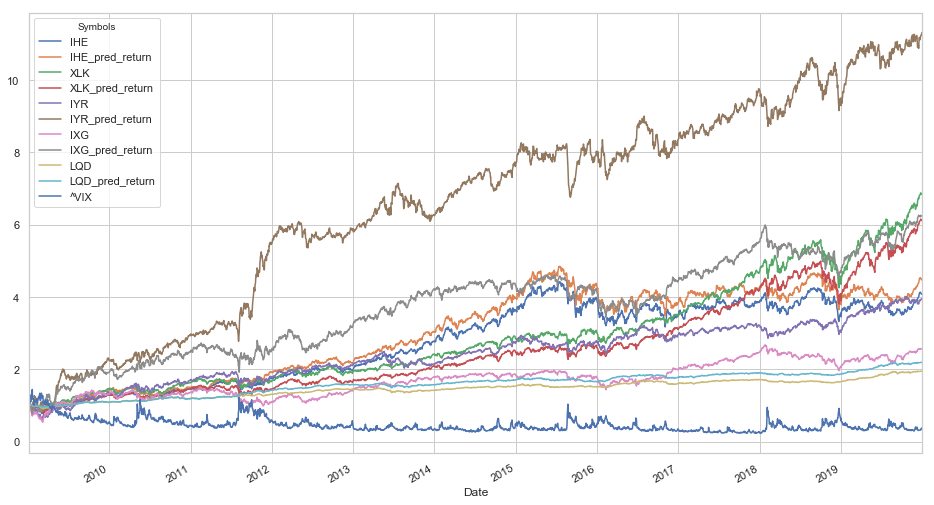

In [78]:
dfDivPortfolioReturns[['IHE', 'IHE_pred_return', # IHE=> Actual Pharma Return,IHE_pred_return=>Predicted Pharma Return
                        'XLK', 'XLK_pred_return',# XLK=> Actual Tech ETF Return,XLK_pred_return=>Predicted Tech ETF Return
                        'IYR', 'IYR_pred_return',# IYR=> Actual RealEstate Return,IYR_pred_return=>Predicted RealEstate Return
                        'IXG', 'IXG_pred_return',# IXG=> Actual Finance Return,IXG_pred_return=>Predicted Finance Return
                        'LQD', 'LQD_pred_return', # LQD=> Actual Bonds Return,LQD_pred_return=>Predicted Bonds Return
                       '^VIX' # '^VIX'=>Actual CBOE Volatility Index 
                      ]].cumsum().apply(np.exp).plot(figsize=(16, 9))

In [79]:
#Dataframe to hold predictions from other assets
dfDivPortPredict=dfDivPortfolioReturns[['IHE_pred_return','XLK_pred_return',
                                        'IYR_pred_return','IXG_pred_return','LQD_pred_return']]

In [80]:
dfDivPortPredict.tail(5)

Symbols     IHE_pred_return  XLK_pred_return  IYR_pred_return  \
Date                                                            
2019-12-24         0.001547         0.000329         0.002729   
2019-12-26        -0.004337         0.007425         0.005328   
2019-12-27        -0.002113        -0.000109         0.002707   
2019-12-30        -0.007808        -0.005783         0.000757   
2019-12-31         0.004193         0.003169         0.005818   

Symbols     IXG_pred_return  LQD_pred_return  
Date                                          
2019-12-24        -0.001023         0.001017  
2019-12-26         0.006557         0.001797  
2019-12-27         0.000145         0.001404  
2019-12-30        -0.003491         0.001792  
2019-12-31         0.001893        -0.004133

## Computing the assets weights using Lasso & Ridge Regression

In [81]:
#Lasso regression with positive coefficients ,no intercept (i.e. data is expected to be centered) and alpha to minimum
LassoReg = linear_model.Lasso(positive=True,alpha=0.0002,fit_intercept=False)

In [82]:
AllAssets= np.array(['Pharma','Tech','Reality','Finance','Bonds'])

In [83]:
#Create dataframe to hold all assets in 1st column
dfLassoBetaWgts=pd.DataFrame(data=AllAssets,columns={'Asset'})

In [84]:
#X_Features using prediction
X_Features = ['IHE_pred_return','XLK_pred_return','IYR_pred_return','IXG_pred_return','LQD_pred_return']
#Features using Actuals
#X_Features = ['IHE','XLK','IYR','IXG','LQD']

In [85]:
dfDivPortPredict=dfDivPortfolioReturns[X_Features]

In [86]:
#Create a dummy column with for fitting later stage it will be dropped
dfDivPortPredict['Y_Target']=1

In [87]:
dfDivPortPredict.head(5)

Symbols     IHE_pred_return  XLK_pred_return  IYR_pred_return  \
Date                                                            
2009-01-05        -0.006363        -0.003132         0.019803   
2009-01-06        -0.011290         0.022947         0.048388   
2009-01-07        -0.011419        -0.032402         0.034402   
2009-01-08         0.006062         0.006942        -0.004454   
2009-01-09        -0.012386        -0.022258        -0.047132   

Symbols     IXG_pred_return  LQD_pred_return  Y_Target  
Date                                                    
2009-01-05        -0.006230         0.006835         1  
2009-01-06         0.021639         0.001676         1  
2009-01-07         0.038254        -0.008412         1  
2009-01-08         0.000866         0.007130         1  
2009-01-09        -0.024245         0.012357         1

In [88]:
LassoModel = LassoReg.fit(dfDivPortPredict[X_Features],dfDivPortPredict['Y_Target'])

In [89]:
dfLassoBetaWgts['Coef'] = LassoModel.coef_

In [90]:
dfLassoBetaWgts['Weights'] = (dfLassoBetaWgts["Coef"] / dfLassoBetaWgts["Coef"].sum())

## Lasso Regression weights for each asset

In [91]:
dfLassoBetaWgts[['Asset','Weights']]

Asset   Weights
0   Pharma  0.037148
1     Tech  0.205989
2  Reality  0.192112
3  Finance  0.000000
4    Bonds  0.564751

In [92]:
#Ridge regression with no intercept (i.e. data is expected to be centered) and alpha to minimum
RidgeReg = linear_model.Ridge(alpha=0.0002,fit_intercept=False)

In [93]:
#Create dataframe to hold all assets in 1st column
dfRidgeBetaWgts=pd.DataFrame(data=AllAssets,columns={'Asset'})
#X_Features = ['GLD_pred_return','XLK_pred_return','IYR_pred_return','IXG_pred_return','LQD_pred_return']
dfDivPortPredict['Y_Target']=1
RidgeModel = RidgeReg.fit(dfDivPortPredict[X_Features],dfDivPortPredict['Y_Target'])
dfRidgeBetaWgts['Coef'] = RidgeModel.coef_
dfRidgeBetaWgts['Weights'] = (dfRidgeBetaWgts["Coef"].abs() / dfRidgeBetaWgts["Coef"].abs().sum())

## Ridge Regression weights for each asset

In [94]:
dfRidgeBetaWgts[['Asset','Weights']]

Asset   Weights
0   Pharma  0.050430
1     Tech  0.108418
2  Reality  0.079112
3  Finance  0.010246
4    Bonds  0.751794

In [95]:
#Lasso & Ridge weights into respective arrays
ArrayLassoWeights=np.array(dfLassoBetaWgts[['Asset','Weights']])
ArrayRidgeWeights=np.array(dfRidgeBetaWgts[['Asset','Weights']])

## Portfolio Rebalancing
1. Equal weights on all 05 assets [0.2,0.2...]
2. Rebalancing as per Lasso Regression
3. Rebalancing as per Ridge Regression

In [64]:
ColActReturns=['IHE','XLK','IYR','IXG','LQD']
ColPredReturns=['IHE_pred_return','XLK_pred_return','IYR_pred_return','IXG_pred_return','LQD_pred_return']

In [65]:
dfDivPortfolioReturns['Lasso_Total_ActualReturn']=np.array(pd.DataFrame(np.array(dfDivPortfolioReturns[ColActReturns])
                                                                        *ArrayLassoWeights[0:5,1]).sum(axis=1))
dfDivPortfolioReturns['Ridge_Total_ActualReturn']=np.array(pd.DataFrame(np.array(dfDivPortfolioReturns[ColActReturns])
                                                                        *ArrayRidgeWeights[0:5,1]).sum(axis=1))
dfDivPortfolioReturns['EqualWgts_Total_ActualReturn']=np.array(pd.DataFrame(np.array(dfDivPortfolioReturns[ColActReturns])
                                                                            /5.0).sum(axis=1))
dfDivPortfolioReturns['Lasso_Total_PredReturn']=np.array(pd.DataFrame(np.array(dfDivPortfolioReturns[ColPredReturns])
                                                                      *ArrayLassoWeights[0:5,1]).sum(axis=1))
dfDivPortfolioReturns['Ridge_Total_PredReturn']=np.array(pd.DataFrame(np.array(dfDivPortfolioReturns[ColPredReturns])
                                                                      *ArrayRidgeWeights[0:5,1]).sum(axis=1))
dfDivPortfolioReturns['EqualWgts_Total_PredReturn']=np.array(pd.DataFrame(np.array(dfDivPortfolioReturns[ColPredReturns])
                                                                          /5.0).sum(axis=1))

In [66]:
dfDivPortfolioReturns.head()

Symbols          IHE       XLK       IYR       IXG       LQD      ^VIX  \
Date                                                                     
2009-01-05 -0.006363 -0.003132 -0.019803 -0.006230  0.006835 -0.002811   
2009-01-06 -0.011290  0.022947  0.048388  0.021639  0.001676 -0.013395   
2009-01-07 -0.011419 -0.032402 -0.034402 -0.038254 -0.008412  0.118013   
2009-01-08  0.006062  0.006942 -0.004454  0.000866  0.007130 -0.019314   
2009-01-09 -0.012386 -0.022258 -0.047132 -0.024245  0.012357  0.006090   

Symbols     IHE_PrevDayRet  XLK_PrevDayRet  IYR_PrevDayRet  IXG_PrevDayRet  \
Date                                                                         
2009-01-05        0.014541        0.036947       -0.027779        0.006799   
2009-01-06       -0.006363       -0.003132       -0.019803       -0.006230   
2009-01-07       -0.011290        0.022947        0.048388        0.021639   
2009-01-08       -0.011419       -0.032402       -0.034402       -0.038254   
2009-01-09        0.006062        0.006942       -0.004454        0.000866   

Symbols     ...  IXG_pred  IXG_pred_return  LQD_pred  LQD_pred_return  \
Date        ...                                                         
2009-01-05  ...       1.0        -0.006230       1.0         0.006835   
2009-01-06  ...       1.0         0.021639       1.0         0.001676   
2009-01-07  ...      -1.0         0.038254       1.0        -0.008412   
2009-01-08  ...       1.0         0.000866       1.0         0.007130   
2009-01-09  ...       1.0        -0.024245       1.0         0.012357   

Symbols     Lasso_Total_ActualReturn  Ridge_Total_ActualReturn  \
Date                                                             
2009-01-05                 -0.000826                  0.002847   
2009-01-06                  0.014550                  0.007228   
2009-01-07                 -0.018458                 -0.013526   
2009-01-08                  0.004826                  0.006075   
2009-01-09                 -0.007121                  0.002275   

Symbols     EqualWgts_Total_ActualReturn  Lasso_Total_PredReturn  \
Date                                                               
2009-01-05                     -0.005739                0.006783   
2009-01-06                      0.016672                0.014550   
2009-01-07                     -0.024977               -0.005240   
2009-01-08                      0.003309                0.004826   
2009-01-09                     -0.018733               -0.007121   

Symbols     Ridge_Total_PredReturn  EqualWgts_Total_PredReturn  
Date                                                            
2009-01-05                0.005981                    0.002182  
2009-01-06                0.007228                    0.016672  
2009-01-07               -0.007299                    0.004085  
2009-01-08                0.006075                    0.003309  
2009-01-09                0.002275                   -0.018733  

[5 rows x 34 columns]

### Plot to represent ACTUAL Returns by rebalancing weights -  Lasso vs Ridge vs Equal composition  

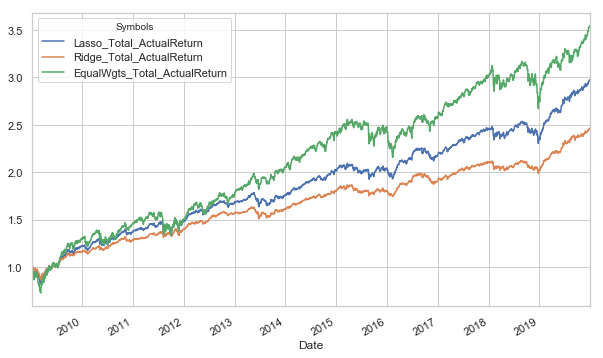

In [67]:
dfDivPortfolioReturns[[ 'Lasso_Total_ActualReturn', 'Ridge_Total_ActualReturn', 
                        'EqualWgts_Total_ActualReturn'
                      ]].cumsum().apply(np.exp).plot(figsize=(10, 6))

### Plot to represent Predicted Returns by rebalancing weights -  Lasso vs Ridge vs Equal composition  

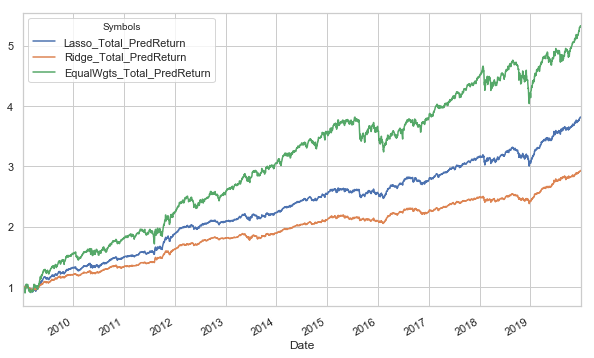

In [68]:
dfDivPortfolioReturns[[ 'Lasso_Total_PredReturn', 'Ridge_Total_PredReturn', 
                        'EqualWgts_Total_PredReturn'
                      ]].cumsum().apply(np.exp).plot(figsize=(10, 6))

## Hedging by Adding Volatility Index(CBOE Volatility Index - ^VIX) to rebalanced portfolio
This is not 100% exercise but helps us to protect from heavy market shocks/regime change


In [104]:
dfDivPortfolioReturns['Lasso_HedgeTotal_ActualReturn']=dfDivPortfolioReturns['Lasso_Total_ActualReturn']+dfDivPortfolioReturns['^VIX']
dfDivPortfolioReturns['Ridge_HedgeTotal_ActualReturn']=dfDivPortfolioReturns['Ridge_Total_ActualReturn']+dfDivPortfolioReturns['^VIX']
dfDivPortfolioReturns['EqualWgts_HedgeTotal_ActualReturn']=dfDivPortfolioReturns['EqualWgts_Total_ActualReturn']+dfDivPortfolioReturns['^VIX']

In [105]:
dfDivPortfolioReturns[['Lasso_HedgeTotal_ActualReturn','Ridge_HedgeTotal_ActualReturn','EqualWgts_HedgeTotal_ActualReturn']].head()

Symbols     Lasso_HedgeTotal_ActualReturn  Ridge_HedgeTotal_ActualReturn  \
Date                                                                       
2009-01-05                      -0.003637                       0.000037   
2009-01-06                       0.001154                      -0.006167   
2009-01-07                       0.099555                       0.104487   
2009-01-08                      -0.014488                      -0.013239   
2009-01-09                      -0.001031                       0.008365   

Symbols     EqualWgts_HedgeTotal_ActualReturn  
Date                                           
2009-01-05                          -0.008549  
2009-01-06                           0.003277  
2009-01-07                           0.093036  
2009-01-08                          -0.016005  
2009-01-09                          -0.012643

## Plot to represent how overall returns are optimized by adding VIX component to our bucket of assets(ETF) post rebalancing

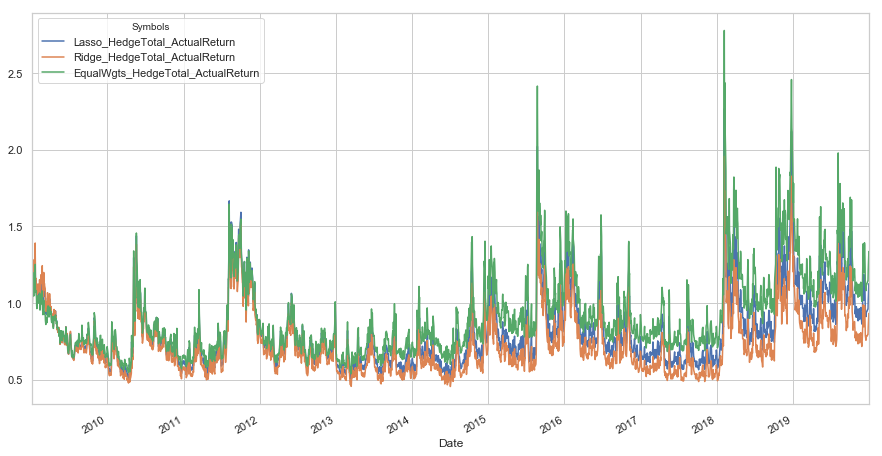

In [107]:
dfDivPortfolioReturns[[ 'Lasso_HedgeTotal_ActualReturn', 'Ridge_HedgeTotal_ActualReturn', 
                        'EqualWgts_HedgeTotal_ActualReturn'
                      ]].cumsum().apply(np.exp).plot(figsize=(15, 8))

## Conclusion(Adding Volatility Index to our Portfolio):
    From the above plot we clearly evidence green(equal weights) vs blue/orange(lasso/ridge weights) 
    spikes were more when our porfolio not properly rebalanced(Green labels) although we have added VIX
    E.g. Most recently, the US stock market had almost crashed in late Jan/early Feb'18. 
        The Dow Jones Industrial Average fell 8.2% in just 05-06 days (It is marked by its suddeness) 
        where Volatility has changed from 11.2% to more than 37% and
        hence we can see huge spike, these kinda turbulences can be protected by rebalancing 
        our porfolio with proper asset weights along by hedging (adding VIX)

# Black-Litterman model:
The BL model considers investors views and market equilibrium in terms of probability distributions. 
It uses the Bayesian probability distribution for calculating expected return by capital asset pricing model(CAPM) as a starting point and then combining investors views into the distribution. 
Using the Implied returns from CAPM and adding the investors views a posterior distribution be obtained

Step by Step calculations as follows:

In [595]:
dfAssetPrices = dfDivPortfolioData['Adj Close']

In [596]:
dfAssetPrices=dfAssetPrices[ColActReturns]

In [601]:
weights  = ArrayRidgeWeights[0:5,1]

In [602]:
print("Initial weights as per Ridge's regression model:")
dfRidgeBetaWgts[['Asset','Weights']]

Initial weights as per Ridge's regression model:


Asset   Weights
0   Pharma  0.050430
1     Tech  0.108418
2  Reality  0.079112
3  Finance  0.010246
4    Bonds  0.751794

In [604]:
print('Asset Prices:')
dfAssetPrices.head(5)

Asset Prices:


Symbols           IHE        XLK        IYR        IXG        LQD
Date                                                             
2008-12-31  38.530098  12.876481  24.165211  26.574633  66.360939
2009-01-02  39.094456  13.361126  23.503153  26.755926  65.681999
2009-01-05  38.846474  13.319346  23.042299  26.589745  66.132446
2009-01-06  38.410378  13.628515  24.184687  27.171391  66.243378
2009-01-07  37.974281  13.194007  23.366837  26.151615  65.688507

In [605]:
#UDF to return covariance and mean returns matrix from input assets dataframe
def getRetCovMatrix(df): 
    AssetPrice = df.copy()
    AssetPrice = (AssetPrice / AssetPrice.shift(1)) -1
    AssetPrice.iloc[0,:] = 0    
    Ret = np.matrix(AssetPrice)
    MeanRet = np.mean(Ret, axis = 0)
    AnnualRet = np.array([])
    for i in range(len(np.transpose(MeanRet))):
        AnnualRet = np.append(AnnualRet,(MeanRet[0,i]+1)**252-1)   
    cov = AssetPrice.cov()*252
    return (AnnualRet, np.matrix(cov))

In [606]:
annualReturn,Covar = getRetCovMatrix(dfAssetPrices)

In [386]:
#Covariance Matrix
pd.DataFrame(Covar,index = ColActReturns,columns = ColActReturns)

IHE       XLK       IYR       IXG       LQD
IHE  0.032305  0.021613  0.021905  0.027089 -0.000045
XLK  0.021613  0.032320  0.027253  0.033594  0.000017
IYR  0.021905  0.027253  0.061143  0.046056  0.002372
IXG  0.027089  0.033594  0.046056  0.060397  0.000222
LQD -0.000045  0.000017  0.002372  0.000222  0.003250

## Risk aversion coefficient(δ)

In [610]:
# Delta=Risk aversion coefficient(δ) = (E(r) – rf)/σ2
#rf-> Risk free rate
#E(r)-> Return of the portfolio
#σ2 -> Variance
USDLibor1Y=0.02 # Risk free rate(usually US Tbill 1Y or SONIA commulated to 1Year)
var = np.dot(np.dot(weights,Covar),np.transpose(weights))
PortfolioReturn = np.sum(weights*annualReturn)
delta=np.asscalar((PortfolioReturn - USDLibor1Y) / var)
print("Risk aversion coefficient: "+str(delta)) 

Risk aversion coefficient: 18.16525080294277


## Implied Returns, Π

In [390]:
#Π = implied returns = δΣω
#δ = Risk aversion coefficient => δ = (E(r) – rf)/σ2
PI = np.dot(delta,np.dot(weights,Covar))

In [611]:
pd.DataFrame(np.transpose(PI), index=ColActReturns,columns=['Implied Return'])

Implied Return
IHE       0.108065
XLK         0.1291
IYR       0.202567
IXG       0.171439
LQD       0.047828

## Investor's View P-Matrix, Expected Returns Q-Matrix

In [396]:
##Investor's Views on P 
#P, a 3*5 matrix of the assets weights within each view. 
#For a relative view the sum of the weights will be 0, for an absolute view the sum of the weights will be 1.
P= np.array([[ 0.,  0.,  0.,  1., -1.],
       [-1.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0., -1.,  0.]])
#Q, a 3*1 matrix The expected returns of the portfolios from the views described in matrix P
Q= np.array([[0.005],
       [0.01 ],
       [0.005]])

In [454]:
#A diagonal covariance matrix with entries of the uncertainty
def calcOmegaDiagMatrix(P, Covar):
    omega = np.dot(1/len(dfAssetPrices),np.dot(P,np.dot(Covar,np.transpose(P))))
    for i in range(len(omega)):
        for y in range(len(omega)):
            if i != y: omega[i,y] = 0
    return omega

## Posterior Estimated Returns E(R)

In [565]:
#posterior estimated return(E(R))
#E(R) = [(τ Σ)-1 + PT ΩP]-1 [(τ Σ)-1 Π + PT ΩQ]
#τ = 1/N
#Σ = A covariance matrix of the assets 
#ω = Weights of assets according to Ridge regression
t=1/len(dfAssetPrices)
postEstRet=np.transpose(PI) + np.dot(t*np.dot(Covar,np.transpose(P)),
                                     np.dot((np.linalg.inv(np.dot(P*t,np.dot(Covar,np.transpose(P))) 
                                                           + calcOmegaDiagMatrix(P, Covar)))
                                            ,(Q - np.dot(P,np.transpose(PI)))))

In [612]:
pd.DataFrame(postEstRet,index = ColActReturns,columns=['Posterior Estimated Returns'])

Posterior Estimated Returns
IHE                   0.0921059
XLK                   0.0987579
IYR                     0.13562
IXG                    0.102594
LQD                   0.0484785

## Posterior Covariance Matrix

In [571]:
#Posterior CoVariance
#Σp = Σ +[(τΣ)-1 + PT Ω-1P]-1
PostCoVar = Covar +( (t*Covar - np.dot(t*np.dot(Covar,np.transpose(P))
                                       ,np.dot(np.linalg.inv(t*np.dot(P,np.dot(Covar,np.transpose(P)))
                                                             +calcOmegaDiagMatrix(P, Covar)),(t*np.dot(P,Covar))))))

In [584]:
print("Posterior CoVariance Matrix:")
pd.DataFrame(PostCoVar,index = ColActReturns,columns=ColActReturns)

Posterior CoVariance Matrix


IHE       XLK       IYR       IXG       LQD
IHE  0.032314  0.021618  0.021911  0.027095 -0.000045
XLK  0.021618  0.032328  0.027259  0.033600  0.000017
IYR  0.021911  0.027259  0.061155  0.046063  0.002372
IXG  0.027095  0.033600  0.046063  0.060407  0.000223
LQD -0.000045  0.000017  0.002372  0.000223  0.003251

## New Weights as per Black-Litterman model

In [650]:
#New weights
NewWeights = np.dot(np.transpose(postEstRet),np.linalg.inv(delta*PostCoVar))
print("New Weights as per Black-Litterman model:")
pd.DataFrame(NewWeights, columns = ColActReturns)

New Weights as per Black-Litterman model:


IHE      XLK        IYR        IXG       LQD
0  0.0875575  0.12743  0.0419377 -0.0515645  0.794279

In [651]:
NewWeights.sum()

0.9996389891696753

In [652]:
NewWeightsArray = np.array(NewWeights).reshape(5,)

# Bar plots on BL model's weights and Posterior return vs Initial data

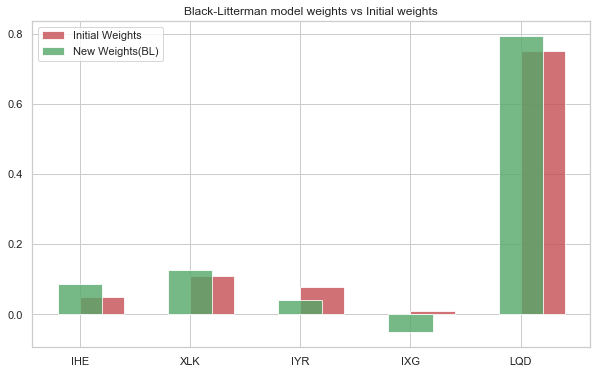

In [673]:
from matplotlib import pyplot
pyplot.bar(x=ColActReturns,height=weights, alpha=0.8,align ='edge' , width=0.4, label='Initial Weights',color='r')
pyplot.bar(x=ColActReturns,height=NewWeightsArray, alpha=0.8, width=0.4, label='New Weights(BL)',color='g')
pyplot.legend(loc='upper left')
pyplot.title('Black-Litterman model weights vs Initial weights')
pyplot.show()

In [669]:
postEstRetArray = np.array(postEstRet).reshape(5,)
InitialRetArray = np.array(annualReturn).reshape(5,)

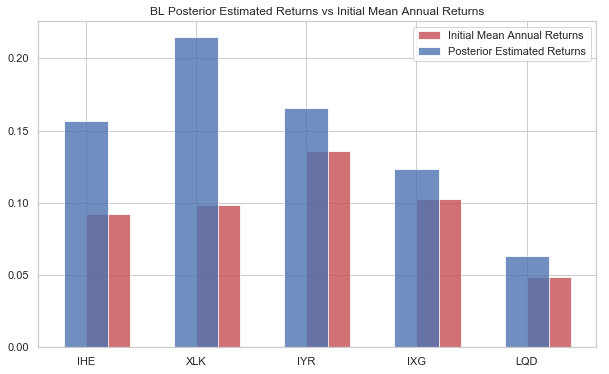

In [676]:
pyplot.bar(x=ColActReturns,height=postEstRetArray, alpha=0.8,align ='edge'
           ,width=0.4, label='Initial Mean Annual Returns',color='r')
pyplot.bar(x=ColActReturns,height=InitialRetArray, alpha=0.8, 
           width=0.4, label='Posterior Estimated Returns',color='b')
pyplot.legend(loc='upper right')
pyplot.title('BL Posterior Estimated Returns vs Initial Mean Annual Returns')
pyplot.show()

# Co-integration Analysis/Test

In [69]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [70]:
yf.pdr_override()
Tickers = ['IHE','XLK','IYR','IXG','LQD']
dfCoIntPortfolioData = pdr.get_data_yahoo(Tickers, start="2009-01-01", end="2019-12-31")

In [71]:
dfCoIntPriceData = dfCoIntPortfolioData['Adj Close']

In [72]:
dfCoIntPriceData.head()

Symbols           IHE        XLK        IYR        IXG        LQD
Date                                                             
2008-12-31  38.530098  12.876481  24.165211  26.574633  66.360939
2009-01-02  39.094456  13.361126  23.503153  26.755926  65.681999
2009-01-05  38.846474  13.319346  23.042299  26.589745  66.132446
2009-01-06  38.410378  13.628515  24.184687  27.171391  66.243378
2009-01-07  37.974281  13.194007  23.366837  26.151615  65.688507

1. Pharma => 'IHE'
2. Tech => 'XLK'
3. Real estate => 'IYR'
4. Financial  => 'IXG'
5. Corp Bonds(High IG)=> 'LQD'

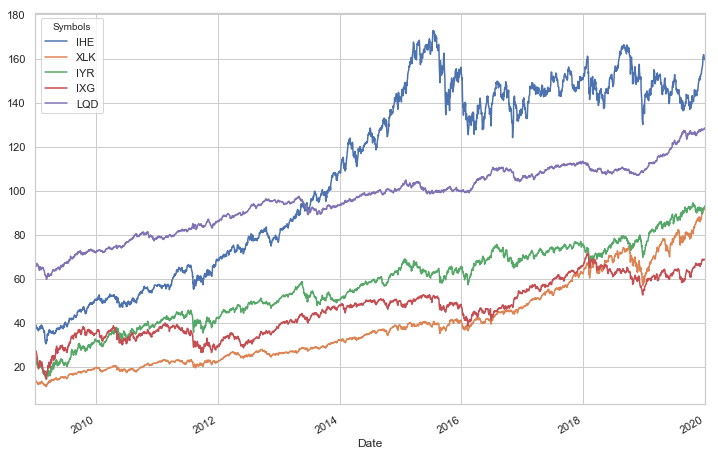

In [74]:
dfCoIntPriceData[['IHE','XLK','IYR','IXG','LQD']].plot(figsize=(12, 8))

## From the above plot we have following observations:
1. Pharma (trend in blue) is no where have same trend w.r.t other 04 assets 
2. Technology ETF (trend in Orange) is intersected with Finance(Red) and Real estate(Green)
3. Finance ETF (trend in Red) is intersected with Real estate(Green) multiple times
4. Only High IG Corp Bonds(trend in purple) is moving almost similar to Real Estate(Green)

 So Let's perform Co-Integration test for Real Estate ETF(X) & Corp Bonds ETF (Y) using Augmented Dickey-Fuller unit root test

Steps includes:
#1 Get optimal hedge ratio
#2 Multiple the hedge ratio(h) with other Asset(i.e., Asset Y)
#3 Calculate the spread =(X-h*Y)
#4 If Spread is closer to Zero(0) or mean reverting we can conclude Asset X & Y Co-Integrated else FAILED

In [75]:
#X=IYR
#Y=LQD
OLSStatsModel = sm.OLS(dfCoIntPriceData['IYR'], dfCoIntPriceData['LQD'])
OLSModelFit = OLSStatsModel.fit() 
HedgeRatio=OLSModelFit.params[0]
print('Hedge ratio(h) = ' + str(HedgeRatio))

Hedge ratio(h) = 0.6064228979415569


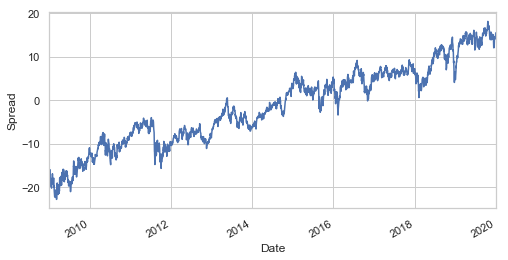

In [76]:
#Spread=X – Hedge Ratio*Y
dfCoIntPriceData['Spread_IYR_LQD'] = dfCoIntPriceData['IYR'] - HedgeRatio *  dfCoIntPriceData['LQD']
dfCoIntPriceData.Spread_IYR_LQD.plot(figsize=(8,4))
plt.ylabel("Spread")
plt.show()

### Initially Spread is Negative and slowly it's increasing, means it's NOT Co-Integrated although at a glance it resembles like they are..

#### Let's prove the same with the following calculations using ADFuller model using Test statistics vs Critical Values
If Test stats are lesser than Critical values then we can conclude 02 assets are Co-Integrated with respective % certainity

In [77]:
#Perform Augmented Dickey-Fuller unit root test
#Used for a unit root in a univariate process in the presence of serial correlation
adf = adfuller(dfCoIntPriceData.Spread_IYR_LQD, maxlag = 1)
print('Test statistics: ' +str(adf[0]))
print('Critical Values: ' +str(adf[4]))

Test statistics: -1.4323431021849475
Critical Values: {'1%': -3.4327155138680454, '5%': -2.8625851157957265, '10%': -2.5673263480950106}


# Conclusion on CoIntegration analysis: 
    As the test stats (-1.432) > 10% Critical Value(-2.567) 
    assets Real Estate ETF(X) & Corp Bonds ETF (Y)  are NOT Co-Integrated
    and our selected portfolio bucket of ETFs-Pharma,Tech,Bonds,Finance,Reality along with exogenous Assets(Short Gold)/Long VIX would help our bucket(ETF's) from market turbulence

#                                    *****End of the Project*****